  <h1><center>ECMWF MOOC MACHINE LEARNING IN WEATHER AND CLIMATE</center></h1>

   <h2><center>Tier 3: Practical ML application in weather and climate - OBSERVATIONS</center></h2>
   
   <center><h2> Exercise on how to build a simple ANN model for satellite precipitation retrieval using passive microwave measurements </h2></center>
  <p style="margin-bottom:1.5cm;"> </p>
   
   <center><font size="8"><strong>SOLUTIONS</strong></font></center>


<font size="5">To see my work, please jump right in the last section by clicking [HERE](SOL_mooc_tier3_1_ml_sat_panegrossi_v5.ipynb#exploration-exercises). The statement of the exercises are [there](#additional-exercises).</font>

This is a modified version of the notebook provided in the context of the ECMWF MOOC on machine learning in weather and climate. It contains my work on the proposed exercises at the end of the notebook.

The original notebook can be found on <a href="https://github.com/ecmwf-projects/mooc-machine-learning-weather-climate/blob/main/tier_3/observations/mooc_tier3_1_ml_sat_panegrossi_v5.ipynb">ECMWF's GitHub</a>. It was created by Daniele Casella, Paolo Sanò, Leo Pio D'Adderio, Riccardo D'Ercole (CNR-ISAC, Rome Italy).


# Introduction
    
This Jupiter Notebook is on how to build a simple Artificialt Neural Network (ANN) (Multilayer Perceptrons) for surface precipitation rate estimation using the GPM Microwave Imager (GMI) measurements as input. The training dataset is a small-size osbervational dataset built from coincident measurements of the GMI and the Dual-frequency Precipitation Radar (DPR) on board the NASA/JAXA GPM-Core Observatory. The ANN architecture is pre-defined and an optimal set of parameters for the training phase is provided. The goal is to define the ANN (the weights) by minimising the prediction error (the loss function) avoiding overfitting during training. As you go through this Jupiter Notebook, you will learn about GMI characteristics, definition of ANN architecture, key parameters in the training phase, minimisation of the loss function, and overfitting. The ANN model obtained will be applied to one case study. 

As First Task it is recommended that you go through the code and the plots provided, understanding the meaning of each step. As a second Task you may run the code, play with the parameters, and analyse the results. Please, consider that the training for each set of parameters can take a few minutes. 

you can run this code on [colab](https://colab.research.google.com/github/ecmwf-projects/mooc-machine-learning-weather-climate/blob/main/tier_3/observations/mooc_tier3_1_ml_sat_panegrossi_v5.ipynb)

   

## Before starting: python and libraries installation

### Python
    
Python 3 is required for running this code on your machine. The fastest way to have python is to install the [Anaconda Package](https://www.anaconda.com/products/individual).  By the way, python can be installed on all OS, there are versions of Anaconda for Linux Mac and Windows, however this code has been tested for Linux Ubuntu and windows 64 bit OS. 

Before starting you need to install some additional software and some python packages.

### Libraries installation

If you are using Anaconda the easiest way to get everything installed is to use conda (from a terminal or Anaconda Prompt in Windows) to create a new virtual environment:


<p style="background:black">
<code style="background:black;color:white"> 
  user@user:/home/user$ conda create -n tf tensorflow pandas scikit-learn matplotlib basemap xarray netCDF4 h5netcdf h5py wget
  user@user:/home/user$ conda activate tf
</code>
</p>

### run in colab

Otherwise if you are using colab you will need to install two libraries (wget and basemap), after the installation you will be asked to "restart runtime", you need to click on the "restart runtime" label.
It is convenient to run this code with GPU enabled, you can do that from the edit menu.


In [1]:
!pip install wget basemap

### Data download
    
    
Before running the notebook you need to download some data:

In [2]:
import wget
url = 'https://get.ecmwf.int/repository/mooc-machine-learning-weather-climate/tier_3/observations/1C-R.GPM.GMI.XCAL2016-C.20200916-S130832-E144106.037225.V07A.HDF5'
filename = wget.download(url)
url = 'https://get.ecmwf.int/repository/mooc-machine-learning-weather-climate/tier_3/observations/2A.GPM.GMI.GPROF2021v1.20200916-S130832-E144106.037225.V07A.HDF5'
filename = wget.download(url)
url = 'https://get.ecmwf.int/repository/mooc-machine-learning-weather-climate/tier_3/observations/dataset2_GMI_DPR_RR.nc'
filename = wget.download(url)

100% [......................................................] 7440095 / 7440095

# GMI - GPM Microwave Imager
The GMI is the most advanced spaceborne MW radiometer currently available, operating on the NASA/JAXA GPM Core Observatory (GPM-CO) launched in March 2014 (https://gpm.nasa.gov/). The GMI is a conical-scanning radiometer measuring vertically (V) and horizontally (H) polarised radiances in 13 channels between 10.65 and 183.31 GHz. Table 1 presents some details on GMI channels and their properties. In each channel the measured radiance, which is converted into brightness temperature (TB) for physical interpretation, results from the interaction of surface-emitted radiation with atmospheric water vapour and the liquid and solid hydrometeros within the cloud. Its 13 channels have different penetration ability in the cloud and are sensitive to different hydrometeor types and precipitation intensities. Complex retrieval algorithms convert the multichannel TBs in surface precipitation rate. There are several factors which makes the quantitative precipitation estimation from PMW radiometers (and from GMI) very challenging. Moreover, the relationhip between the multichannel TBs and surface rain rate is indirect and highly non linear, and machine learning techniques can be used to overcome some of these issues (e.g., Sanò et al., doi:10.3390/rs10071122) .


 No. | Central frequency (GHz) | Polarisation | IFOV size 
 :-: | :-: | :-: | :-: 
 1 | 10.65 | V | 19x32 km
 2 | 10.65 | H | 19x32 km
 3 | 18.7 | V | 11x18 km
 4 | 18.7 | H | 11x18 km
 5 | 23.8 | V | 9.2x15 km
 6 | 36.5 | V | 8.6x14 km
 7 | 36.5 | H | 8.6x14 km
 8 | 89.0 | V | 4.4x7.2 km
 9 | 89.0 | H | 4.4x7.2 km 	
10 | 166.5 | V | 4.4x7.2 km
11 | 166.5 | H | 4.4x7.2 km	
12 | 183.31 ± 3 | V | 4.4x7.2 km
13 | 183.31 ± 7 | V | 4.4x7.2 km	

<center><i>Table 1. GMI channels characteristics</i></center>

Now, we are ready to read the GMI files. The GMI files format is HDF5, and the "h5py" library has to be imported in order to be able to read the data. At the following link <a href="https://gpm.nasa.gov/resources/documents/file-specification-gpm-products/">GPM File Specification</a> you can find the document explaining the GMI file structure as well as the file structure of all Level 1 to Level 3 GPM products. The GPM products (including GMI) can be downloaded from <a href="https://storm.pps.eosdis.nasa.gov/storm/"> the NASA PPS Storm </a> website. In the following block we see how to open and read the content of a HDF5 file (i.e. the GMI file).

In [3]:
import h5py
gmi_file_path='./1C-R.GPM.GMI.XCAL2016-C.20200916-S130832-E144106.037225.V07A.HDF5'
hf=h5py.File(gmi_file_path,'r')
dataset1=hf['S1']
print(dataset1.keys())


<KeysViewHDF5 ['ScanTime', 'SCstatus', 'Latitude', 'Longitude', 'sunLocalTime', 'Quality', 'incidenceAngle', 'sunGlintAngle', 'incidenceAngleIndex', 'Tc']>


### GMI TB Imagery
In the following block, we are going to see how to create TB imagery for selected GMI channels.

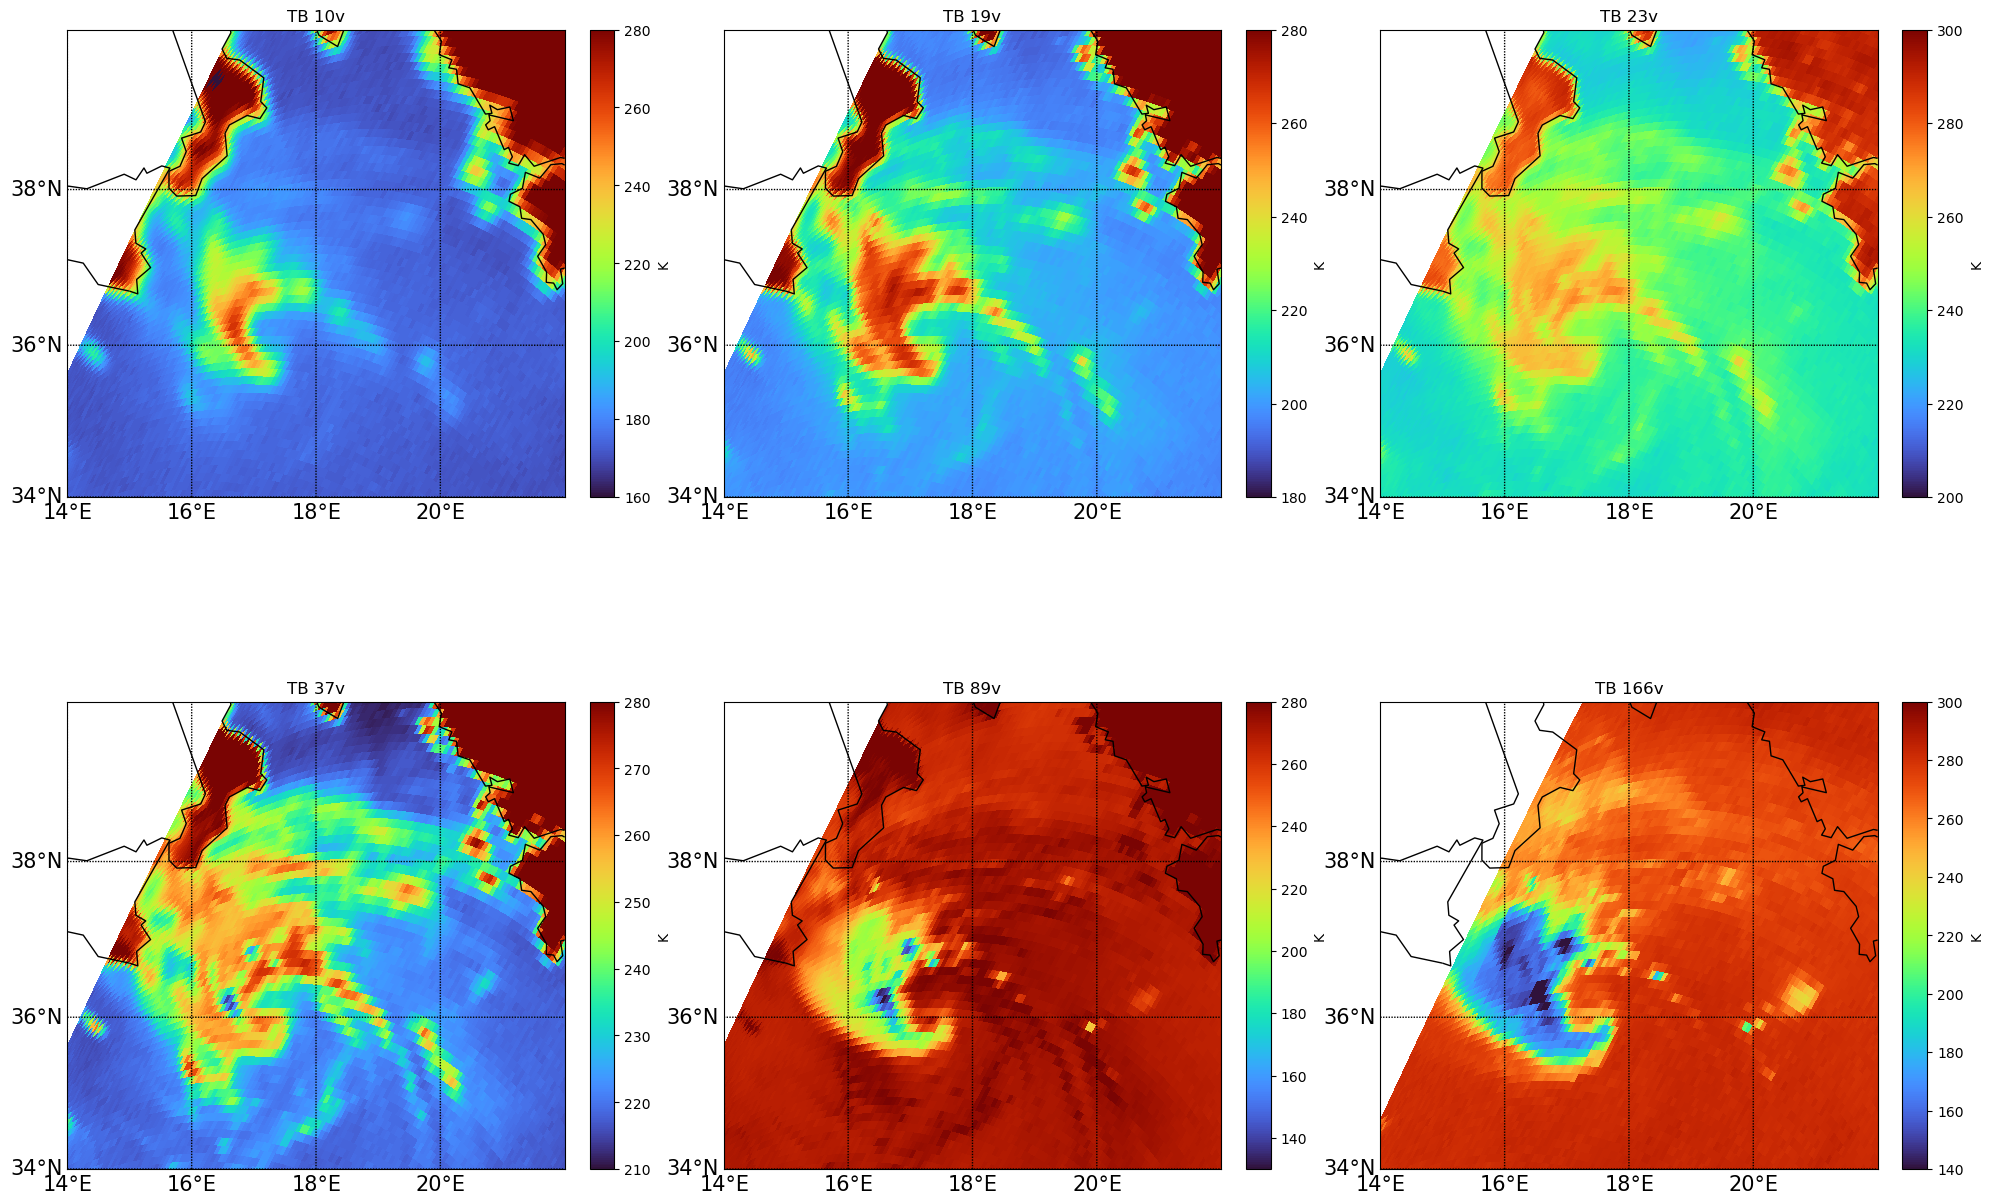

In [4]:
# defining the funcion to plot
def plot_tb_map(TB,lat,lon,colorAxisMin,colorAxisMax):
    # set the lat/lon borders of the map
    latborders=[34,40]
    lonborders=[14,22]
    m = Basemap(projection='merc',
        resolution='l',
        lat_ts=20,
        llcrnrlat=latborders[0],urcrnrlat=latborders[1],\
        llcrnrlon=lonborders[0],urcrnrlon=lonborders[1])

    
#E set min/max values of the colorbar
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        im1 = m.pcolor(lon[:],lat[:],TB[:],shading='nearest',cmap='turbo',latlon=True,vmin=colorAxisMin,vmax=colorAxisMax)
    m.drawcoastlines()
    
# set parallels and meridians
    dparal=2 #separation in deg between drawn parallels
    parallels = np.arange(latborders[0],latborders[1],dparal)
    dmerid=2 #separation in deg between drawn meridians
    meridians = np.arange(lonborders[0],lonborders[1],dmerid)
    m.drawparallels(parallels,labels=[1,0,0,0],fontsize=15)
    m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=15) 
# add colorbar.
    cbar = m.colorbar(location='right',pad="5%")
    cbar.set_label('K')



#windows users may need to set an environmental variable before
#import os
#os.environ["PROJ_LIB"] = 'C:'+os.sep+'Users'+os.sep+'Leo'+os.sep+'anaconda3'+os.sep+'Library'+os.sep+'share'; #with your anaconda installation path

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap 
from mpl_toolkits.basemap import Basemap
import numpy as np
import h5py
import warnings

gmi_file_path='./1C-R.GPM.GMI.XCAL2016-C.20200916-S130832-E144106.037225.V07A.HDF5'
hf=h5py.File(gmi_file_path,'r')

dataset1=hf['S1']
dataset2=hf['S2']
lat1=hf['S1/Latitude'][:]
lon1=hf['S1/Longitude'][:]
TB=hf['S1/Tc'][:]
TB10v=TB[:,:,0]
TB10h=TB[:,:,1]
TB19v=TB[:,:,2]
TB19h=TB[:,:,3]
TB23v=TB[:,:,4]
TB37v=TB[:,:,5]
TB37h=TB[:,:,6]
TB89v=TB[:,:,7]
TB89h=TB[:,:,8]

lat2=hf['S2/Latitude'][:]
lon2=hf['S2/Longitude'][:]


TB=hf['S2/Tc'][:]
TB166v=TB[:,:,0]
TB166v[TB166v<0]=np.NaN
TB166h=TB[:,:,1]
hf.close()

fig = plt.figure(figsize=(24,16))
ax = fig.add_subplot(231)
plot_tb_map(TB10v,lat1,lon1,colorAxisMin=160,colorAxisMax=280)
plt.title('TB 10v')

ax = fig.add_subplot(232)
plot_tb_map(TB19v,lat1,lon1,colorAxisMin=180,colorAxisMax=280)
plt.title('TB 19v')

ax = fig.add_subplot(233)
plot_tb_map(TB23v,lat1,lon1,colorAxisMin=200,colorAxisMax=300)
plt.title('TB 23v')

ax = fig.add_subplot(234)
plot_tb_map(TB37v,lat1,lon1,colorAxisMin=210,colorAxisMax=280)
plt.title('TB 37v')

ax = fig.add_subplot(235)
plot_tb_map(TB89v,lat1,lon1,colorAxisMin=130,colorAxisMax=280)
plt.title('TB 89v')

ax = fig.add_subplot(236)
plot_tb_map(TB166v,lat1,lon1,colorAxisMin=140,colorAxisMax=300)
plt.title('TB 166v')

plt.show()



The panels show the GMI brightness temperatures (TBs) for the overpass which captured the Mediterranean Hurricane (Medicane) named Ianos on 16/09/2020 over the Ionian Sea between Southern Italy and Greece.
The first row of panels shows the low frequency channels (< 30 GHz) affected mostly by the emission of radiation by the rain droplets, which results in higher TBs with respect to the radiatively cold sea surface background (warm areas in the imagery are associated to the precipitation in the rain bands around the cyclone center). The second row of panels shows the higher frequency channels, where the effect of the scattering by the ice on the observed TBs becomes visible as cold areas in the imagery. The scattering signal at 37 GHz and 89 GHz channel (low TBs) are due to the larger (and denser) frozen hydrometeors (hail/graupel) found in the convective cores, while at higher frequency the scattering is due to the smaller size/less dense ice in the upper cloud layers.  The following table summaries the properties of the six GMI frequencies (for further details please refer to D'Adderio et al.,10.1016/j.atmosres.2022.106174).   

 <table>
    
  <tr>
    <th style="text-align:center"> GMI channel</th>
    <th style="text-align:center"> TB warmer than background</th>
    <th style="text-align:center"> TB colder than background</th>
  </tr>
  <tr>
    <td style="text-align:center"> 10 GHz</td>
    <td style="text-align:center"> emission from large raindrops (lower rain layers) </td>
    <td style="text-align:center"> - </td>
  </tr>
  <tr>
    <td style="text-align:center"> 19 GHz</td>
    <td style="text-align:center"> emission from large raindrops (rain)</td>
    <td style="text-align:center"> - </td>
  </tr>
  <tr>
    <td style="text-align:center"> 22 GHz</td>
    <td style="text-align:center"> emission from large raindrops (rain)<br>emission from  water vapour</td>
    <td style="text-align:center"> - </td>
  </tr>    
  <tr>
    <td style="text-align:center"> 37 GHz</td>
    <td style="text-align:center"> emission from raindrops (rain)</td>
    <td style="text-align:center"> Scattering by large and dense ice<br>(e.g. hail – deep convection)</td>
  </tr>
  <tr>
    <td style="text-align:center"> 89 GHz</td>
    <td style="text-align:center"> emission from water vapour<br>and cloud liquid water</td>
    <td style="text-align:center"> Scattering by precipitating heavily rimed ice<br>(e.g., graupel – convection/deep convection)</td>
  </tr>
    <tr>
    <td style="text-align:center"> 166 GHz</td>
    <td style="text-align:center"> emission from water vapour<br>and cloud liquid water</td>
    <td style="text-align:center"> Scattering by less dense ice<br>(snowflakes and aggregates – stratiform/convective precip)</td>
  </tr>
</table> 
<center><i>Table 2. Properties of some GMI channels related to clouds and precipitation.</i></center>


# Exercise: training a simple artificial neural network model

This section explains how to train a Multilayer Perceptrons (MLP) Neural Network which predicts the target variable or label (surface rain rate) given a set of 13 pre-defined inputs or features (TBs). The model represents a simple Neural Network (NN) with two hidden layers and a final layer which is used to predict the target label.

The section is composed by the following parts:

1) Data loading and conversion
<br>
2) Dataset description
<br>
3) Training and test data split
<br>
4) Model training 
<br>
5) Model evaluation
<br>
6) Further training of the model and overfitting
<br>
7) Testing the trained model on the initial case study

<div class="alert alert-block alert-warning">
<b>Warning </b> The neural network that will be trained during this exercise is not suitable for scientific/operational purposes, the main limitation comes from the training dataset, which is very small (10 orbits) with respect to the ones used in scientific/operational algorithms, which can include hundreds of thousands of orbits and millions of pixels. Using very large training dataset is of paramount importance for obtaining a model that is general, i.e. a model that performs with the same accuracy when applied to the training or to an independent dataset.
</div>

### 1) Data loading and conversion
First, we will import all the libraries which are necessary to this exercise.
<br>
After loading the data in xarray format, which is one of the most common Python libraries to process netcdf files, the data is transformed into tensors which is the standard format for training Machine Learning or Deep Learning models. 
<br> For the purpose of this exercise, we will use the Tensorflow framework, which is built on top of Keras Python library in order to train a Neural Network.
<br> We observe that the features dataset have 61906 different records and 13 features, whereas the label dataset consist of one variable and 61906 records.

In [5]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras import utils
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import xarray as xr
import warnings
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")

data_path = './dataset2_GMI_DPR_RR.nc'

ds = xr.open_dataset(data_path)

train_df = ds['tb'].to_dataframe().unstack()
target = ds['rr'].to_dataframe()

print('The shape of the features data is', train_df.shape)
print('The shape of the label data is', target.shape)

tensor_df = tf.convert_to_tensor(train_df, dtype=np.float)
label_df = tf.convert_to_tensor(target, dtype=np.float)

2023-04-18 20:58:09.695480: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


The shape of the features data is (61906, 13)
The shape of the label data is (61906, 1)


2023-04-18 20:58:13.424367: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 20:58:13.425684: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


### 2) Dataset description

The dataset used for training and test of the NN is built from 10 GMI orbits (from 9th March 2014). The 13 features correspond exactly to the 13 GMI channels taken in the same order as in Table 1. The rainfall rate represents the target variable and has been obtained from the NASA GMI/DPR Level 2 precipitation product (2B-CMB). This algorithm combines GMI measurements with the reflectivity profiles measured by the Dual-frequency Precipitation Radar (DPR) on board the GPM Core Observatory, the first spaceborne radar operating at Ka and Ku band (see figure below) and provides vertical profiles of liquid and solid precipitation microphysics, and precipitation rate near the surface. Some details on the 2B-CMB algorithm can be found in <a href="https://gpm.nasa.gov/resources/documents/gpmdpr-level-2-algorithm-theoretical-basis-document-atbd/">GMI/DPR Level 2 Algorithm Theoretical Basis Document (ATBD) </a>.

The GMI TBs and the DPR rainfall rates (from 2B-CMB) have been matched to build the dataset using a nearest neighbour approach. Only pixels over ocean and sea where rainfall has been observed (2B-CMB rainfall rate > 0 mm/h) are selected to build the dataset (for a total of 61906 pixels).
![title](https://rmets.onlinelibrary.wiley.com/cms/asset/6e4beac5-ee9c-4de1-a780-0c34bd06987b/qj3313-fig-0001-m.jpg)
_from: Skofronick-Jackson et al. 2018 doi:10.1002/qj.3313_

### 3) Training and test data split
The objective of Machine Learning is to create a model which is able to learn from training data and consequently make consistent predictions in the presence of unseen data. In order to achieve this, the objective is to minimize a loss function. This is done by identifying a vector of model weights which minimizes the loss function. 
<br>
<br>
In order to train a Machine Learning model which is able to make successful predictions and therefore generalize sufficiently well in the presence of indipendent data coming from the similar distribution, a standard practice is to divide the dataset into __training__ and __test sets__. Generally speaking, the Machine Learning best practice suggests to retain about 80% of the dataset for training and the rest 20% for test purpose. Another common practice is to divide the dataset into three sets, namely train, test and validation in order to tune the model hyperparameters (using the test) and then validate the model on an independent set (validation). 
<br>
<br> In our case, considering that our training set is quite small, we decide to opt for a __50%__ split between training and test set, to allow for a model testing on a comparable size dataset.

In [6]:
def split_dataset(dataset, label_dataset):
    
    choice=np.mod(range(0,len(tensor_df)),2)==0 #this variable is true for even positions in the obseravtions sequence 
    X_train = dataset[choice==0]
    X_test = dataset[choice]
    y_train = label_dataset[choice==0]
    y_test = label_dataset[choice]   
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_dataset(tensor_df, label_df)

# Scaling: Standardize features by removing the mean and scaling to unit variance.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) #mean and variance are calculated on the training dataset and applied to the training dataset
X_test_scaled = scaler.transform(X_test)       #mean and variance (previously calculated) are applied to the test dataset


print( len(tensor_df))
print( X_train.shape)
print( X_test.shape)


61906
(30953, 13)
(30953, 13)


Subsequently we define the __model hyperparameters__, which influence the model ability to learn.
<br><br>
- The __learning rate__ is the model speed of the learning process: a too high learning rate can save some training time at the expenses of letting the model converge (i.e., minimizing the loss function); a small learning rate can significantly increase the training time and still fail to achieve an efficient minimum. By default, NNs are trained with a decreasing linear schedule, allowing for a constant decrease in the learning rate which helps the model converge.
<br>
- The __batch size__ is the number of samples to include in a single training iteration. The total number of batches can be obtained from: size of the training data/batch_size
<br>
- The number of __epochs__ is the number times that the learning algorithm will work through the entire training dataset
<br>
- Finally, setting the __verbose__ option equal to 1 allow us to obtain information on the training while in progress 

In [7]:
# model hyperparameters
learning_rate1= 0.001  #the learning rate is the step size at each iteration while moving toward a minimum of a loss function
epochs = 1600          #An epoch in machine learning means one complete pass of the training dataset through the algorithm. 
batch_size = 8000      #the batch size is the number of training examples utilized in one iteration. A large batch size should make the training faster but may lead to memory saturation


verbose = 1
# Set the input shape
input_shape = X_train.shape[1]
print(f'Feature shape: {input_shape}')

Feature shape: 13


### 4) Model training

We create a simple model architecture given the small training dataset. In this case we construct a MLP model with two hidden layers. The first layer contains 10 perceptrons, while the second is made of 20 perceptrons. We use a sigmoid activation function (transfer function used in both hidden layers). Finally, we use the mean squared error (MSE) as loss function to be minimised and display the mean average error (MAE) for each training iteration (epoch).
<br> By printing the model it is possible to observe the shape of each layer and the total number of weights to be updated with the training. 

In [8]:
# training phase with the training dataset
def train():
    # here the network achitecture is defined: it is a feed forward neural network with 2 hidden layers, 
    # 20 perceptrons in the fisrt hidden layer and 10 in the second. Sigmoids are used as transfer function in both hidden layers.
    model = Sequential()
    model.add(Dense(20, input_dim=input_shape, kernel_initializer='normal', activation='sigmoid'))
    model.add(Dense(10, kernel_initializer='normal', activation='sigmoid')) ###second hidden
    model.add(Dense(1, kernel_initializer='normal', activation='linear')) #output
    model.summary()
    #the optimizer is the algorithm used for the training. Adam is a standard choice, but Scale conjugate gradient (SGD), is also very efficient.
    optimizer = optimizers.Adam(lr=learning_rate1)
    #optimizer = optimizers.experimental.SGD( learning_rate=learning_rate1)
    
    # here the model optimzer and the loss function to be minimized during training (mean squared error, MSE) are defined
    # the mean absolute error (mae) is also computed as additional metrics
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae']) 
    
    # the training dataset, the batch size and the number of epochs to be used re defined
    history = model.fit(
        X_train_scaled,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
    # validation is also carried out
    # monitoring loss and metrics on the test dataset
    # at the end of each epoch
        validation_data=(X_test_scaled, y_test),)
    model.save('./mlp_model.h5') #the model is saved at the end of the training phase in an HFD5 output file
    return model, history

In [9]:
# for trainig with CPU (Slower) uncomment next line.
# model, history = train() 

# for trainig with GPU (Faster) uncomment next 2 lines. works in colab with GPU enabled
with tf.device("/device:GPU:0"):
    model, history = train()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                280       
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1600
4/4 [==============================] - 1s 161ms/step - loss: 32.1005 - mae: 2.4640 - val_loss: 33.0773 - val_mae: 2.4480
Epoch 2/1600
4/4 [==============================] - 0s 66ms/step - loss: 31.9591 - mae: 2.4356 - val_loss: 32.9365 - val_mae: 2.4194
Epoch 3/1600
4/4 [==============================] - 0s 

4/4 [==============================] - 0s 80ms/step - loss: 24.2843 - mae: 2.2176 - val_loss: 25.3142 - val_mae: 2.2201
Epoch 118/1600
4/4 [==============================] - 0s 81ms/step - loss: 24.2706 - mae: 2.2184 - val_loss: 25.2999 - val_mae: 2.2208
Epoch 119/1600
4/4 [==============================] - 0s 67ms/step - loss: 24.2564 - mae: 2.2190 - val_loss: 25.2859 - val_mae: 2.2214
Epoch 120/1600
4/4 [==============================] - 0s 70ms/step - loss: 24.2426 - mae: 2.2196 - val_loss: 25.2721 - val_mae: 2.2219
Epoch 121/1600
4/4 [==============================] - 0s 56ms/step - loss: 24.2292 - mae: 2.2202 - val_loss: 25.2583 - val_mae: 2.2225
Epoch 122/1600
4/4 [==============================] - 0s 88ms/step - loss: 24.2155 - mae: 2.2208 - val_loss: 25.2447 - val_mae: 2.2230
Epoch 123/1600
4/4 [==============================] - 0s 59ms/step - loss: 24.2023 - mae: 2.2213 - val_loss: 25.2311 - val_mae: 2.2236
Epoch 124/1600
4/4 [==============================] - 0s 75ms/step - l

Epoch 178/1600
4/4 [==============================] - 0s 85ms/step - loss: 23.5095 - mae: 2.2063 - val_loss: 24.5294 - val_mae: 2.2073
Epoch 179/1600
4/4 [==============================] - 0s 68ms/step - loss: 23.4956 - mae: 2.2054 - val_loss: 24.5154 - val_mae: 2.2063
Epoch 180/1600
4/4 [==============================] - 0s 80ms/step - loss: 23.4816 - mae: 2.2044 - val_loss: 24.5013 - val_mae: 2.2053
Epoch 181/1600
4/4 [==============================] - 0s 84ms/step - loss: 23.4677 - mae: 2.2034 - val_loss: 24.4871 - val_mae: 2.2043
Epoch 182/1600
4/4 [==============================] - 0s 69ms/step - loss: 23.4532 - mae: 2.2024 - val_loss: 24.4728 - val_mae: 2.2032
Epoch 183/1600
4/4 [==============================] - 0s 59ms/step - loss: 23.4388 - mae: 2.2012 - val_loss: 24.4585 - val_mae: 2.2021
Epoch 184/1600
4/4 [==============================] - 0s 69ms/step - loss: 23.4246 - mae: 2.2002 - val_loss: 24.4438 - val_mae: 2.2011
Epoch 185/1600
4/4 [==============================] - 0

Epoch 239/1600
4/4 [==============================] - 0s 59ms/step - loss: 22.5038 - mae: 2.1280 - val_loss: 23.5282 - val_mae: 2.1310
Epoch 240/1600
4/4 [==============================] - 0s 50ms/step - loss: 22.4864 - mae: 2.1266 - val_loss: 23.5110 - val_mae: 2.1296
Epoch 241/1600
4/4 [==============================] - 0s 55ms/step - loss: 22.4691 - mae: 2.1250 - val_loss: 23.4939 - val_mae: 2.1281
Epoch 242/1600
4/4 [==============================] - 0s 74ms/step - loss: 22.4519 - mae: 2.1235 - val_loss: 23.4767 - val_mae: 2.1267
Epoch 243/1600
4/4 [==============================] - 0s 81ms/step - loss: 22.4348 - mae: 2.1220 - val_loss: 23.4595 - val_mae: 2.1253
Epoch 244/1600
4/4 [==============================] - 0s 70ms/step - loss: 22.4174 - mae: 2.1206 - val_loss: 23.4423 - val_mae: 2.1240
Epoch 245/1600
4/4 [==============================] - 0s 73ms/step - loss: 22.3999 - mae: 2.1191 - val_loss: 23.4252 - val_mae: 2.1225
Epoch 246/1600
4/4 [==============================] - 0

Epoch 300/1600
4/4 [==============================] - 0s 84ms/step - loss: 21.4084 - mae: 2.0315 - val_loss: 22.4292 - val_mae: 2.0391
Epoch 301/1600
4/4 [==============================] - 0s 56ms/step - loss: 21.3887 - mae: 2.0298 - val_loss: 22.4098 - val_mae: 2.0375
Epoch 302/1600
4/4 [==============================] - 0s 84ms/step - loss: 21.3693 - mae: 2.0280 - val_loss: 22.3903 - val_mae: 2.0355
Epoch 303/1600
4/4 [==============================] - 0s 81ms/step - loss: 21.3497 - mae: 2.0260 - val_loss: 22.3707 - val_mae: 2.0339
Epoch 304/1600
4/4 [==============================] - 0s 80ms/step - loss: 21.3302 - mae: 2.0244 - val_loss: 22.3511 - val_mae: 2.0324
Epoch 305/1600
4/4 [==============================] - 0s 97ms/step - loss: 21.3106 - mae: 2.0228 - val_loss: 22.3313 - val_mae: 2.0308
Epoch 306/1600
4/4 [==============================] - 0s 73ms/step - loss: 21.2910 - mae: 2.0212 - val_loss: 22.3114 - val_mae: 2.0293
Epoch 307/1600
4/4 [==============================] - 0

Epoch 421/1600
4/4 [==============================] - 0s 63ms/step - loss: 18.5557 - mae: 1.7282 - val_loss: 19.5318 - val_mae: 1.7434
Epoch 422/1600
4/4 [==============================] - 0s 73ms/step - loss: 18.5336 - mae: 1.7266 - val_loss: 19.5096 - val_mae: 1.7416
Epoch 423/1600
4/4 [==============================] - 0s 64ms/step - loss: 18.5126 - mae: 1.7247 - val_loss: 19.4876 - val_mae: 1.7397
Epoch 424/1600
4/4 [==============================] - 0s 59ms/step - loss: 18.4916 - mae: 1.7233 - val_loss: 19.4657 - val_mae: 1.7385
Epoch 425/1600
4/4 [==============================] - 0s 53ms/step - loss: 18.4706 - mae: 1.7219 - val_loss: 19.4441 - val_mae: 1.7371
Epoch 426/1600
4/4 [==============================] - 0s 47ms/step - loss: 18.4496 - mae: 1.7203 - val_loss: 19.4224 - val_mae: 1.7360
Epoch 427/1600
4/4 [==============================] - 0s 64ms/step - loss: 18.4283 - mae: 1.7194 - val_loss: 19.4009 - val_mae: 1.7349
Epoch 428/1600
4/4 [==============================] - 0

Epoch 482/1600
4/4 [==============================] - 0s 75ms/step - loss: 17.4285 - mae: 1.6517 - val_loss: 18.3540 - val_mae: 1.6662
Epoch 483/1600
4/4 [==============================] - 0s 64ms/step - loss: 17.4120 - mae: 1.6508 - val_loss: 18.3373 - val_mae: 1.6658
Epoch 484/1600
4/4 [==============================] - 0s 55ms/step - loss: 17.3972 - mae: 1.6510 - val_loss: 18.3209 - val_mae: 1.6656
Epoch 485/1600
4/4 [==============================] - 0s 64ms/step - loss: 17.3817 - mae: 1.6495 - val_loss: 18.3035 - val_mae: 1.6621
Epoch 486/1600
4/4 [==============================] - 0s 69ms/step - loss: 17.3654 - mae: 1.6470 - val_loss: 18.2874 - val_mae: 1.6615
Epoch 487/1600
4/4 [==============================] - 0s 59ms/step - loss: 17.3502 - mae: 1.6467 - val_loss: 18.2712 - val_mae: 1.6611
Epoch 488/1600
4/4 [==============================] - 0s 66ms/step - loss: 17.3343 - mae: 1.6451 - val_loss: 18.2548 - val_mae: 1.6587
Epoch 489/1600
4/4 [==============================] - 0

Epoch 543/1600
4/4 [==============================] - 0s 79ms/step - loss: 16.6123 - mae: 1.5984 - val_loss: 17.4896 - val_mae: 1.6123
Epoch 544/1600
4/4 [==============================] - 0s 75ms/step - loss: 16.6018 - mae: 1.5997 - val_loss: 17.4787 - val_mae: 1.6130
Epoch 545/1600
4/4 [==============================] - 0s 73ms/step - loss: 16.5909 - mae: 1.5996 - val_loss: 17.4659 - val_mae: 1.6116
Epoch 546/1600
4/4 [==============================] - 0s 60ms/step - loss: 16.5798 - mae: 1.5977 - val_loss: 17.4534 - val_mae: 1.6092
Epoch 547/1600
4/4 [==============================] - 0s 48ms/step - loss: 16.5697 - mae: 1.5953 - val_loss: 17.4418 - val_mae: 1.6080
Epoch 548/1600
4/4 [==============================] - 0s 49ms/step - loss: 16.5604 - mae: 1.5965 - val_loss: 17.4326 - val_mae: 1.6108
Epoch 549/1600
4/4 [==============================] - 0s 63ms/step - loss: 16.5474 - mae: 1.5973 - val_loss: 17.4210 - val_mae: 1.6097
Epoch 550/1600
4/4 [==============================] - 0

Epoch 604/1600
4/4 [==============================] - 0s 59ms/step - loss: 16.0390 - mae: 1.5770 - val_loss: 16.8628 - val_mae: 1.5890
Epoch 605/1600
4/4 [==============================] - 0s 63ms/step - loss: 16.0313 - mae: 1.5754 - val_loss: 16.8521 - val_mae: 1.5870
Epoch 606/1600
4/4 [==============================] - 0s 66ms/step - loss: 16.0224 - mae: 1.5745 - val_loss: 16.8434 - val_mae: 1.5868
Epoch 607/1600
4/4 [==============================] - 0s 72ms/step - loss: 16.0146 - mae: 1.5743 - val_loss: 16.8350 - val_mae: 1.5864
Epoch 608/1600
4/4 [==============================] - 0s 87ms/step - loss: 16.0074 - mae: 1.5733 - val_loss: 16.8250 - val_mae: 1.5849
Epoch 609/1600
4/4 [==============================] - 0s 61ms/step - loss: 15.9986 - mae: 1.5730 - val_loss: 16.8171 - val_mae: 1.5860
Epoch 610/1600
4/4 [==============================] - 0s 65ms/step - loss: 15.9905 - mae: 1.5736 - val_loss: 16.8082 - val_mae: 1.5862
Epoch 611/1600
4/4 [==============================] - 0

Epoch 665/1600
4/4 [==============================] - 0s 75ms/step - loss: 15.5973 - mae: 1.5625 - val_loss: 16.3599 - val_mae: 1.5727
Epoch 666/1600
4/4 [==============================] - 0s 68ms/step - loss: 15.5905 - mae: 1.5613 - val_loss: 16.3532 - val_mae: 1.5727
Epoch 667/1600
4/4 [==============================] - 0s 71ms/step - loss: 15.5835 - mae: 1.5617 - val_loss: 16.3453 - val_mae: 1.5730
Epoch 668/1600
4/4 [==============================] - 0s 61ms/step - loss: 15.5769 - mae: 1.5618 - val_loss: 16.3378 - val_mae: 1.5730
Epoch 669/1600
4/4 [==============================] - 0s 53ms/step - loss: 15.5707 - mae: 1.5620 - val_loss: 16.3305 - val_mae: 1.5731
Epoch 670/1600
4/4 [==============================] - 0s 66ms/step - loss: 15.5657 - mae: 1.5630 - val_loss: 16.3241 - val_mae: 1.5735
Epoch 671/1600
4/4 [==============================] - 0s 56ms/step - loss: 15.5578 - mae: 1.5602 - val_loss: 16.3145 - val_mae: 1.5685
Epoch 672/1600
4/4 [==============================] - 0

Epoch 726/1600
4/4 [==============================] - 0s 72ms/step - loss: 15.2325 - mae: 1.5526 - val_loss: 15.9369 - val_mae: 1.5634
Epoch 727/1600
4/4 [==============================] - 0s 76ms/step - loss: 15.2245 - mae: 1.5533 - val_loss: 15.9291 - val_mae: 1.5611
Epoch 728/1600
4/4 [==============================] - 0s 65ms/step - loss: 15.2191 - mae: 1.5496 - val_loss: 15.9200 - val_mae: 1.5568
Epoch 729/1600
4/4 [==============================] - 0s 75ms/step - loss: 15.2133 - mae: 1.5468 - val_loss: 15.9137 - val_mae: 1.5579
Epoch 730/1600
4/4 [==============================] - 0s 64ms/step - loss: 15.2061 - mae: 1.5496 - val_loss: 15.9103 - val_mae: 1.5617
Epoch 731/1600
4/4 [==============================] - 0s 68ms/step - loss: 15.2018 - mae: 1.5524 - val_loss: 15.9023 - val_mae: 1.5622
Epoch 732/1600
4/4 [==============================] - 0s 53ms/step - loss: 15.1959 - mae: 1.5523 - val_loss: 15.8951 - val_mae: 1.5607
Epoch 733/1600
4/4 [==============================] - 0

Epoch 787/1600
4/4 [==============================] - 0s 74ms/step - loss: 14.8985 - mae: 1.5357 - val_loss: 15.5652 - val_mae: 1.5454
Epoch 788/1600
4/4 [==============================] - 0s 68ms/step - loss: 14.8913 - mae: 1.5379 - val_loss: 15.5625 - val_mae: 1.5498
Epoch 789/1600
4/4 [==============================] - 0s 79ms/step - loss: 14.8855 - mae: 1.5401 - val_loss: 15.5585 - val_mae: 1.5499
Epoch 790/1600
4/4 [==============================] - 0s 75ms/step - loss: 14.8814 - mae: 1.5389 - val_loss: 15.5511 - val_mae: 1.5472
Epoch 791/1600
4/4 [==============================] - 0s 77ms/step - loss: 14.8768 - mae: 1.5384 - val_loss: 15.5486 - val_mae: 1.5486
Epoch 792/1600
4/4 [==============================] - 0s 64ms/step - loss: 14.8738 - mae: 1.5370 - val_loss: 15.5393 - val_mae: 1.5450
Epoch 793/1600
4/4 [==============================] - 0s 68ms/step - loss: 14.8689 - mae: 1.5378 - val_loss: 15.5386 - val_mae: 1.5493
Epoch 794/1600
4/4 [==============================] - 0

Epoch 908/1600
4/4 [==============================] - 0s 84ms/step - loss: 14.3872 - mae: 1.5182 - val_loss: 14.9878 - val_mae: 1.5275
Epoch 909/1600
4/4 [==============================] - 0s 74ms/step - loss: 14.3841 - mae: 1.5190 - val_loss: 14.9809 - val_mae: 1.5254
Epoch 910/1600
4/4 [==============================] - 0s 92ms/step - loss: 14.3799 - mae: 1.5147 - val_loss: 14.9754 - val_mae: 1.5213
Epoch 911/1600
4/4 [==============================] - 0s 66ms/step - loss: 14.3757 - mae: 1.5131 - val_loss: 14.9718 - val_mae: 1.5225
Epoch 912/1600
4/4 [==============================] - 0s 64ms/step - loss: 14.3730 - mae: 1.5154 - val_loss: 14.9674 - val_mae: 1.5252
Epoch 913/1600
4/4 [==============================] - 0s 62ms/step - loss: 14.3706 - mae: 1.5182 - val_loss: 14.9664 - val_mae: 1.5266
Epoch 914/1600
4/4 [==============================] - 0s 60ms/step - loss: 14.3659 - mae: 1.5156 - val_loss: 14.9596 - val_mae: 1.5212
Epoch 915/1600
4/4 [==============================] - 0

Epoch 969/1600
4/4 [==============================] - 0s 75ms/step - loss: 14.1764 - mae: 1.5068 - val_loss: 14.7376 - val_mae: 1.5145
Epoch 970/1600
4/4 [==============================] - 0s 85ms/step - loss: 14.1726 - mae: 1.5065 - val_loss: 14.7324 - val_mae: 1.5132
Epoch 971/1600
4/4 [==============================] - 0s 62ms/step - loss: 14.1701 - mae: 1.5056 - val_loss: 14.7291 - val_mae: 1.5130
Epoch 972/1600
4/4 [==============================] - 0s 79ms/step - loss: 14.1679 - mae: 1.5065 - val_loss: 14.7278 - val_mae: 1.5144
Epoch 973/1600
4/4 [==============================] - 0s 68ms/step - loss: 14.1629 - mae: 1.5059 - val_loss: 14.7218 - val_mae: 1.5127
Epoch 974/1600
4/4 [==============================] - 0s 86ms/step - loss: 14.1612 - mae: 1.5041 - val_loss: 14.7165 - val_mae: 1.5117
Epoch 975/1600
4/4 [==============================] - 0s 81ms/step - loss: 14.1577 - mae: 1.5058 - val_loss: 14.7132 - val_mae: 1.5148
Epoch 976/1600
4/4 [==============================] - 0

4/4 [==============================] - 0s 86ms/step - loss: 13.8307 - mae: 1.4913 - val_loss: 14.3224 - val_mae: 1.4968
Epoch 1090/1600
4/4 [==============================] - 0s 69ms/step - loss: 13.8307 - mae: 1.4929 - val_loss: 14.3184 - val_mae: 1.4983
Epoch 1091/1600
4/4 [==============================] - 0s 89ms/step - loss: 13.8263 - mae: 1.4904 - val_loss: 14.3140 - val_mae: 1.4940
Epoch 1092/1600
4/4 [==============================] - 0s 66ms/step - loss: 13.8226 - mae: 1.4886 - val_loss: 14.3124 - val_mae: 1.4965
Epoch 1093/1600
4/4 [==============================] - 0s 63ms/step - loss: 13.8221 - mae: 1.4920 - val_loss: 14.3112 - val_mae: 1.4982
Epoch 1094/1600
4/4 [==============================] - 0s 65ms/step - loss: 13.8188 - mae: 1.4910 - val_loss: 14.3043 - val_mae: 1.4964
Epoch 1095/1600
4/4 [==============================] - 0s 81ms/step - loss: 13.8176 - mae: 1.4925 - val_loss: 14.3009 - val_mae: 1.4984
Epoch 1096/1600
4/4 [==============================] - 0s 74ms/s

4/4 [==============================] - 0s 68ms/step - loss: 13.5515 - mae: 1.4854 - val_loss: 13.9820 - val_mae: 1.4900
Epoch 1210/1600
4/4 [==============================] - 0s 57ms/step - loss: 13.5513 - mae: 1.4815 - val_loss: 13.9765 - val_mae: 1.4823
Epoch 1211/1600
4/4 [==============================] - 0s 84ms/step - loss: 13.5455 - mae: 1.4774 - val_loss: 13.9729 - val_mae: 1.4828
Epoch 1212/1600
4/4 [==============================] - 0s 60ms/step - loss: 13.5433 - mae: 1.4788 - val_loss: 13.9698 - val_mae: 1.4855
Epoch 1213/1600
4/4 [==============================] - 0s 77ms/step - loss: 13.5476 - mae: 1.4840 - val_loss: 13.9705 - val_mae: 1.4899
Epoch 1214/1600
4/4 [==============================] - 0s 78ms/step - loss: 13.5409 - mae: 1.4823 - val_loss: 13.9652 - val_mae: 1.4824
Epoch 1215/1600
4/4 [==============================] - 0s 99ms/step - loss: 13.5387 - mae: 1.4790 - val_loss: 13.9624 - val_mae: 1.4831
Epoch 1216/1600
4/4 [==============================] - 0s 85ms/s

4/4 [==============================] - 0s 71ms/step - loss: 13.3198 - mae: 1.4749 - val_loss: 13.7038 - val_mae: 1.4832
Epoch 1330/1600
4/4 [==============================] - 0s 65ms/step - loss: 13.3139 - mae: 1.4769 - val_loss: 13.6937 - val_mae: 1.4774
Epoch 1331/1600
4/4 [==============================] - 0s 85ms/step - loss: 13.3077 - mae: 1.4717 - val_loss: 13.6917 - val_mae: 1.4729
Epoch 1332/1600
4/4 [==============================] - 0s 89ms/step - loss: 13.3104 - mae: 1.4683 - val_loss: 13.6883 - val_mae: 1.4729
Epoch 1333/1600
4/4 [==============================] - 0s 95ms/step - loss: 13.3084 - mae: 1.4716 - val_loss: 13.6863 - val_mae: 1.4781
Epoch 1334/1600
4/4 [==============================] - 0s 93ms/step - loss: 13.3056 - mae: 1.4750 - val_loss: 13.6843 - val_mae: 1.4781
Epoch 1335/1600
4/4 [==============================] - 0s 93ms/step - loss: 13.3032 - mae: 1.4724 - val_loss: 13.6829 - val_mae: 1.4735
Epoch 1336/1600
4/4 [==============================] - 0s 82ms/s

4/4 [==============================] - 0s 83ms/step - loss: 13.1149 - mae: 1.4654 - val_loss: 13.4658 - val_mae: 1.4711
Epoch 1450/1600
4/4 [==============================] - 0s 92ms/step - loss: 13.1131 - mae: 1.4667 - val_loss: 13.4615 - val_mae: 1.4696
Epoch 1451/1600
4/4 [==============================] - 0s 79ms/step - loss: 13.1117 - mae: 1.4677 - val_loss: 13.4615 - val_mae: 1.4717
Epoch 1452/1600
4/4 [==============================] - 0s 81ms/step - loss: 13.1087 - mae: 1.4679 - val_loss: 13.4590 - val_mae: 1.4699
Epoch 1453/1600
4/4 [==============================] - 0s 94ms/step - loss: 13.1088 - mae: 1.4649 - val_loss: 13.4591 - val_mae: 1.4670
Epoch 1454/1600
4/4 [==============================] - 0s 81ms/step - loss: 13.1066 - mae: 1.4651 - val_loss: 13.4573 - val_mae: 1.4706
Epoch 1455/1600
4/4 [==============================] - 0s 72ms/step - loss: 13.1066 - mae: 1.4675 - val_loss: 13.4570 - val_mae: 1.4703
Epoch 1456/1600
4/4 [==============================] - 0s 72ms/s

4/4 [==============================] - 0s 64ms/step - loss: 12.9488 - mae: 1.4607 - val_loss: 13.2830 - val_mae: 1.4644
Epoch 1570/1600
4/4 [==============================] - 0s 70ms/step - loss: 12.9518 - mae: 1.4595 - val_loss: 13.2858 - val_mae: 1.4625
Epoch 1571/1600
4/4 [==============================] - 0s 69ms/step - loss: 12.9540 - mae: 1.4639 - val_loss: 13.2857 - val_mae: 1.4709
Epoch 1572/1600
4/4 [==============================] - 0s 89ms/step - loss: 12.9535 - mae: 1.4640 - val_loss: 13.2877 - val_mae: 1.4619
Epoch 1573/1600
4/4 [==============================] - 0s 73ms/step - loss: 12.9442 - mae: 1.4601 - val_loss: 13.2813 - val_mae: 1.4639
Epoch 1574/1600
4/4 [==============================] - 0s 63ms/step - loss: 12.9421 - mae: 1.4617 - val_loss: 13.2780 - val_mae: 1.4648
Epoch 1575/1600
4/4 [==============================] - 0s 53ms/step - loss: 12.9391 - mae: 1.4620 - val_loss: 13.2769 - val_mae: 1.4656
Epoch 1576/1600
4/4 [==============================] - 0s 86ms/s

### 5) Model evaluation 

Here we plot the learning curves, i.e., the MAE obtained ad each iteration (epoch) as a function of the epoch number. By observing the learning curves, we clearly see that the training and test values of the loss function decrease with the number of epochs. However, the decreasing rate of the two curves slows down, and the two curves become almost flat somewhat near the 1400th epoch, which means that the training of the model is almost completed. Moreover, the two (train and test) loss curves are very similar to each other, this is a clear sign of the generalizability of the model. In other terms, if we train on a dataset and we get the same result on an indipendent test dataset (with different observations) we expect that the application of the model to any other dataset will still give the same accuracy (i.e., validation dataset which is not considered in this exercise).
<br> Overall, it is possible to observe that the two curves do not fully reach and asymptotic value, and it may be possible that a further training of the model brigns to slightly better results.

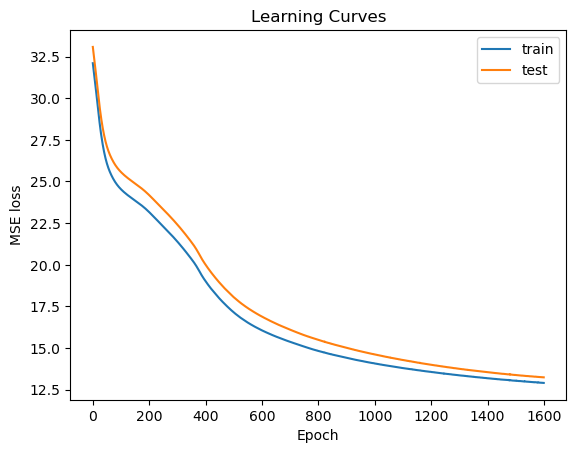

In [10]:
import matplotlib.pyplot as plt
# plot learning curves
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.plot((history.history['loss']), label='train')
plt.plot((history.history['val_loss']), label='test')
plt.legend()
plt.show()

### 6) Further training of the model and overfitting

The model can be further trained for even more Epochs, but it will be subject to overfitting. An overfitting model reproduces too closely the target variable in a specific training dataset, and may therefore fail to fit additional data or predict future observations reliably.  In other words, the model memorizes the training dataset too well, learning also the noise included, and it is not able to generalise any more. <br>The following code loads the model that has been trained in section 6 and trains it further for additional 1000 epochs, using the same training hyperparameters (learning rate, batch size, etc.).

In [11]:
# training phase with the training dataset
fine_tune_epochs = 1000
total_epochs =  epochs + fine_tune_epochs
def train_fine(model):

    optimizer = optimizers.Adam(lr=learning_rate1)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    history_fine = model.fit(
        X_train_scaled,
        y_train,
        batch_size=batch_size,
        epochs=total_epochs,
        initial_epoch=history.epoch[-1],
    # We also carry out some validation to
    # monitor loss and metrics on the test dataset
    # at the end of each epoch
        validation_data=(X_test_scaled, y_test),)
        #validation_data=(X_test, np.log10(y_test)),)
    model.save('./mlp_model_1.h5')
    return model, history_fine
new_model = tf.keras.models.load_model('./mlp_model.h5')

# for trainig with CPU (Slower) uncomment next line.
#model_fine, history_fine = train_fine(new_model)

# for trainig with GPU (Faster) uncomment next 2 lines. works in colab with GPU enabled
with tf.device("/device:GPU:0"):
    model_fine, history_fine = train_fine(new_model)


Epoch 1600/2600
4/4 [==============================] - 1s 120ms/step - loss: 12.9223 - mae: 1.4670 - val_loss: 13.2484 - val_mae: 1.4583
Epoch 1601/2600
4/4 [==============================] - 0s 71ms/step - loss: 12.9184 - mae: 1.4525 - val_loss: 13.2533 - val_mae: 1.4564
Epoch 1602/2600
4/4 [==============================] - 0s 83ms/step - loss: 12.9125 - mae: 1.4596 - val_loss: 13.2434 - val_mae: 1.4720
Epoch 1603/2600
4/4 [==============================] - 0s 79ms/step - loss: 12.9155 - mae: 1.4694 - val_loss: 13.2418 - val_mae: 1.4711
Epoch 1604/2600
4/4 [==============================] - 0s 79ms/step - loss: 12.9071 - mae: 1.4628 - val_loss: 13.2424 - val_mae: 1.4595
Epoch 1605/2600
4/4 [==============================] - 0s 69ms/step - loss: 12.9046 - mae: 1.4554 - val_loss: 13.2454 - val_mae: 1.4572
Epoch 1606/2600
4/4 [==============================] - 0s 75ms/step - loss: 12.9015 - mae: 1.4575 - val_loss: 13.2323 - val_mae: 1.4644
Epoch 1607/2600
4/4 [==========================

4/4 [==============================] - 0s 67ms/step - loss: 12.7338 - mae: 1.4642 - val_loss: 13.0453 - val_mae: 1.4620
Epoch 1721/2600
4/4 [==============================] - 0s 81ms/step - loss: 12.7279 - mae: 1.4571 - val_loss: 13.0542 - val_mae: 1.4542
Epoch 1722/2600
4/4 [==============================] - 0s 64ms/step - loss: 12.7280 - mae: 1.4525 - val_loss: 13.0524 - val_mae: 1.4540
Epoch 1723/2600
4/4 [==============================] - 0s 54ms/step - loss: 12.7292 - mae: 1.4535 - val_loss: 13.0499 - val_mae: 1.4558
Epoch 1724/2600
4/4 [==============================] - 0s 70ms/step - loss: 12.7265 - mae: 1.4568 - val_loss: 13.0438 - val_mae: 1.4609
Epoch 1725/2600
4/4 [==============================] - 0s 71ms/step - loss: 12.7254 - mae: 1.4581 - val_loss: 13.0447 - val_mae: 1.4580
Epoch 1726/2600
4/4 [==============================] - 0s 63ms/step - loss: 12.7228 - mae: 1.4558 - val_loss: 13.0467 - val_mae: 1.4572
Epoch 1727/2600
4/4 [==============================] - 0s 69ms/s

4/4 [==============================] - 0s 58ms/step - loss: 12.6062 - mae: 1.4606 - val_loss: 12.9227 - val_mae: 1.4588
Epoch 1841/2600
4/4 [==============================] - 0s 51ms/step - loss: 12.5986 - mae: 1.4557 - val_loss: 12.9279 - val_mae: 1.4530
Epoch 1842/2600
4/4 [==============================] - 0s 73ms/step - loss: 12.6031 - mae: 1.4500 - val_loss: 12.9314 - val_mae: 1.4505
Epoch 1843/2600
4/4 [==============================] - 0s 68ms/step - loss: 12.6029 - mae: 1.4496 - val_loss: 12.9237 - val_mae: 1.4538
Epoch 1844/2600
4/4 [==============================] - 0s 61ms/step - loss: 12.5958 - mae: 1.4535 - val_loss: 12.9167 - val_mae: 1.4577
Epoch 1845/2600
4/4 [==============================] - 0s 63ms/step - loss: 12.6284 - mae: 1.4638 - val_loss: 12.9170 - val_mae: 1.4665
Epoch 1846/2600
4/4 [==============================] - 0s 77ms/step - loss: 12.5975 - mae: 1.4617 - val_loss: 12.9160 - val_mae: 1.4542
Epoch 1847/2600
4/4 [==============================] - 0s 73ms/s

4/4 [==============================] - 0s 73ms/step - loss: 12.5043 - mae: 1.4516 - val_loss: 12.8328 - val_mae: 1.4508
Epoch 1961/2600
4/4 [==============================] - 0s 68ms/step - loss: 12.5066 - mae: 1.4490 - val_loss: 12.8339 - val_mae: 1.4510
Epoch 1962/2600
4/4 [==============================] - 0s 68ms/step - loss: 12.5004 - mae: 1.4505 - val_loss: 12.8299 - val_mae: 1.4545
Epoch 1963/2600
4/4 [==============================] - 0s 67ms/step - loss: 12.5033 - mae: 1.4550 - val_loss: 12.8244 - val_mae: 1.4592
Epoch 1964/2600
4/4 [==============================] - 0s 78ms/step - loss: 12.5034 - mae: 1.4553 - val_loss: 12.8261 - val_mae: 1.4530
Epoch 1965/2600
4/4 [==============================] - 0s 51ms/step - loss: 12.4995 - mae: 1.4514 - val_loss: 12.8251 - val_mae: 1.4513
Epoch 1966/2600
4/4 [==============================] - 0s 62ms/step - loss: 12.5001 - mae: 1.4492 - val_loss: 12.8320 - val_mae: 1.4476
Epoch 1967/2600
4/4 [==============================] - 0s 74ms/s

4/4 [==============================] - 0s 59ms/step - loss: 12.4277 - mae: 1.4462 - val_loss: 12.7603 - val_mae: 1.4466
Epoch 2081/2600
4/4 [==============================] - 0s 79ms/step - loss: 12.4257 - mae: 1.4467 - val_loss: 12.7517 - val_mae: 1.4510
Epoch 2082/2600
4/4 [==============================] - 0s 50ms/step - loss: 12.4246 - mae: 1.4498 - val_loss: 12.7523 - val_mae: 1.4517
Epoch 2083/2600
4/4 [==============================] - 0s 68ms/step - loss: 12.4286 - mae: 1.4489 - val_loss: 12.7576 - val_mae: 1.4484
Epoch 2084/2600
4/4 [==============================] - 0s 79ms/step - loss: 12.4242 - mae: 1.4488 - val_loss: 12.7460 - val_mae: 1.4526
Epoch 2085/2600
4/4 [==============================] - 0s 85ms/step - loss: 12.4267 - mae: 1.4529 - val_loss: 12.7411 - val_mae: 1.4538
Epoch 2086/2600
4/4 [==============================] - 0s 70ms/step - loss: 12.4220 - mae: 1.4507 - val_loss: 12.7503 - val_mae: 1.4479
Epoch 2087/2600
4/4 [==============================] - 0s 88ms/s

4/4 [==============================] - 0s 69ms/step - loss: 12.3737 - mae: 1.4400 - val_loss: 12.7102 - val_mae: 1.4427
Epoch 2201/2600
4/4 [==============================] - 0s 60ms/step - loss: 12.3599 - mae: 1.4448 - val_loss: 12.6852 - val_mae: 1.4527
Epoch 2202/2600
4/4 [==============================] - 0s 66ms/step - loss: 12.3693 - mae: 1.4531 - val_loss: 12.6794 - val_mae: 1.4559
Epoch 2203/2600
4/4 [==============================] - 0s 65ms/step - loss: 12.3685 - mae: 1.4520 - val_loss: 12.6896 - val_mae: 1.4472
Epoch 2204/2600
4/4 [==============================] - 0s 68ms/step - loss: 12.3615 - mae: 1.4453 - val_loss: 12.6931 - val_mae: 1.4447
Epoch 2205/2600
4/4 [==============================] - 0s 79ms/step - loss: 12.3639 - mae: 1.4429 - val_loss: 12.6979 - val_mae: 1.4434
Epoch 2206/2600
4/4 [==============================] - 0s 54ms/step - loss: 12.3580 - mae: 1.4430 - val_loss: 12.6848 - val_mae: 1.4474
Epoch 2207/2600
4/4 [==============================] - 0s 78ms/s

4/4 [==============================] - 0s 58ms/step - loss: 12.3132 - mae: 1.4407 - val_loss: 12.6488 - val_mae: 1.4445
Epoch 2321/2600
4/4 [==============================] - 0s 74ms/step - loss: 12.3080 - mae: 1.4436 - val_loss: 12.6480 - val_mae: 1.4455
Epoch 2322/2600
4/4 [==============================] - 0s 107ms/step - loss: 12.3097 - mae: 1.4418 - val_loss: 12.6571 - val_mae: 1.4433
Epoch 2323/2600
4/4 [==============================] - 0s 89ms/step - loss: 12.3063 - mae: 1.4417 - val_loss: 12.6521 - val_mae: 1.4451
Epoch 2324/2600
4/4 [==============================] - 0s 77ms/step - loss: 12.3075 - mae: 1.4461 - val_loss: 12.6398 - val_mae: 1.4504
Epoch 2325/2600
4/4 [==============================] - 0s 81ms/step - loss: 12.3132 - mae: 1.4498 - val_loss: 12.6389 - val_mae: 1.4501
Epoch 2326/2600
4/4 [==============================] - 0s 73ms/step - loss: 12.3112 - mae: 1.4433 - val_loss: 12.6656 - val_mae: 1.4396
Epoch 2327/2600
4/4 [==============================] - 0s 79ms/

4/4 [==============================] - 0s 52ms/step - loss: 12.2640 - mae: 1.4454 - val_loss: 12.6099 - val_mae: 1.4450
Epoch 2441/2600
4/4 [==============================] - 0s 60ms/step - loss: 12.2610 - mae: 1.4411 - val_loss: 12.6236 - val_mae: 1.4408
Epoch 2442/2600
4/4 [==============================] - 0s 57ms/step - loss: 12.2590 - mae: 1.4388 - val_loss: 12.6176 - val_mae: 1.4427
Epoch 2443/2600
4/4 [==============================] - 0s 78ms/step - loss: 12.2580 - mae: 1.4420 - val_loss: 12.6077 - val_mae: 1.4470
Epoch 2444/2600
4/4 [==============================] - 0s 74ms/step - loss: 12.2637 - mae: 1.4462 - val_loss: 12.6040 - val_mae: 1.4474
Epoch 2445/2600
4/4 [==============================] - 0s 55ms/step - loss: 12.2713 - mae: 1.4404 - val_loss: 12.6339 - val_mae: 1.4384
Epoch 2446/2600
4/4 [==============================] - 0s 56ms/step - loss: 12.2618 - mae: 1.4364 - val_loss: 12.6209 - val_mae: 1.4418
Epoch 2447/2600
4/4 [==============================] - 0s 61ms/s

4/4 [==============================] - 0s 65ms/step - loss: 12.2307 - mae: 1.4370 - val_loss: 12.5944 - val_mae: 1.4408
Epoch 2561/2600
4/4 [==============================] - 0s 68ms/step - loss: 12.2242 - mae: 1.4400 - val_loss: 12.5844 - val_mae: 1.4464
Epoch 2562/2600
4/4 [==============================] - 0s 69ms/step - loss: 12.2253 - mae: 1.4439 - val_loss: 12.5862 - val_mae: 1.4439
Epoch 2563/2600
4/4 [==============================] - 0s 52ms/step - loss: 12.2202 - mae: 1.4396 - val_loss: 12.5987 - val_mae: 1.4396
Epoch 2564/2600
4/4 [==============================] - 0s 63ms/step - loss: 12.2250 - mae: 1.4354 - val_loss: 12.6067 - val_mae: 1.4383
Epoch 2565/2600
4/4 [==============================] - 0s 72ms/step - loss: 12.2210 - mae: 1.4377 - val_loss: 12.5864 - val_mae: 1.4441
Epoch 2566/2600
4/4 [==============================] - 0s 61ms/step - loss: 12.2262 - mae: 1.4446 - val_loss: 12.5797 - val_mae: 1.4474
Epoch 2567/2600
4/4 [==============================] - 0s 61ms/s

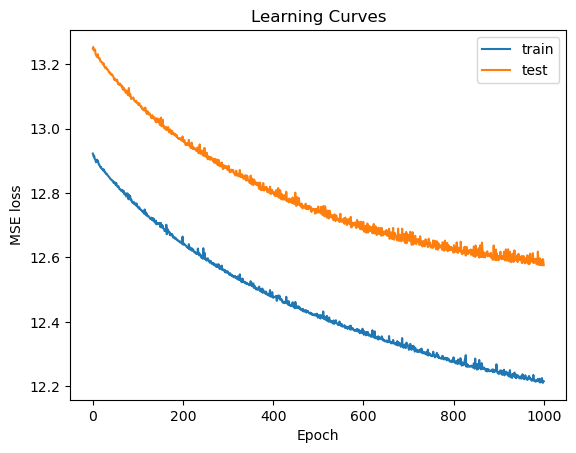

In [12]:
# plot learning curves
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.plot((history_fine.history['loss']), label='train')
plt.plot((history_fine.history['val_loss']), label='test')
plt.legend()
plt.show()

Overfitting can be observed as the training loss continues to decrease with the Epochs, improving the accuracy, while the test loss shows a slower decrease. With more training epochs the test loss should reach an asymptotic value and not decrease anymore. 

### 7) Testing the trained model on the initial case study

The trained model is now applied to a real case study, the GMI overpass of Medicane Ianos on 16/09/2020 seen before, and the reult will be compared with the surface precipitation estimates provided by the NASA Goddard Profiling Algorithm, the official GPM preciptiation product for the GMI radiometer. Some details on the GPROF algorithm can be found in <a href="https://gpm.nasa.gov/resources/documents/gpm-gprof-algorithm-theoretical-basis-document-atbd/">GPM GPROF Algorithm Theoretical Basis Document (ATBD)  </a>.


In [13]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap 
from mpl_toolkits.basemap import Basemap
import numpy as np
import h5py
import warnings

# defining the function to plot
def plot_rr_map(RR,lat,lon,colorAxisMin,colorAxisMax):
    # set the lat/lon borders of the map
    latborders=[34,40]
    lonborders=[14,22]
    m = Basemap(projection='merc',
        resolution='l',
        lat_ts=20,
        llcrnrlat=latborders[0],urcrnrlat=latborders[1],\
        llcrnrlon=lonborders[0],urcrnrlon=lonborders[1])

    
#E set min/max values of the colorbar
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        im1 = m.pcolor(lon[:],lat[:],RR[:],shading='nearest',cmap='turbo',latlon=True,vmin=colorAxisMin,vmax=colorAxisMax)
    m.drawcoastlines()
# set parallels and meridians

    dparal=2 #separation in deg between drawn parallels
    parallels = np.arange(latborders[0],latborders[1],dparal)
    dmerid=2 #separation in deg between drawn meridians
    meridians = np.arange(lonborders[0],lonborders[1],dmerid)
    m.drawparallels(parallels,labels=[1,0,0,0],fontsize=15)
    m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=15) 
# add colorbar.
    cbar = m.colorbar(location='right',pad="5%")
    cbar.set_label('Rainfall Rate [mm/h]')
    
gmi_file_path='./1C-R.GPM.GMI.XCAL2016-C.20200916-S130832-E144106.037225.V07A.HDF5'
hf=h5py.File(gmi_file_path,'r')
lat1=hf['S1/Latitude'][:]
lon1=hf['S1/Longitude'][:]
TB1=hf['S1/Tc'][:]
TB2=hf['S2/Tc'][:]
hf.close()

TB=np.concatenate((TB1,TB2,),axis=2)
TB=np.reshape(TB,(2963*221,13))
TB[np.any(TB<=0,axis=1),:]=np.NaN
TB = scaler.transform(TB)
predictions = model.predict(TB)
predictions = np.reshape(predictions,(2963,221))


gprof_file_path='./2A.GPM.GMI.GPROF2021v1.20200916-S130832-E144106.037225.V07A.HDF5'
hf=h5py.File(gprof_file_path,'r')
lat2=hf['S1/Latitude'][:]
lon2=hf['S1/Longitude'][:]
gprof_rr=hf['S1/surfacePrecipitation'][:]
hf.close()

20464/20464 [==============================] - 72s 4ms/step


Text(0.5, 1.0, 'GPROF')

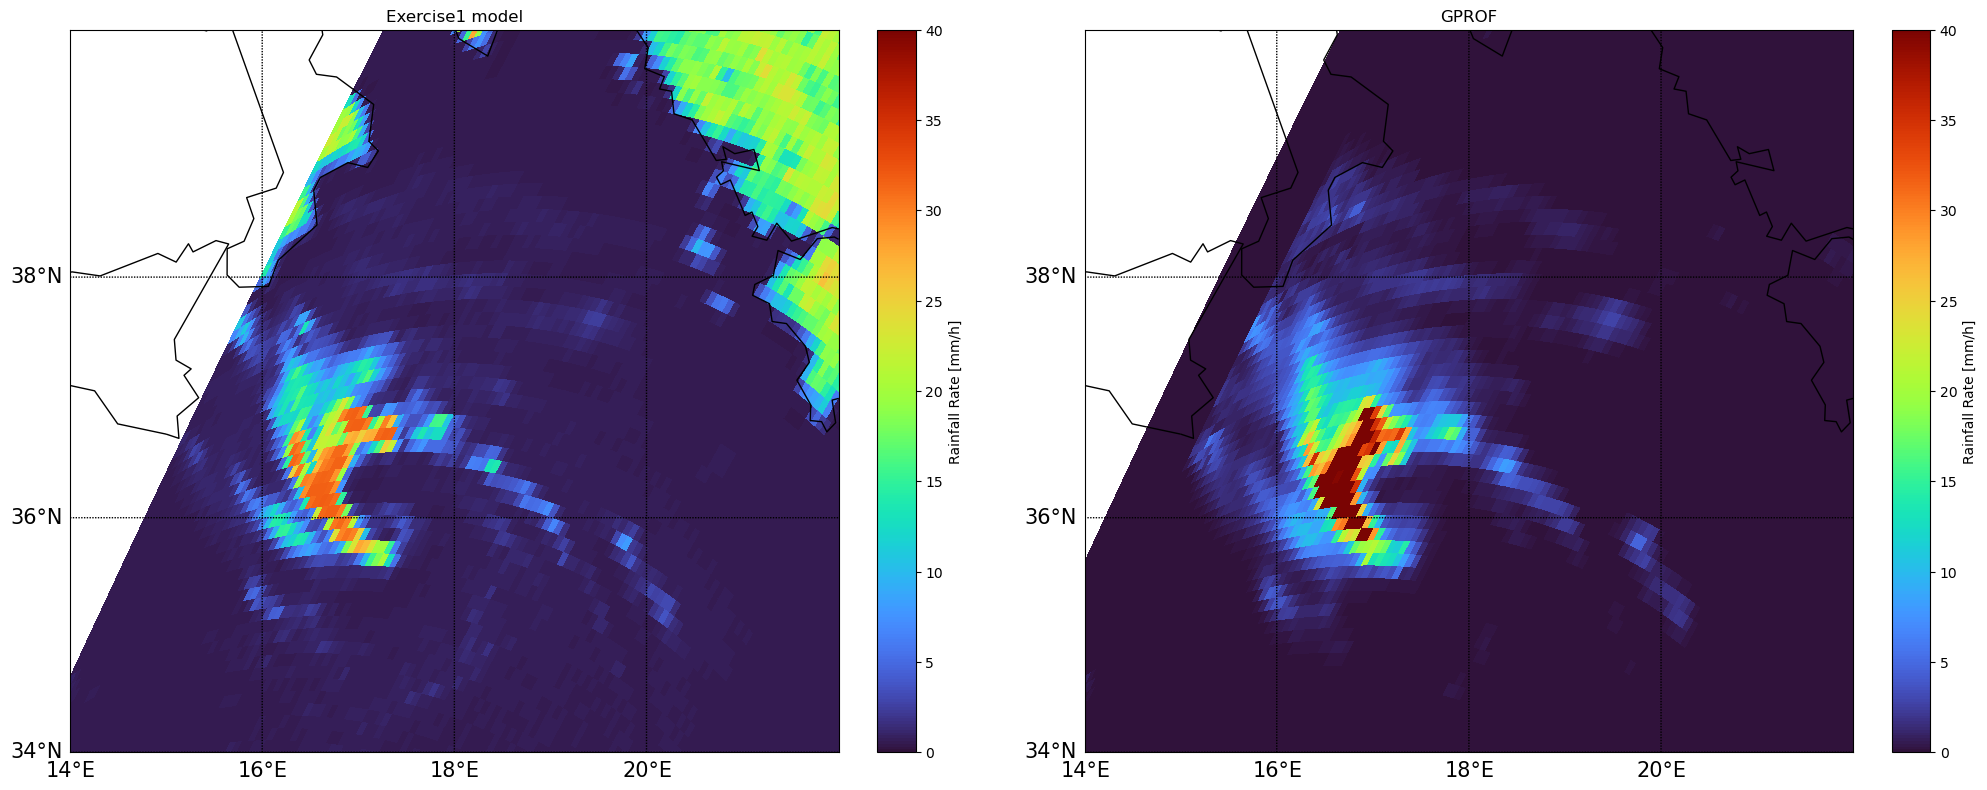

In [14]:

fig = plt.figure(figsize=(24,16))
ax = fig.add_subplot(121)
plot_rr_map(predictions,lat1,lon1,0,40)
plt.title('Exercise1 model',fontsize=12)
ax = fig.add_subplot(122)
plot_rr_map(gprof_rr,lat2,lon2,0,40)
plt.title('GPROF',fontsize=12)

The result obtained by our NN model seems quite acceptable, the rainfall patterns predicted by our model are quite similar to those of GPROF, which is based on a physically-based Bayesian approach and is a very complex algorithm. It is important to highlight that:
 1. The GMI observation of Madicane Ianos is not included in the training dataset (training dataset is built from 10 orbits of March 2014, while Medicane Ianos occured on 16/09/2020).
 2. The NN model precipitation rate estimates over land and coastal areas are not reliable, as the training dataset does not include measurements over land (the precipitation retrieval over land is much more complex than over ocean and it has not been address in this exercise).
 3. The high rainfall rates are underestimated, probably due to the small size of the training dataset, since intense rainfall is rare and probably it is not well represented in our limited-size training dataset.
 4. Very low precipitation rates are present also in areas where the GPROF algorithm does not predict any precipitation, since the training dataset includes only pixels with precipitation (rainfall rate > 0 mm/h), and it has not learned how to disciminate between rain and no-rain pixels (precipitation detection is often handled using a different ML approach).
 5. Remember that the trainig dataset is very small (10 orbits over ocean only) and the NN model obtained with this exercise is not suitable for operational or scientific purposes.

# Additional Exercises <a class="anchor" id="additional-exercises"></a>

Using the following code try to train the model differently. In particular:

1. try to modify the learning rate and the epoch number (try learning rates 0.01, 0.002, 0.0005 0.0001)
2. modify the model architecture, varying the number of perceptrons in each hidden layer (40/10, 20/30)
3. try to remove one or more input GMI channels (e.g. the first two at 10 GHz which are more directly impacted by surface precipitation)

In [15]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras import utils
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import xarray as xr

import warnings
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


def load_dataset():
    warnings.filterwarnings("ignore")
    data_path = './dataset2_GMI_DPR_RR.nc'
    ds = xr.open_dataset(data_path)
    train_df = ds['tb'].to_dataframe().unstack()
    target = ds['rr'].to_dataframe()
    tensor_df = tf.convert_to_tensor(train_df, dtype=np.float)
    label_df = tf.convert_to_tensor(target, dtype=np.float)
    return tensor_df,label_df

def split_dataset(dataset, label_dataset):
    #split = round(test_split* len(tensor_df))
    choice=np.mod(range(0,len(tensor_df)),2)==0
    X_train = dataset[choice==0]
    X_test = dataset[choice]
    y_train = label_dataset[choice==0]
    y_test = label_dataset[choice]   
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_dataset(tensor_df, label_df)

# Scaling: Standardize features by removing the mean and scaling to unit variance.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) #mean and variance are calculated on the training dataset and applied to the training dataset
X_test_scaled = scaler.transform(X_test)       #mean and variance (previously calculated) are applied to the test dataset

# Set the input shape
input_shape = X_train.shape[1]


def train(learning_rate1, num_percept_layer1, num_percept_layer2):
    # here the network achitecture is defined: here it is a feed forward neural network with 2 hidden layers, 
    # Sigmoids are used as transfer function in both hidden layers.
    model = Sequential()
    model.add(Dense(num_percept_layer1, input_dim=input_shape, kernel_initializer='normal', activation='sigmoid'))
    model.add(Dense(num_percept_layer2, kernel_initializer='normal', activation='sigmoid')) ###second hidden
    model.add(Dense(1, kernel_initializer='normal', activation='linear')) #output
    model.summary()
    #the optimizer is the algorithm used for the training. Adam is a standard choice, Scale conjugate gradient (SGD), is also very efficient.
    optimizer = optimizers.Adam(lr=learning_rate1)
    #optimizer = optimizers.experimental.SGD( learning_rate=learning_rate1)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae']) # the loss function to be minimized during training is the mean squared error (MSE)
    history = model.fit(
        X_train_scaled,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
    # We also carry out some validation to
    # monitor loss and metrics on the test dataset
    # at the end of each epoch
        validation_data=(X_test_scaled, y_test),)
        #validation_data=(X_test, np.log10(y_test)),)
    return model, history


verbose = 1

# My exploration of the exercises <a class="anchor" id="exploration-exercises"></a>

Below is my code to explore around the above proposals for the exercises.

Let us begin by defining a function wrapping all the training. We will tune separately the learning rate and the number of perceptrons.

## Tuning the learning rate

The learning rate was taken to be 0.001 in the begining of the notebook. We now look for a better one.

In [16]:
def tuning_lr(learning_rates, num_percept_layer1, num_percept_layer2):
    
    # setting the subplots figure
    fig, axs = plt.subplots(4, sharex=True)
    fig.suptitle('Learning_curves')
    fig.set_figheight(20)
    fig.set_figwidth(15)

    for i in range(len(learning_rates)):
    
        learning_rate1=learning_rates[i]
    
        model, history = train(learning_rate1, num_percept_layer1, num_percept_layer2)

        model.save('./exer2_model.h5')

        # plot learning curves
        axs[i].set_title('Learning curves with learning rate = '+str(learning_rate1))
        axs[i].set_xlabel('Epoch')
        axs[i].set_ylabel('MSE loss')
        axs[i].plot((history.history['loss']), label='train')
        axs[i].plot((history.history['val_loss']), label='test')
        axs[i].legend()
    
    plt.show()


Begin first with the traning rate values proposed above (if needed, please scroll down the ouput cell to view the plots):

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 20)                280       
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1600
4/4 [==============================] - 1s 151ms/step - loss: 32.5806 - mae: 2.5601 - val_loss: 32.7711 - val_mae: 2.3866
Epoch 2/1600
4/4 [==============================] - 0s 81ms/step - loss: 31.2476 - mae: 2.2936 - val_loss: 31.5469 - val_mae: 2.1556
Epoch 3/1600
4/4 [==============================] - 0

4/4 [==============================] - 0s 56ms/step - loss: 14.6822 - mae: 1.5426 - val_loss: 15.2904 - val_mae: 1.5443
Epoch 118/1600
4/4 [==============================] - 0s 46ms/step - loss: 14.6576 - mae: 1.5301 - val_loss: 15.2881 - val_mae: 1.5541
Epoch 119/1600
4/4 [==============================] - 0s 54ms/step - loss: 14.6540 - mae: 1.5430 - val_loss: 15.2517 - val_mae: 1.5183
Epoch 120/1600
4/4 [==============================] - 0s 53ms/step - loss: 14.6447 - mae: 1.5057 - val_loss: 15.3101 - val_mae: 1.5622
Epoch 121/1600
4/4 [==============================] - 0s 64ms/step - loss: 14.6366 - mae: 1.5479 - val_loss: 15.2385 - val_mae: 1.5169
Epoch 122/1600
4/4 [==============================] - 0s 55ms/step - loss: 14.6204 - mae: 1.5131 - val_loss: 15.2626 - val_mae: 1.5759
Epoch 123/1600
4/4 [==============================] - 0s 76ms/step - loss: 14.6065 - mae: 1.5610 - val_loss: 15.1539 - val_mae: 1.5204
Epoch 124/1600
4/4 [==============================] - 0s 73ms/step - l

Epoch 178/1600
4/4 [==============================] - 0s 69ms/step - loss: 13.7224 - mae: 1.4925 - val_loss: 14.2037 - val_mae: 1.5274
Epoch 179/1600
4/4 [==============================] - 0s 70ms/step - loss: 13.7080 - mae: 1.5100 - val_loss: 14.1768 - val_mae: 1.4806
Epoch 180/1600
4/4 [==============================] - 0s 63ms/step - loss: 13.7321 - mae: 1.4828 - val_loss: 14.2119 - val_mae: 1.5059
Epoch 181/1600
4/4 [==============================] - 0s 68ms/step - loss: 13.6703 - mae: 1.4928 - val_loss: 14.2375 - val_mae: 1.4712
Epoch 182/1600
4/4 [==============================] - 0s 63ms/step - loss: 13.7660 - mae: 1.4753 - val_loss: 14.3328 - val_mae: 1.5658
Epoch 183/1600
4/4 [==============================] - 0s 59ms/step - loss: 13.8340 - mae: 1.5440 - val_loss: 14.2662 - val_mae: 1.4669
Epoch 184/1600
4/4 [==============================] - 0s 64ms/step - loss: 13.8048 - mae: 1.4687 - val_loss: 14.3121 - val_mae: 1.5443
Epoch 185/1600
4/4 [==============================] - 0

Epoch 299/1600
4/4 [==============================] - 0s 82ms/step - loss: 13.0248 - mae: 1.4565 - val_loss: 13.2467 - val_mae: 1.4775
Epoch 300/1600
4/4 [==============================] - 0s 91ms/step - loss: 12.9594 - mae: 1.4735 - val_loss: 13.2166 - val_mae: 1.4635
Epoch 301/1600
4/4 [==============================] - 0s 86ms/step - loss: 12.9453 - mae: 1.4575 - val_loss: 13.2507 - val_mae: 1.4610
Epoch 302/1600
4/4 [==============================] - 0s 85ms/step - loss: 12.9807 - mae: 1.4801 - val_loss: 13.2444 - val_mae: 1.4703
Epoch 303/1600
4/4 [==============================] - 0s 72ms/step - loss: 12.9957 - mae: 1.4598 - val_loss: 13.2509 - val_mae: 1.4955
Epoch 304/1600
4/4 [==============================] - 0s 83ms/step - loss: 13.0131 - mae: 1.4994 - val_loss: 13.2555 - val_mae: 1.4530
Epoch 305/1600
4/4 [==============================] - 0s 69ms/step - loss: 12.9595 - mae: 1.4444 - val_loss: 13.2140 - val_mae: 1.4727
Epoch 306/1600
4/4 [==============================] - 0

Epoch 420/1600
4/4 [==============================] - 0s 91ms/step - loss: 12.6047 - mae: 1.4503 - val_loss: 13.0117 - val_mae: 1.4448
Epoch 421/1600
4/4 [==============================] - 0s 74ms/step - loss: 12.6063 - mae: 1.4478 - val_loss: 12.9545 - val_mae: 1.4832
Epoch 422/1600
4/4 [==============================] - 0s 75ms/step - loss: 12.6149 - mae: 1.4819 - val_loss: 12.9689 - val_mae: 1.4643
Epoch 423/1600
4/4 [==============================] - 0s 59ms/step - loss: 12.5982 - mae: 1.4550 - val_loss: 12.9450 - val_mae: 1.4636
Epoch 424/1600
4/4 [==============================] - 0s 56ms/step - loss: 12.6882 - mae: 1.4659 - val_loss: 13.0339 - val_mae: 1.4443
Epoch 425/1600
4/4 [==============================] - 0s 89ms/step - loss: 12.6157 - mae: 1.4581 - val_loss: 12.9284 - val_mae: 1.4728
Epoch 426/1600
4/4 [==============================] - 0s 76ms/step - loss: 12.6156 - mae: 1.4598 - val_loss: 12.9844 - val_mae: 1.4563
Epoch 427/1600
4/4 [==============================] - 0

Epoch 481/1600
4/4 [==============================] - 0s 72ms/step - loss: 12.5859 - mae: 1.4654 - val_loss: 12.8637 - val_mae: 1.4882
Epoch 482/1600
4/4 [==============================] - 0s 69ms/step - loss: 12.5092 - mae: 1.4597 - val_loss: 12.9662 - val_mae: 1.4405
Epoch 483/1600
4/4 [==============================] - 0s 88ms/step - loss: 12.5052 - mae: 1.4526 - val_loss: 12.8549 - val_mae: 1.4784
Epoch 484/1600
4/4 [==============================] - 0s 94ms/step - loss: 12.4824 - mae: 1.4611 - val_loss: 12.9173 - val_mae: 1.4416
Epoch 485/1600
4/4 [==============================] - 0s 89ms/step - loss: 12.5096 - mae: 1.4414 - val_loss: 12.8529 - val_mae: 1.4815
Epoch 486/1600
4/4 [==============================] - 0s 77ms/step - loss: 12.5971 - mae: 1.4850 - val_loss: 12.9490 - val_mae: 1.4505
Epoch 487/1600
4/4 [==============================] - 0s 89ms/step - loss: 12.5816 - mae: 1.4486 - val_loss: 12.8541 - val_mae: 1.4745
Epoch 488/1600
4/4 [==============================] - 0

Epoch 542/1600
4/4 [==============================] - 0s 73ms/step - loss: 12.4688 - mae: 1.4678 - val_loss: 12.8306 - val_mae: 1.4431
Epoch 543/1600
4/4 [==============================] - 0s 75ms/step - loss: 12.4893 - mae: 1.4330 - val_loss: 12.7830 - val_mae: 1.4692
Epoch 544/1600
4/4 [==============================] - 0s 72ms/step - loss: 12.4885 - mae: 1.4862 - val_loss: 12.8282 - val_mae: 1.4614
Epoch 545/1600
4/4 [==============================] - 0s 79ms/step - loss: 12.5227 - mae: 1.4415 - val_loss: 12.7959 - val_mae: 1.4655
Epoch 546/1600
4/4 [==============================] - 0s 76ms/step - loss: 12.4768 - mae: 1.4767 - val_loss: 12.7995 - val_mae: 1.4489
Epoch 547/1600
4/4 [==============================] - 0s 70ms/step - loss: 12.4528 - mae: 1.4351 - val_loss: 12.7775 - val_mae: 1.4587
Epoch 548/1600
4/4 [==============================] - 0s 82ms/step - loss: 12.4109 - mae: 1.4627 - val_loss: 12.7911 - val_mae: 1.4664
Epoch 549/1600
4/4 [==============================] - 0

Epoch 663/1600
4/4 [==============================] - 0s 85ms/step - loss: 12.3283 - mae: 1.4741 - val_loss: 12.7493 - val_mae: 1.4621
Epoch 664/1600
4/4 [==============================] - 0s 89ms/step - loss: 12.3424 - mae: 1.4446 - val_loss: 12.7038 - val_mae: 1.4580
Epoch 665/1600
4/4 [==============================] - 0s 94ms/step - loss: 12.3074 - mae: 1.4577 - val_loss: 12.7305 - val_mae: 1.4519
Epoch 666/1600
4/4 [==============================] - 0s 71ms/step - loss: 12.2961 - mae: 1.4491 - val_loss: 12.7461 - val_mae: 1.4499
Epoch 667/1600
4/4 [==============================] - 0s 70ms/step - loss: 12.3238 - mae: 1.4395 - val_loss: 12.7469 - val_mae: 1.4635
Epoch 668/1600
4/4 [==============================] - 0s 70ms/step - loss: 12.3076 - mae: 1.4697 - val_loss: 12.7300 - val_mae: 1.4571
Epoch 669/1600
4/4 [==============================] - 0s 63ms/step - loss: 12.3004 - mae: 1.4406 - val_loss: 12.7444 - val_mae: 1.4462
Epoch 670/1600
4/4 [==============================] - 0

Epoch 784/1600
4/4 [==============================] - 0s 81ms/step - loss: 12.2563 - mae: 1.4376 - val_loss: 12.7229 - val_mae: 1.4741
Epoch 785/1600
4/4 [==============================] - 0s 75ms/step - loss: 12.2944 - mae: 1.4772 - val_loss: 12.8148 - val_mae: 1.4394
Epoch 786/1600
4/4 [==============================] - 0s 101ms/step - loss: 12.3134 - mae: 1.4314 - val_loss: 12.6792 - val_mae: 1.4625
Epoch 787/1600
4/4 [==============================] - 0s 85ms/step - loss: 12.2361 - mae: 1.4661 - val_loss: 12.7486 - val_mae: 1.4461
Epoch 788/1600
4/4 [==============================] - 0s 101ms/step - loss: 12.2915 - mae: 1.4348 - val_loss: 12.7196 - val_mae: 1.4639
Epoch 789/1600
4/4 [==============================] - 0s 88ms/step - loss: 12.2619 - mae: 1.4646 - val_loss: 12.7268 - val_mae: 1.4548
Epoch 790/1600
4/4 [==============================] - 0s 82ms/step - loss: 12.1819 - mae: 1.4510 - val_loss: 12.7004 - val_mae: 1.4514
Epoch 791/1600
4/4 [==============================] -

Epoch 905/1600
4/4 [==============================] - 0s 65ms/step - loss: 12.0914 - mae: 1.4468 - val_loss: 12.6993 - val_mae: 1.4403
Epoch 906/1600
4/4 [==============================] - 0s 74ms/step - loss: 12.0815 - mae: 1.4339 - val_loss: 12.6551 - val_mae: 1.4578
Epoch 907/1600
4/4 [==============================] - 0s 78ms/step - loss: 12.1166 - mae: 1.4542 - val_loss: 12.7161 - val_mae: 1.4493
Epoch 908/1600
4/4 [==============================] - 0s 52ms/step - loss: 12.0776 - mae: 1.4425 - val_loss: 12.6636 - val_mae: 1.4577
Epoch 909/1600
4/4 [==============================] - 0s 66ms/step - loss: 12.1099 - mae: 1.4495 - val_loss: 12.7270 - val_mae: 1.4392
Epoch 910/1600
4/4 [==============================] - 0s 65ms/step - loss: 12.1022 - mae: 1.4400 - val_loss: 12.6671 - val_mae: 1.4674
Epoch 911/1600
4/4 [==============================] - 0s 51ms/step - loss: 12.1537 - mae: 1.4662 - val_loss: 12.7452 - val_mae: 1.4429
Epoch 912/1600
4/4 [==============================] - 0

Epoch 966/1600
4/4 [==============================] - 0s 74ms/step - loss: 12.0723 - mae: 1.4258 - val_loss: 12.7070 - val_mae: 1.4457
Epoch 967/1600
4/4 [==============================] - 0s 68ms/step - loss: 12.1215 - mae: 1.4593 - val_loss: 12.6543 - val_mae: 1.4599
Epoch 968/1600
4/4 [==============================] - 0s 71ms/step - loss: 12.0414 - mae: 1.4336 - val_loss: 12.7578 - val_mae: 1.4332
Epoch 969/1600
4/4 [==============================] - 0s 73ms/step - loss: 12.2197 - mae: 1.4586 - val_loss: 12.7217 - val_mae: 1.4557
Epoch 970/1600
4/4 [==============================] - 0s 85ms/step - loss: 12.2184 - mae: 1.4322 - val_loss: 12.7233 - val_mae: 1.4620
Epoch 971/1600
4/4 [==============================] - 0s 79ms/step - loss: 12.2129 - mae: 1.4798 - val_loss: 12.6560 - val_mae: 1.4507
Epoch 972/1600
4/4 [==============================] - 0s 61ms/step - loss: 12.1656 - mae: 1.4285 - val_loss: 12.6815 - val_mae: 1.4438
Epoch 973/1600
4/4 [==============================] - 0

4/4 [==============================] - 0s 97ms/step - loss: 11.9769 - mae: 1.4557 - val_loss: 12.6595 - val_mae: 1.4663
Epoch 1087/1600
4/4 [==============================] - 0s 94ms/step - loss: 11.9487 - mae: 1.4397 - val_loss: 12.7009 - val_mae: 1.4376
Epoch 1088/1600
4/4 [==============================] - 0s 84ms/step - loss: 11.9610 - mae: 1.4395 - val_loss: 12.6532 - val_mae: 1.4493
Epoch 1089/1600
4/4 [==============================] - 0s 99ms/step - loss: 11.9788 - mae: 1.4285 - val_loss: 12.7115 - val_mae: 1.4444
Epoch 1090/1600
4/4 [==============================] - 0s 91ms/step - loss: 11.8922 - mae: 1.4487 - val_loss: 12.6663 - val_mae: 1.4816
Epoch 1091/1600
4/4 [==============================] - 0s 80ms/step - loss: 11.9735 - mae: 1.4644 - val_loss: 12.7695 - val_mae: 1.4301
Epoch 1092/1600
4/4 [==============================] - 0s 68ms/step - loss: 12.0762 - mae: 1.4193 - val_loss: 12.6422 - val_mae: 1.4614
Epoch 1093/1600
4/4 [==============================] - 0s 79ms/s

4/4 [==============================] - 0s 87ms/step - loss: 11.9038 - mae: 1.4502 - val_loss: 12.6900 - val_mae: 1.4291
Epoch 1207/1600
4/4 [==============================] - 0s 80ms/step - loss: 11.9130 - mae: 1.4221 - val_loss: 12.6441 - val_mae: 1.4634
Epoch 1208/1600
4/4 [==============================] - 0s 66ms/step - loss: 11.9303 - mae: 1.4649 - val_loss: 12.7330 - val_mae: 1.4412
Epoch 1209/1600
4/4 [==============================] - 0s 85ms/step - loss: 11.9277 - mae: 1.4268 - val_loss: 12.6537 - val_mae: 1.4528
Epoch 1210/1600
4/4 [==============================] - 0s 69ms/step - loss: 11.9395 - mae: 1.4566 - val_loss: 12.6861 - val_mae: 1.4352
Epoch 1211/1600
4/4 [==============================] - 0s 67ms/step - loss: 11.9343 - mae: 1.4164 - val_loss: 12.6767 - val_mae: 1.4424
Epoch 1212/1600
4/4 [==============================] - 0s 77ms/step - loss: 11.8734 - mae: 1.4555 - val_loss: 12.6202 - val_mae: 1.4639
Epoch 1213/1600
4/4 [==============================] - 0s 71ms/s

4/4 [==============================] - 0s 91ms/step - loss: 11.7858 - mae: 1.4507 - val_loss: 12.6488 - val_mae: 1.4432
Epoch 1327/1600
4/4 [==============================] - 0s 89ms/step - loss: 11.7727 - mae: 1.4282 - val_loss: 12.6100 - val_mae: 1.4491
Epoch 1328/1600
4/4 [==============================] - 0s 59ms/step - loss: 11.8238 - mae: 1.4481 - val_loss: 12.6086 - val_mae: 1.4405
Epoch 1329/1600
4/4 [==============================] - 0s 78ms/step - loss: 11.7658 - mae: 1.4164 - val_loss: 12.6459 - val_mae: 1.4405
Epoch 1330/1600
4/4 [==============================] - 0s 69ms/step - loss: 11.7716 - mae: 1.4518 - val_loss: 12.5920 - val_mae: 1.4601
Epoch 1331/1600
4/4 [==============================] - 0s 80ms/step - loss: 11.8449 - mae: 1.4286 - val_loss: 12.6080 - val_mae: 1.4373
Epoch 1332/1600
4/4 [==============================] - 0s 57ms/step - loss: 11.7525 - mae: 1.4353 - val_loss: 12.5987 - val_mae: 1.4471
Epoch 1333/1600
4/4 [==============================] - 0s 69ms/s

4/4 [==============================] - 0s 75ms/step - loss: 11.5964 - mae: 1.4363 - val_loss: 12.5998 - val_mae: 1.4500
Epoch 1447/1600
4/4 [==============================] - 0s 64ms/step - loss: 11.6198 - mae: 1.4285 - val_loss: 12.6111 - val_mae: 1.4354
Epoch 1448/1600
4/4 [==============================] - 0s 54ms/step - loss: 11.6124 - mae: 1.4269 - val_loss: 12.5882 - val_mae: 1.4364
Epoch 1449/1600
4/4 [==============================] - 0s 78ms/step - loss: 11.5954 - mae: 1.4242 - val_loss: 12.5884 - val_mae: 1.4560
Epoch 1450/1600
4/4 [==============================] - 0s 70ms/step - loss: 11.5837 - mae: 1.4437 - val_loss: 12.5835 - val_mae: 1.4522
Epoch 1451/1600
4/4 [==============================] - 0s 83ms/step - loss: 11.5928 - mae: 1.4303 - val_loss: 12.6273 - val_mae: 1.4267
Epoch 1452/1600
4/4 [==============================] - 0s 75ms/step - loss: 11.6601 - mae: 1.4189 - val_loss: 12.6006 - val_mae: 1.4521
Epoch 1453/1600
4/4 [==============================] - 0s 63ms/s

4/4 [==============================] - 0s 72ms/step - loss: 11.5199 - mae: 1.4436 - val_loss: 12.6911 - val_mae: 1.4319
Epoch 1567/1600
4/4 [==============================] - 0s 75ms/step - loss: 11.5732 - mae: 1.4196 - val_loss: 12.5998 - val_mae: 1.4578
Epoch 1568/1600
4/4 [==============================] - 0s 61ms/step - loss: 11.5851 - mae: 1.4418 - val_loss: 12.6389 - val_mae: 1.4231
Epoch 1569/1600
4/4 [==============================] - 0s 77ms/step - loss: 11.7350 - mae: 1.4005 - val_loss: 12.6412 - val_mae: 1.4394
Epoch 1570/1600
4/4 [==============================] - 0s 91ms/step - loss: 11.5678 - mae: 1.4601 - val_loss: 12.6535 - val_mae: 1.4859
Epoch 1571/1600
4/4 [==============================] - 0s 78ms/step - loss: 11.5893 - mae: 1.4379 - val_loss: 12.7309 - val_mae: 1.4247
Epoch 1572/1600
4/4 [==============================] - 0s 82ms/step - loss: 11.4769 - mae: 1.4162 - val_loss: 12.8224 - val_mae: 1.4763
Epoch 1573/1600
4/4 [==============================] - 0s 65ms/s

Epoch 21/1600
4/4 [==============================] - 0s 63ms/step - loss: 26.4367 - mae: 1.9855 - val_loss: 27.3912 - val_mae: 2.0006
Epoch 22/1600
4/4 [==============================] - 0s 50ms/step - loss: 26.2769 - mae: 1.9992 - val_loss: 27.2403 - val_mae: 2.0153
Epoch 23/1600
4/4 [==============================] - 0s 64ms/step - loss: 26.1328 - mae: 2.0141 - val_loss: 27.1026 - val_mae: 2.0304
Epoch 24/1600
4/4 [==============================] - 0s 51ms/step - loss: 25.9994 - mae: 2.0288 - val_loss: 26.9777 - val_mae: 2.0455
Epoch 25/1600
4/4 [==============================] - 0s 77ms/step - loss: 25.8799 - mae: 2.0440 - val_loss: 26.8639 - val_mae: 2.0604
Epoch 26/1600
4/4 [==============================] - 0s 80ms/step - loss: 25.7711 - mae: 2.0590 - val_loss: 26.7601 - val_mae: 2.0746
Epoch 27/1600
4/4 [==============================] - 0s 53ms/step - loss: 25.6687 - mae: 2.0731 - val_loss: 26.6661 - val_mae: 2.0880
Epoch 28/1600
4/4 [==============================] - 0s 63ms/s

Epoch 143/1600
4/4 [==============================] - 0s 74ms/step - loss: 21.7449 - mae: 2.0467 - val_loss: 22.7547 - val_mae: 2.0515
Epoch 144/1600
4/4 [==============================] - 0s 86ms/step - loss: 21.7057 - mae: 2.0424 - val_loss: 22.7162 - val_mae: 2.0472
Epoch 145/1600
4/4 [==============================] - 0s 71ms/step - loss: 21.6687 - mae: 2.0388 - val_loss: 22.6766 - val_mae: 2.0442
Epoch 146/1600
4/4 [==============================] - 0s 64ms/step - loss: 21.6277 - mae: 2.0346 - val_loss: 22.6376 - val_mae: 2.0394
Epoch 147/1600
4/4 [==============================] - 0s 60ms/step - loss: 21.5888 - mae: 2.0297 - val_loss: 22.5979 - val_mae: 2.0353
Epoch 148/1600
4/4 [==============================] - 0s 71ms/step - loss: 21.5489 - mae: 2.0256 - val_loss: 22.5581 - val_mae: 2.0316
Epoch 149/1600
4/4 [==============================] - 0s 44ms/step - loss: 21.5095 - mae: 2.0219 - val_loss: 22.5175 - val_mae: 2.0282
Epoch 150/1600
4/4 [==============================] - 0

Epoch 204/1600
4/4 [==============================] - 0s 61ms/step - loss: 18.8886 - mae: 1.7085 - val_loss: 19.8610 - val_mae: 1.7228
Epoch 205/1600
4/4 [==============================] - 0s 71ms/step - loss: 18.8432 - mae: 1.7066 - val_loss: 19.8135 - val_mae: 1.7209
Epoch 206/1600
4/4 [==============================] - 0s 55ms/step - loss: 18.7968 - mae: 1.7029 - val_loss: 19.7652 - val_mae: 1.7155
Epoch 207/1600
4/4 [==============================] - 0s 61ms/step - loss: 18.7501 - mae: 1.6973 - val_loss: 19.7187 - val_mae: 1.7109
Epoch 208/1600
4/4 [==============================] - 0s 53ms/step - loss: 18.7048 - mae: 1.6933 - val_loss: 19.6716 - val_mae: 1.7084
Epoch 209/1600
4/4 [==============================] - 0s 66ms/step - loss: 18.6593 - mae: 1.6916 - val_loss: 19.6268 - val_mae: 1.7072
Epoch 210/1600
4/4 [==============================] - 0s 65ms/step - loss: 18.6164 - mae: 1.6904 - val_loss: 19.5806 - val_mae: 1.7043
Epoch 211/1600
4/4 [==============================] - 0

Epoch 265/1600
4/4 [==============================] - 0s 29ms/step - loss: 16.8404 - mae: 1.5999 - val_loss: 17.7277 - val_mae: 1.6141
Epoch 266/1600
4/4 [==============================] - 0s 48ms/step - loss: 16.8203 - mae: 1.6019 - val_loss: 17.7030 - val_mae: 1.6142
Epoch 267/1600
4/4 [==============================] - 0s 49ms/step - loss: 16.7912 - mae: 1.5977 - val_loss: 17.6761 - val_mae: 1.6078
Epoch 268/1600
4/4 [==============================] - 0s 66ms/step - loss: 16.7730 - mae: 1.5951 - val_loss: 17.6520 - val_mae: 1.6090
Epoch 269/1600
4/4 [==============================] - 0s 57ms/step - loss: 16.7461 - mae: 1.5932 - val_loss: 17.6276 - val_mae: 1.6064
Epoch 270/1600
4/4 [==============================] - 0s 56ms/step - loss: 16.7262 - mae: 1.5945 - val_loss: 17.6063 - val_mae: 1.6093
Epoch 271/1600
4/4 [==============================] - 0s 72ms/step - loss: 16.7013 - mae: 1.5932 - val_loss: 17.5790 - val_mae: 1.6037
Epoch 272/1600
4/4 [==============================] - 0

Epoch 326/1600
4/4 [==============================] - 0s 73ms/step - loss: 15.7611 - mae: 1.5548 - val_loss: 16.5656 - val_mae: 1.5692
Epoch 327/1600
4/4 [==============================] - 0s 80ms/step - loss: 15.7505 - mae: 1.5569 - val_loss: 16.5481 - val_mae: 1.5663
Epoch 328/1600
4/4 [==============================] - 0s 69ms/step - loss: 15.7375 - mae: 1.5515 - val_loss: 16.5323 - val_mae: 1.5631
Epoch 329/1600
4/4 [==============================] - 0s 78ms/step - loss: 15.7226 - mae: 1.5511 - val_loss: 16.5207 - val_mae: 1.5669
Epoch 330/1600
4/4 [==============================] - 0s 75ms/step - loss: 15.7101 - mae: 1.5552 - val_loss: 16.5084 - val_mae: 1.5676
Epoch 331/1600
4/4 [==============================] - 0s 69ms/step - loss: 15.6980 - mae: 1.5534 - val_loss: 16.4900 - val_mae: 1.5624
Epoch 332/1600
4/4 [==============================] - 0s 82ms/step - loss: 15.6853 - mae: 1.5490 - val_loss: 16.4775 - val_mae: 1.5630
Epoch 333/1600
4/4 [==============================] - 0

Epoch 387/1600
4/4 [==============================] - 0s 70ms/step - loss: 15.1058 - mae: 1.5318 - val_loss: 15.8387 - val_mae: 1.5467
Epoch 388/1600
4/4 [==============================] - 0s 67ms/step - loss: 15.0951 - mae: 1.5330 - val_loss: 15.8233 - val_mae: 1.5412
Epoch 389/1600
4/4 [==============================] - 0s 78ms/step - loss: 15.0890 - mae: 1.5269 - val_loss: 15.8094 - val_mae: 1.5385
Epoch 390/1600
4/4 [==============================] - 0s 53ms/step - loss: 15.0776 - mae: 1.5288 - val_loss: 15.8053 - val_mae: 1.5445
Epoch 391/1600
4/4 [==============================] - 0s 69ms/step - loss: 15.0706 - mae: 1.5344 - val_loss: 15.7941 - val_mae: 1.5443
Epoch 392/1600
4/4 [==============================] - 0s 67ms/step - loss: 15.0662 - mae: 1.5281 - val_loss: 15.7808 - val_mae: 1.5360
Epoch 393/1600
4/4 [==============================] - 0s 74ms/step - loss: 15.0479 - mae: 1.5268 - val_loss: 15.7770 - val_mae: 1.5452
Epoch 394/1600
4/4 [==============================] - 0

Epoch 448/1600
4/4 [==============================] - 0s 55ms/step - loss: 14.6367 - mae: 1.5187 - val_loss: 15.3153 - val_mae: 1.5360
Epoch 449/1600
4/4 [==============================] - 0s 68ms/step - loss: 14.6306 - mae: 1.5219 - val_loss: 15.2898 - val_mae: 1.5218
Epoch 450/1600
4/4 [==============================] - 0s 72ms/step - loss: 14.6236 - mae: 1.5064 - val_loss: 15.2863 - val_mae: 1.5125
Epoch 451/1600
4/4 [==============================] - 0s 64ms/step - loss: 14.6196 - mae: 1.5080 - val_loss: 15.2815 - val_mae: 1.5286
Epoch 452/1600
4/4 [==============================] - 0s 83ms/step - loss: 14.6103 - mae: 1.5194 - val_loss: 15.2668 - val_mae: 1.5273
Epoch 453/1600
4/4 [==============================] - 0s 77ms/step - loss: 14.6014 - mae: 1.5120 - val_loss: 15.2566 - val_mae: 1.5172
Epoch 454/1600
4/4 [==============================] - 0s 55ms/step - loss: 14.5917 - mae: 1.5096 - val_loss: 15.2542 - val_mae: 1.5244
Epoch 455/1600
4/4 [==============================] - 0

Epoch 509/1600
4/4 [==============================] - 0s 72ms/step - loss: 14.2715 - mae: 1.5081 - val_loss: 14.8682 - val_mae: 1.5078
Epoch 510/1600
4/4 [==============================] - 0s 60ms/step - loss: 14.2687 - mae: 1.4946 - val_loss: 14.8617 - val_mae: 1.5013
Epoch 511/1600
4/4 [==============================] - 0s 57ms/step - loss: 14.2557 - mae: 1.4964 - val_loss: 14.8618 - val_mae: 1.5135
Epoch 512/1600
4/4 [==============================] - 0s 66ms/step - loss: 14.2570 - mae: 1.5079 - val_loss: 14.8627 - val_mae: 1.5147
Epoch 513/1600
4/4 [==============================] - 0s 66ms/step - loss: 14.2434 - mae: 1.5016 - val_loss: 14.8470 - val_mae: 1.5012
Epoch 514/1600
4/4 [==============================] - 0s 69ms/step - loss: 14.2464 - mae: 1.4940 - val_loss: 14.8402 - val_mae: 1.5057
Epoch 515/1600
4/4 [==============================] - 0s 72ms/step - loss: 14.2388 - mae: 1.5015 - val_loss: 14.8380 - val_mae: 1.5113
Epoch 516/1600
4/4 [==============================] - 0

Epoch 570/1600
4/4 [==============================] - 0s 72ms/step - loss: 13.9679 - mae: 1.4872 - val_loss: 14.5102 - val_mae: 1.4892
Epoch 571/1600
4/4 [==============================] - 0s 64ms/step - loss: 13.9619 - mae: 1.4862 - val_loss: 14.5004 - val_mae: 1.4982
Epoch 572/1600
4/4 [==============================] - 0s 51ms/step - loss: 13.9691 - mae: 1.4972 - val_loss: 14.4984 - val_mae: 1.5009
Epoch 573/1600
4/4 [==============================] - 0s 61ms/step - loss: 13.9556 - mae: 1.4886 - val_loss: 14.4947 - val_mae: 1.4863
Epoch 574/1600
4/4 [==============================] - 0s 77ms/step - loss: 13.9537 - mae: 1.4814 - val_loss: 14.4872 - val_mae: 1.4955
Epoch 575/1600
4/4 [==============================] - 0s 65ms/step - loss: 13.9510 - mae: 1.4964 - val_loss: 14.4935 - val_mae: 1.5059
Epoch 576/1600
4/4 [==============================] - 0s 67ms/step - loss: 13.9454 - mae: 1.4926 - val_loss: 14.4753 - val_mae: 1.4883
Epoch 577/1600
4/4 [==============================] - 0

Epoch 691/1600
4/4 [==============================] - 0s 77ms/step - loss: 13.4934 - mae: 1.4703 - val_loss: 13.9581 - val_mae: 1.4767
Epoch 692/1600
4/4 [==============================] - 0s 65ms/step - loss: 13.4952 - mae: 1.4751 - val_loss: 13.9516 - val_mae: 1.4768
Epoch 693/1600
4/4 [==============================] - 0s 66ms/step - loss: 13.4847 - mae: 1.4708 - val_loss: 13.9497 - val_mae: 1.4721
Epoch 694/1600
4/4 [==============================] - 0s 54ms/step - loss: 13.4851 - mae: 1.4668 - val_loss: 13.9450 - val_mae: 1.4738
Epoch 695/1600
4/4 [==============================] - 0s 59ms/step - loss: 13.4823 - mae: 1.4733 - val_loss: 13.9449 - val_mae: 1.4805
Epoch 696/1600
4/4 [==============================] - 0s 51ms/step - loss: 13.4793 - mae: 1.4753 - val_loss: 13.9371 - val_mae: 1.4777
Epoch 697/1600
4/4 [==============================] - 0s 54ms/step - loss: 13.4851 - mae: 1.4685 - val_loss: 13.9404 - val_mae: 1.4690
Epoch 698/1600
4/4 [==============================] - 0

Epoch 752/1600
4/4 [==============================] - 0s 59ms/step - loss: 13.3115 - mae: 1.4652 - val_loss: 13.7493 - val_mae: 1.4630
Epoch 753/1600
4/4 [==============================] - 0s 72ms/step - loss: 13.3101 - mae: 1.4590 - val_loss: 13.7414 - val_mae: 1.4674
Epoch 754/1600
4/4 [==============================] - 0s 88ms/step - loss: 13.3008 - mae: 1.4663 - val_loss: 13.7372 - val_mae: 1.4749
Epoch 755/1600
4/4 [==============================] - 0s 79ms/step - loss: 13.3000 - mae: 1.4694 - val_loss: 13.7283 - val_mae: 1.4707
Epoch 756/1600
4/4 [==============================] - 0s 79ms/step - loss: 13.2959 - mae: 1.4648 - val_loss: 13.7239 - val_mae: 1.4654
Epoch 757/1600
4/4 [==============================] - 0s 67ms/step - loss: 13.2965 - mae: 1.4600 - val_loss: 13.7257 - val_mae: 1.4650
Epoch 758/1600
4/4 [==============================] - 0s 61ms/step - loss: 13.2913 - mae: 1.4615 - val_loss: 13.7263 - val_mae: 1.4731
Epoch 759/1600
4/4 [==============================] - 0

Epoch 813/1600
4/4 [==============================] - 0s 78ms/step - loss: 13.1496 - mae: 1.4587 - val_loss: 13.5647 - val_mae: 1.4695
Epoch 814/1600
4/4 [==============================] - 0s 82ms/step - loss: 13.1569 - mae: 1.4658 - val_loss: 13.5593 - val_mae: 1.4642
Epoch 815/1600
4/4 [==============================] - 0s 72ms/step - loss: 13.1553 - mae: 1.4545 - val_loss: 13.5764 - val_mae: 1.4535
Epoch 816/1600
4/4 [==============================] - 0s 65ms/step - loss: 13.1484 - mae: 1.4550 - val_loss: 13.5511 - val_mae: 1.4731
Epoch 817/1600
4/4 [==============================] - 0s 63ms/step - loss: 13.1692 - mae: 1.4756 - val_loss: 13.5592 - val_mae: 1.4764
Epoch 818/1600
4/4 [==============================] - 0s 72ms/step - loss: 13.1375 - mae: 1.4619 - val_loss: 13.5751 - val_mae: 1.4518
Epoch 819/1600
4/4 [==============================] - 0s 74ms/step - loss: 13.1482 - mae: 1.4501 - val_loss: 13.5470 - val_mae: 1.4605
Epoch 820/1600
4/4 [==============================] - 0

Epoch 874/1600
4/4 [==============================] - 0s 66ms/step - loss: 13.0201 - mae: 1.4608 - val_loss: 13.4022 - val_mae: 1.4658
Epoch 875/1600
4/4 [==============================] - 0s 77ms/step - loss: 13.0136 - mae: 1.4618 - val_loss: 13.3970 - val_mae: 1.4587
Epoch 876/1600
4/4 [==============================] - 0s 82ms/step - loss: 13.0048 - mae: 1.4532 - val_loss: 13.4046 - val_mae: 1.4535
Epoch 877/1600
4/4 [==============================] - 0s 68ms/step - loss: 13.0120 - mae: 1.4530 - val_loss: 13.3945 - val_mae: 1.4579
Epoch 878/1600
4/4 [==============================] - 0s 58ms/step - loss: 13.0031 - mae: 1.4533 - val_loss: 13.3952 - val_mae: 1.4598
Epoch 879/1600
4/4 [==============================] - 0s 63ms/step - loss: 13.0121 - mae: 1.4601 - val_loss: 13.3964 - val_mae: 1.4656
Epoch 880/1600
4/4 [==============================] - 0s 69ms/step - loss: 12.9980 - mae: 1.4574 - val_loss: 13.4002 - val_mae: 1.4530
Epoch 881/1600
4/4 [==============================] - 0

Epoch 935/1600
4/4 [==============================] - 0s 73ms/step - loss: 12.8910 - mae: 1.4497 - val_loss: 13.2675 - val_mae: 1.4550
Epoch 936/1600
4/4 [==============================] - 0s 55ms/step - loss: 12.8908 - mae: 1.4529 - val_loss: 13.2664 - val_mae: 1.4593
Epoch 937/1600
4/4 [==============================] - 0s 75ms/step - loss: 12.8946 - mae: 1.4520 - val_loss: 13.2705 - val_mae: 1.4547
Epoch 938/1600
4/4 [==============================] - 0s 79ms/step - loss: 12.8871 - mae: 1.4498 - val_loss: 13.2683 - val_mae: 1.4570
Epoch 939/1600
4/4 [==============================] - 0s 76ms/step - loss: 12.8883 - mae: 1.4560 - val_loss: 13.2601 - val_mae: 1.4627
Epoch 940/1600
4/4 [==============================] - 0s 97ms/step - loss: 12.8891 - mae: 1.4533 - val_loss: 13.2680 - val_mae: 1.4525
Epoch 941/1600
4/4 [==============================] - 0s 87ms/step - loss: 12.8868 - mae: 1.4517 - val_loss: 13.2547 - val_mae: 1.4596
Epoch 942/1600
4/4 [==============================] - 0

Epoch 996/1600
4/4 [==============================] - 0s 77ms/step - loss: 12.7890 - mae: 1.4544 - val_loss: 13.1481 - val_mae: 1.4657
Epoch 997/1600
4/4 [==============================] - 0s 63ms/step - loss: 12.7986 - mae: 1.4559 - val_loss: 13.1533 - val_mae: 1.4518
Epoch 998/1600
4/4 [==============================] - 0s 79ms/step - loss: 12.7913 - mae: 1.4456 - val_loss: 13.1557 - val_mae: 1.4500
Epoch 999/1600
4/4 [==============================] - 0s 73ms/step - loss: 12.7815 - mae: 1.4493 - val_loss: 13.1495 - val_mae: 1.4591
Epoch 1000/1600
4/4 [==============================] - 0s 73ms/step - loss: 12.7906 - mae: 1.4524 - val_loss: 13.1507 - val_mae: 1.4526
Epoch 1001/1600
4/4 [==============================] - 0s 75ms/step - loss: 12.7793 - mae: 1.4522 - val_loss: 13.1425 - val_mae: 1.4579
Epoch 1002/1600
4/4 [==============================] - 0s 77ms/step - loss: 12.7855 - mae: 1.4502 - val_loss: 13.1486 - val_mae: 1.4512
Epoch 1003/1600
4/4 [==============================]

4/4 [==============================] - 0s 52ms/step - loss: 12.6319 - mae: 1.4537 - val_loss: 12.9719 - val_mae: 1.4630
Epoch 1117/1600
4/4 [==============================] - 0s 52ms/step - loss: 12.6333 - mae: 1.4574 - val_loss: 12.9856 - val_mae: 1.4437
Epoch 1118/1600
4/4 [==============================] - 0s 73ms/step - loss: 12.6220 - mae: 1.4379 - val_loss: 12.9909 - val_mae: 1.4403
Epoch 1119/1600
4/4 [==============================] - 0s 57ms/step - loss: 12.6197 - mae: 1.4438 - val_loss: 12.9677 - val_mae: 1.4543
Epoch 1120/1600
4/4 [==============================] - 0s 61ms/step - loss: 12.6198 - mae: 1.4484 - val_loss: 12.9783 - val_mae: 1.4477
Epoch 1121/1600
4/4 [==============================] - 0s 50ms/step - loss: 12.6097 - mae: 1.4443 - val_loss: 12.9691 - val_mae: 1.4515
Epoch 1122/1600
4/4 [==============================] - 0s 53ms/step - loss: 12.6097 - mae: 1.4517 - val_loss: 12.9602 - val_mae: 1.4558
Epoch 1123/1600
4/4 [==============================] - 0s 48ms/s

4/4 [==============================] - 0s 75ms/step - loss: 12.5012 - mae: 1.4372 - val_loss: 12.8599 - val_mae: 1.4422
Epoch 1237/1600
4/4 [==============================] - 0s 63ms/step - loss: 12.4761 - mae: 1.4458 - val_loss: 12.8420 - val_mae: 1.4581
Epoch 1238/1600
4/4 [==============================] - 0s 69ms/step - loss: 12.4891 - mae: 1.4537 - val_loss: 12.8424 - val_mae: 1.4475
Epoch 1239/1600
4/4 [==============================] - 0s 55ms/step - loss: 12.5026 - mae: 1.4381 - val_loss: 12.8809 - val_mae: 1.4383
Epoch 1240/1600
4/4 [==============================] - 0s 62ms/step - loss: 12.4834 - mae: 1.4429 - val_loss: 12.8346 - val_mae: 1.4566
Epoch 1241/1600
4/4 [==============================] - 0s 64ms/step - loss: 12.4951 - mae: 1.4535 - val_loss: 12.8448 - val_mae: 1.4481
Epoch 1242/1600
4/4 [==============================] - 0s 69ms/step - loss: 12.4860 - mae: 1.4408 - val_loss: 12.8512 - val_mae: 1.4430
Epoch 1243/1600
4/4 [==============================] - 0s 78ms/s

4/4 [==============================] - 0s 67ms/step - loss: 12.3840 - mae: 1.4358 - val_loss: 12.7848 - val_mae: 1.4366
Epoch 1357/1600
4/4 [==============================] - 0s 65ms/step - loss: 12.3821 - mae: 1.4364 - val_loss: 12.7561 - val_mae: 1.4483
Epoch 1358/1600
4/4 [==============================] - 0s 66ms/step - loss: 12.3783 - mae: 1.4476 - val_loss: 12.7512 - val_mae: 1.4511
Epoch 1359/1600
4/4 [==============================] - 0s 67ms/step - loss: 12.3773 - mae: 1.4448 - val_loss: 12.7627 - val_mae: 1.4416
Epoch 1360/1600
4/4 [==============================] - 0s 74ms/step - loss: 12.3848 - mae: 1.4366 - val_loss: 12.7590 - val_mae: 1.4407
Epoch 1361/1600
4/4 [==============================] - 0s 68ms/step - loss: 12.3926 - mae: 1.4456 - val_loss: 12.7348 - val_mae: 1.4536
Epoch 1362/1600
4/4 [==============================] - 0s 66ms/step - loss: 12.3813 - mae: 1.4447 - val_loss: 12.7672 - val_mae: 1.4376
Epoch 1363/1600
4/4 [==============================] - 0s 70ms/s

4/4 [==============================] - 0s 71ms/step - loss: 12.3019 - mae: 1.4422 - val_loss: 12.7258 - val_mae: 1.4370
Epoch 1477/1600
4/4 [==============================] - 0s 73ms/step - loss: 12.3258 - mae: 1.4346 - val_loss: 12.6945 - val_mae: 1.4448
Epoch 1478/1600
4/4 [==============================] - 0s 65ms/step - loss: 12.2989 - mae: 1.4417 - val_loss: 12.6822 - val_mae: 1.4487
Epoch 1479/1600
4/4 [==============================] - 0s 60ms/step - loss: 12.3133 - mae: 1.4491 - val_loss: 12.6773 - val_mae: 1.4479
Epoch 1480/1600
4/4 [==============================] - 0s 73ms/step - loss: 12.3253 - mae: 1.4362 - val_loss: 12.7145 - val_mae: 1.4339
Epoch 1481/1600
4/4 [==============================] - 0s 69ms/step - loss: 12.2981 - mae: 1.4345 - val_loss: 12.6777 - val_mae: 1.4449
Epoch 1482/1600
4/4 [==============================] - 0s 73ms/step - loss: 12.3072 - mae: 1.4465 - val_loss: 12.6769 - val_mae: 1.4477
Epoch 1483/1600
4/4 [==============================] - 0s 60ms/s

4/4 [==============================] - 0s 65ms/step - loss: 12.2421 - mae: 1.4436 - val_loss: 12.6485 - val_mae: 1.4443
Epoch 1597/1600
4/4 [==============================] - 0s 83ms/step - loss: 12.2467 - mae: 1.4368 - val_loss: 12.6707 - val_mae: 1.4386
Epoch 1598/1600
4/4 [==============================] - 0s 64ms/step - loss: 12.2362 - mae: 1.4367 - val_loss: 12.6384 - val_mae: 1.4445
Epoch 1599/1600
4/4 [==============================] - 0s 72ms/step - loss: 12.2349 - mae: 1.4408 - val_loss: 12.6363 - val_mae: 1.4454
Epoch 1600/1600
4/4 [==============================] - 0s 58ms/step - loss: 12.2382 - mae: 1.4407 - val_loss: 12.6425 - val_mae: 1.4404
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 20)                280       
                                                                 
 dense_10 (Dense)            (None, 10)           

4/4 [==============================] - 0s 65ms/step - loss: 26.0485 - mae: 2.0139 - val_loss: 27.0870 - val_mae: 2.0225
Epoch 113/1600
4/4 [==============================] - 0s 59ms/step - loss: 26.0197 - mae: 2.0166 - val_loss: 27.0586 - val_mae: 2.0252
Epoch 114/1600
4/4 [==============================] - 0s 64ms/step - loss: 25.9913 - mae: 2.0193 - val_loss: 27.0308 - val_mae: 2.0279
Epoch 115/1600
4/4 [==============================] - 0s 48ms/step - loss: 25.9639 - mae: 2.0220 - val_loss: 27.0033 - val_mae: 2.0306
Epoch 116/1600
4/4 [==============================] - 0s 65ms/step - loss: 25.9368 - mae: 2.0246 - val_loss: 26.9762 - val_mae: 2.0333
Epoch 117/1600
4/4 [==============================] - 0s 72ms/step - loss: 25.9103 - mae: 2.0273 - val_loss: 26.9496 - val_mae: 2.0360
Epoch 118/1600
4/4 [==============================] - 0s 66ms/step - loss: 25.8838 - mae: 2.0300 - val_loss: 26.9235 - val_mae: 2.0386
Epoch 119/1600
4/4 [==============================] - 0s 59ms/step - l

Epoch 173/1600
4/4 [==============================] - 0s 69ms/step - loss: 24.8811 - mae: 2.1468 - val_loss: 25.9210 - val_mae: 2.1518
Epoch 174/1600
4/4 [==============================] - 0s 57ms/step - loss: 24.8683 - mae: 2.1484 - val_loss: 25.9083 - val_mae: 2.1533
Epoch 175/1600
4/4 [==============================] - 0s 68ms/step - loss: 24.8557 - mae: 2.1499 - val_loss: 25.8957 - val_mae: 2.1548
Epoch 176/1600
4/4 [==============================] - 0s 70ms/step - loss: 24.8433 - mae: 2.1514 - val_loss: 25.8833 - val_mae: 2.1563
Epoch 177/1600
4/4 [==============================] - 0s 78ms/step - loss: 24.8312 - mae: 2.1529 - val_loss: 25.8710 - val_mae: 2.1577
Epoch 178/1600
4/4 [==============================] - 0s 82ms/step - loss: 24.8190 - mae: 2.1543 - val_loss: 25.8589 - val_mae: 2.1591
Epoch 179/1600
4/4 [==============================] - 0s 84ms/step - loss: 24.8071 - mae: 2.1558 - val_loss: 25.8469 - val_mae: 2.1605
Epoch 180/1600
4/4 [==============================] - 0

Epoch 234/1600
4/4 [==============================] - 0s 73ms/step - loss: 24.2996 - mae: 2.2081 - val_loss: 25.3344 - val_mae: 2.2105
Epoch 235/1600
4/4 [==============================] - 0s 70ms/step - loss: 24.2924 - mae: 2.2086 - val_loss: 25.3269 - val_mae: 2.2110
Epoch 236/1600
4/4 [==============================] - 0s 76ms/step - loss: 24.2850 - mae: 2.2092 - val_loss: 25.3194 - val_mae: 2.2116
Epoch 237/1600
4/4 [==============================] - 0s 74ms/step - loss: 24.2775 - mae: 2.2097 - val_loss: 25.3120 - val_mae: 2.2120
Epoch 238/1600
4/4 [==============================] - 0s 82ms/step - loss: 24.2702 - mae: 2.2102 - val_loss: 25.3047 - val_mae: 2.2125
Epoch 239/1600
4/4 [==============================] - 0s 71ms/step - loss: 24.2630 - mae: 2.2106 - val_loss: 25.2974 - val_mae: 2.2129
Epoch 240/1600
4/4 [==============================] - 0s 84ms/step - loss: 24.2560 - mae: 2.2112 - val_loss: 25.2900 - val_mae: 2.2135
Epoch 241/1600
4/4 [==============================] - 0

Epoch 355/1600
4/4 [==============================] - 0s 67ms/step - loss: 23.4988 - mae: 2.2088 - val_loss: 24.5246 - val_mae: 2.2103
Epoch 356/1600
4/4 [==============================] - 0s 68ms/step - loss: 23.4914 - mae: 2.2084 - val_loss: 24.5173 - val_mae: 2.2099
Epoch 357/1600
4/4 [==============================] - 0s 61ms/step - loss: 23.4843 - mae: 2.2080 - val_loss: 24.5100 - val_mae: 2.2095
Epoch 358/1600
4/4 [==============================] - 0s 66ms/step - loss: 23.4768 - mae: 2.2076 - val_loss: 24.5027 - val_mae: 2.2090
Epoch 359/1600
4/4 [==============================] - 0s 49ms/step - loss: 23.4694 - mae: 2.2071 - val_loss: 24.4954 - val_mae: 2.2085
Epoch 360/1600
4/4 [==============================] - 0s 70ms/step - loss: 23.4620 - mae: 2.2066 - val_loss: 24.4880 - val_mae: 2.2080
Epoch 361/1600
4/4 [==============================] - 0s 58ms/step - loss: 23.4548 - mae: 2.2062 - val_loss: 24.4806 - val_mae: 2.2076
Epoch 362/1600
4/4 [==============================] - 0

Epoch 476/1600
4/4 [==============================] - 0s 81ms/step - loss: 22.5047 - mae: 2.1400 - val_loss: 23.5371 - val_mae: 2.1437
Epoch 477/1600
4/4 [==============================] - 0s 75ms/step - loss: 22.4963 - mae: 2.1393 - val_loss: 23.5286 - val_mae: 2.1431
Epoch 478/1600
4/4 [==============================] - 0s 72ms/step - loss: 22.4878 - mae: 2.1386 - val_loss: 23.5202 - val_mae: 2.1424
Epoch 479/1600
4/4 [==============================] - 0s 93ms/step - loss: 22.4793 - mae: 2.1379 - val_loss: 23.5117 - val_mae: 2.1418
Epoch 480/1600
4/4 [==============================] - 0s 90ms/step - loss: 22.4709 - mae: 2.1373 - val_loss: 23.5033 - val_mae: 2.1413
Epoch 481/1600
4/4 [==============================] - 0s 74ms/step - loss: 22.4624 - mae: 2.1367 - val_loss: 23.4948 - val_mae: 2.1407
Epoch 482/1600
4/4 [==============================] - 0s 71ms/step - loss: 22.4539 - mae: 2.1359 - val_loss: 23.4864 - val_mae: 2.1399
Epoch 483/1600
4/4 [==============================] - 0

Epoch 537/1600
4/4 [==============================] - 0s 60ms/step - loss: 21.9747 - mae: 2.0957 - val_loss: 23.0068 - val_mae: 2.1017
Epoch 538/1600
4/4 [==============================] - 0s 70ms/step - loss: 21.9657 - mae: 2.0948 - val_loss: 22.9976 - val_mae: 2.1009
Epoch 539/1600
4/4 [==============================] - 0s 70ms/step - loss: 21.9566 - mae: 2.0940 - val_loss: 22.9884 - val_mae: 2.1001
Epoch 540/1600
4/4 [==============================] - 0s 65ms/step - loss: 21.9475 - mae: 2.0933 - val_loss: 22.9793 - val_mae: 2.0994
Epoch 541/1600
4/4 [==============================] - 0s 65ms/step - loss: 21.9382 - mae: 2.0924 - val_loss: 22.9701 - val_mae: 2.0986
Epoch 542/1600
4/4 [==============================] - 0s 62ms/step - loss: 21.9291 - mae: 2.0916 - val_loss: 22.9609 - val_mae: 2.0979
Epoch 543/1600
4/4 [==============================] - 0s 65ms/step - loss: 21.9200 - mae: 2.0909 - val_loss: 22.9516 - val_mae: 2.0972
Epoch 544/1600
4/4 [==============================] - 0

Epoch 598/1600
4/4 [==============================] - 0s 75ms/step - loss: 21.3728 - mae: 2.0419 - val_loss: 22.4022 - val_mae: 2.0506
Epoch 599/1600
4/4 [==============================] - 0s 71ms/step - loss: 21.3622 - mae: 2.0410 - val_loss: 22.3915 - val_mae: 2.0497
Epoch 600/1600
4/4 [==============================] - 0s 58ms/step - loss: 21.3517 - mae: 2.0402 - val_loss: 22.3807 - val_mae: 2.0491
Epoch 601/1600
4/4 [==============================] - 0s 54ms/step - loss: 21.3409 - mae: 2.0394 - val_loss: 22.3699 - val_mae: 2.0482
Epoch 602/1600
4/4 [==============================] - 0s 42ms/step - loss: 21.3300 - mae: 2.0386 - val_loss: 22.3591 - val_mae: 2.0474
Epoch 603/1600
4/4 [==============================] - 0s 75ms/step - loss: 21.3193 - mae: 2.0377 - val_loss: 22.3483 - val_mae: 2.0465
Epoch 604/1600
4/4 [==============================] - 0s 31ms/step - loss: 21.3086 - mae: 2.0368 - val_loss: 22.3374 - val_mae: 2.0458
Epoch 605/1600
4/4 [==============================] - 0

Epoch 659/1600
4/4 [==============================] - 0s 52ms/step - loss: 20.6896 - mae: 1.9822 - val_loss: 21.7140 - val_mae: 1.9935
Epoch 660/1600
4/4 [==============================] - 0s 60ms/step - loss: 20.6777 - mae: 1.9813 - val_loss: 21.7022 - val_mae: 1.9926
Epoch 661/1600
4/4 [==============================] - 0s 58ms/step - loss: 20.6660 - mae: 1.9803 - val_loss: 21.6903 - val_mae: 1.9916
Epoch 662/1600
4/4 [==============================] - 0s 61ms/step - loss: 20.6542 - mae: 1.9793 - val_loss: 21.6783 - val_mae: 1.9906
Epoch 663/1600
4/4 [==============================] - 0s 51ms/step - loss: 20.6421 - mae: 1.9782 - val_loss: 21.6664 - val_mae: 1.9895
Epoch 664/1600
4/4 [==============================] - 0s 66ms/step - loss: 20.6304 - mae: 1.9770 - val_loss: 21.6544 - val_mae: 1.9883
Epoch 665/1600
4/4 [==============================] - 0s 56ms/step - loss: 20.6186 - mae: 1.9759 - val_loss: 21.6425 - val_mae: 1.9873
Epoch 666/1600
4/4 [==============================] - 0

Epoch 720/1600
4/4 [==============================] - 0s 64ms/step - loss: 19.8022 - mae: 1.8593 - val_loss: 20.8128 - val_mae: 1.8715
Epoch 721/1600
4/4 [==============================] - 0s 66ms/step - loss: 19.7839 - mae: 1.8563 - val_loss: 20.7947 - val_mae: 1.8683
Epoch 722/1600
4/4 [==============================] - 0s 71ms/step - loss: 19.7662 - mae: 1.8531 - val_loss: 20.7766 - val_mae: 1.8653
Epoch 723/1600
4/4 [==============================] - 0s 77ms/step - loss: 19.7488 - mae: 1.8500 - val_loss: 20.7584 - val_mae: 1.8621
Epoch 724/1600
4/4 [==============================] - 0s 97ms/step - loss: 19.7306 - mae: 1.8469 - val_loss: 20.7405 - val_mae: 1.8594
Epoch 725/1600
4/4 [==============================] - 0s 60ms/step - loss: 19.7134 - mae: 1.8442 - val_loss: 20.7225 - val_mae: 1.8567
Epoch 726/1600
4/4 [==============================] - 0s 67ms/step - loss: 19.6956 - mae: 1.8416 - val_loss: 20.7047 - val_mae: 1.8542
Epoch 727/1600
4/4 [==============================] - 0

Epoch 781/1600
4/4 [==============================] - 0s 65ms/step - loss: 18.8640 - mae: 1.7628 - val_loss: 19.8564 - val_mae: 1.7780
Epoch 782/1600
4/4 [==============================] - 0s 85ms/step - loss: 18.8509 - mae: 1.7616 - val_loss: 19.8433 - val_mae: 1.7772
Epoch 783/1600
4/4 [==============================] - 0s 71ms/step - loss: 18.8382 - mae: 1.7607 - val_loss: 19.8301 - val_mae: 1.7763
Epoch 784/1600
4/4 [==============================] - 0s 68ms/step - loss: 18.8255 - mae: 1.7599 - val_loss: 19.8171 - val_mae: 1.7757
Epoch 785/1600
4/4 [==============================] - 0s 84ms/step - loss: 18.8129 - mae: 1.7593 - val_loss: 19.8040 - val_mae: 1.7752
Epoch 786/1600
4/4 [==============================] - 0s 85ms/step - loss: 18.7999 - mae: 1.7587 - val_loss: 19.7910 - val_mae: 1.7747
Epoch 787/1600
4/4 [==============================] - 0s 63ms/step - loss: 18.7878 - mae: 1.7585 - val_loss: 19.7780 - val_mae: 1.7746
Epoch 788/1600
4/4 [==============================] - 0

Epoch 842/1600
4/4 [==============================] - 0s 60ms/step - loss: 18.1452 - mae: 1.7188 - val_loss: 19.1138 - val_mae: 1.7357
Epoch 843/1600
4/4 [==============================] - 0s 67ms/step - loss: 18.1348 - mae: 1.7186 - val_loss: 19.1026 - val_mae: 1.7355
Epoch 844/1600
4/4 [==============================] - 0s 51ms/step - loss: 18.1234 - mae: 1.7179 - val_loss: 19.0911 - val_mae: 1.7342
Epoch 845/1600
4/4 [==============================] - 0s 64ms/step - loss: 18.1127 - mae: 1.7170 - val_loss: 19.0799 - val_mae: 1.7337
Epoch 846/1600
4/4 [==============================] - 0s 52ms/step - loss: 18.1023 - mae: 1.7163 - val_loss: 19.0686 - val_mae: 1.7329
Epoch 847/1600
4/4 [==============================] - 0s 61ms/step - loss: 18.0914 - mae: 1.7158 - val_loss: 19.0577 - val_mae: 1.7325
Epoch 848/1600
4/4 [==============================] - 0s 61ms/step - loss: 18.0812 - mae: 1.7154 - val_loss: 19.0466 - val_mae: 1.7321
Epoch 849/1600
4/4 [==============================] - 0

Epoch 903/1600
4/4 [==============================] - 0s 64ms/step - loss: 17.5397 - mae: 1.6783 - val_loss: 18.4765 - val_mae: 1.6938
Epoch 904/1600
4/4 [==============================] - 0s 67ms/step - loss: 17.5306 - mae: 1.6773 - val_loss: 18.4668 - val_mae: 1.6931
Epoch 905/1600
4/4 [==============================] - 0s 67ms/step - loss: 17.5216 - mae: 1.6768 - val_loss: 18.4573 - val_mae: 1.6929
Epoch 906/1600
4/4 [==============================] - 0s 73ms/step - loss: 17.5129 - mae: 1.6769 - val_loss: 18.4484 - val_mae: 1.6932
Epoch 907/1600
4/4 [==============================] - 0s 73ms/step - loss: 17.5038 - mae: 1.6771 - val_loss: 18.4390 - val_mae: 1.6930
Epoch 908/1600
4/4 [==============================] - 0s 58ms/step - loss: 17.4948 - mae: 1.6764 - val_loss: 18.4291 - val_mae: 1.6916
Epoch 909/1600
4/4 [==============================] - 0s 81ms/step - loss: 17.4855 - mae: 1.6750 - val_loss: 18.4195 - val_mae: 1.6903
Epoch 910/1600
4/4 [==============================] - 0

Epoch 964/1600
4/4 [==============================] - 0s 66ms/step - loss: 17.0349 - mae: 1.6464 - val_loss: 17.9399 - val_mae: 1.6600
Epoch 965/1600
4/4 [==============================] - 0s 68ms/step - loss: 17.0270 - mae: 1.6453 - val_loss: 17.9319 - val_mae: 1.6592
Epoch 966/1600
4/4 [==============================] - 0s 75ms/step - loss: 17.0201 - mae: 1.6444 - val_loss: 17.9241 - val_mae: 1.6585
Epoch 967/1600
4/4 [==============================] - 0s 61ms/step - loss: 17.0122 - mae: 1.6438 - val_loss: 17.9160 - val_mae: 1.6580
Epoch 968/1600
4/4 [==============================] - 0s 56ms/step - loss: 17.0050 - mae: 1.6433 - val_loss: 17.9080 - val_mae: 1.6575
Epoch 969/1600
4/4 [==============================] - 0s 75ms/step - loss: 16.9975 - mae: 1.6437 - val_loss: 17.9003 - val_mae: 1.6588
Epoch 970/1600
4/4 [==============================] - 0s 80ms/step - loss: 16.9898 - mae: 1.6444 - val_loss: 17.8926 - val_mae: 1.6585
Epoch 971/1600
4/4 [==============================] - 0

4/4 [==============================] - 0s 55ms/step - loss: 16.2529 - mae: 1.6035 - val_loss: 17.0980 - val_mae: 1.6162
Epoch 1085/1600
4/4 [==============================] - 0s 65ms/step - loss: 16.2477 - mae: 1.6030 - val_loss: 17.0921 - val_mae: 1.6158
Epoch 1086/1600
4/4 [==============================] - 0s 80ms/step - loss: 16.2417 - mae: 1.6029 - val_loss: 17.0864 - val_mae: 1.6165
Epoch 1087/1600
4/4 [==============================] - 0s 64ms/step - loss: 16.2376 - mae: 1.6044 - val_loss: 17.0818 - val_mae: 1.6182
Epoch 1088/1600
4/4 [==============================] - 0s 67ms/step - loss: 16.2315 - mae: 1.6046 - val_loss: 17.0752 - val_mae: 1.6170
Epoch 1089/1600
4/4 [==============================] - 0s 68ms/step - loss: 16.2254 - mae: 1.6035 - val_loss: 17.0687 - val_mae: 1.6157
Epoch 1090/1600
4/4 [==============================] - 0s 58ms/step - loss: 16.2205 - mae: 1.6028 - val_loss: 17.0625 - val_mae: 1.6151
Epoch 1091/1600
4/4 [==============================] - 0s 69ms/s

4/4 [==============================] - 0s 54ms/step - loss: 15.6817 - mae: 1.5812 - val_loss: 16.4647 - val_mae: 1.5928
Epoch 1205/1600
4/4 [==============================] - 0s 57ms/step - loss: 15.6779 - mae: 1.5813 - val_loss: 16.4607 - val_mae: 1.5930
Epoch 1206/1600
4/4 [==============================] - 0s 60ms/step - loss: 15.6732 - mae: 1.5817 - val_loss: 16.4565 - val_mae: 1.5937
Epoch 1207/1600
4/4 [==============================] - 0s 74ms/step - loss: 15.6700 - mae: 1.5826 - val_loss: 16.4523 - val_mae: 1.5943
Epoch 1208/1600
4/4 [==============================] - 0s 63ms/step - loss: 15.6652 - mae: 1.5822 - val_loss: 16.4466 - val_mae: 1.5930
Epoch 1209/1600
4/4 [==============================] - 0s 58ms/step - loss: 15.6623 - mae: 1.5805 - val_loss: 16.4411 - val_mae: 1.5914
Epoch 1210/1600
4/4 [==============================] - 0s 57ms/step - loss: 15.6572 - mae: 1.5803 - val_loss: 16.4373 - val_mae: 1.5927
Epoch 1211/1600
4/4 [==============================] - 0s 71ms/s

4/4 [==============================] - 0s 58ms/step - loss: 15.2386 - mae: 1.5678 - val_loss: 15.9630 - val_mae: 1.5774
Epoch 1325/1600
4/4 [==============================] - 0s 65ms/step - loss: 15.2357 - mae: 1.5670 - val_loss: 15.9582 - val_mae: 1.5766
Epoch 1326/1600
4/4 [==============================] - 0s 65ms/step - loss: 15.2329 - mae: 1.5671 - val_loss: 15.9553 - val_mae: 1.5776
Epoch 1327/1600
4/4 [==============================] - 0s 68ms/step - loss: 15.2286 - mae: 1.5669 - val_loss: 15.9507 - val_mae: 1.5767
Epoch 1328/1600
4/4 [==============================] - 0s 62ms/step - loss: 15.2258 - mae: 1.5668 - val_loss: 15.9467 - val_mae: 1.5768
Epoch 1329/1600
4/4 [==============================] - 0s 62ms/step - loss: 15.2223 - mae: 1.5665 - val_loss: 15.9432 - val_mae: 1.5768
Epoch 1330/1600
4/4 [==============================] - 0s 62ms/step - loss: 15.2188 - mae: 1.5667 - val_loss: 15.9394 - val_mae: 1.5767
Epoch 1331/1600
4/4 [==============================] - 0s 61ms/s

4/4 [==============================] - 0s 69ms/step - loss: 14.8783 - mae: 1.5526 - val_loss: 15.5405 - val_mae: 1.5604
Epoch 1445/1600
4/4 [==============================] - 0s 71ms/step - loss: 14.8738 - mae: 1.5519 - val_loss: 15.5374 - val_mae: 1.5621
Epoch 1446/1600
4/4 [==============================] - 0s 65ms/step - loss: 14.8701 - mae: 1.5550 - val_loss: 15.5360 - val_mae: 1.5656
Epoch 1447/1600
4/4 [==============================] - 0s 69ms/step - loss: 14.8681 - mae: 1.5578 - val_loss: 15.5366 - val_mae: 1.5681
Epoch 1448/1600
4/4 [==============================] - 0s 58ms/step - loss: 14.8657 - mae: 1.5589 - val_loss: 15.5315 - val_mae: 1.5669
Epoch 1449/1600
4/4 [==============================] - 0s 69ms/step - loss: 14.8628 - mae: 1.5580 - val_loss: 15.5262 - val_mae: 1.5652
Epoch 1450/1600
4/4 [==============================] - 0s 69ms/step - loss: 14.8584 - mae: 1.5556 - val_loss: 15.5210 - val_mae: 1.5627
Epoch 1451/1600
4/4 [==============================] - 0s 46ms/s

4/4 [==============================] - 0s 70ms/step - loss: 14.5702 - mae: 1.5436 - val_loss: 15.1778 - val_mae: 1.5513
Epoch 1565/1600
4/4 [==============================] - 0s 57ms/step - loss: 14.5673 - mae: 1.5439 - val_loss: 15.1756 - val_mae: 1.5516
Epoch 1566/1600
4/4 [==============================] - 0s 62ms/step - loss: 14.5649 - mae: 1.5442 - val_loss: 15.1725 - val_mae: 1.5517
Epoch 1567/1600
4/4 [==============================] - 0s 59ms/step - loss: 14.5631 - mae: 1.5435 - val_loss: 15.1694 - val_mae: 1.5501
Epoch 1568/1600
4/4 [==============================] - 0s 64ms/step - loss: 14.5612 - mae: 1.5436 - val_loss: 15.1681 - val_mae: 1.5518
Epoch 1569/1600
4/4 [==============================] - 0s 83ms/step - loss: 14.5577 - mae: 1.5442 - val_loss: 15.1647 - val_mae: 1.5513
Epoch 1570/1600
4/4 [==============================] - 0s 79ms/step - loss: 14.5565 - mae: 1.5438 - val_loss: 15.1634 - val_mae: 1.5510
Epoch 1571/1600
4/4 [==============================] - 0s 69ms/s

Epoch 19/1600
4/4 [==============================] - 0s 65ms/step - loss: 32.5223 - mae: 2.5490 - val_loss: 33.5807 - val_mae: 2.5494
Epoch 20/1600
4/4 [==============================] - 0s 65ms/step - loss: 32.5084 - mae: 2.5463 - val_loss: 33.5667 - val_mae: 2.5467
Epoch 21/1600
4/4 [==============================] - 0s 63ms/step - loss: 32.4945 - mae: 2.5436 - val_loss: 33.5528 - val_mae: 2.5440
Epoch 22/1600
4/4 [==============================] - 0s 63ms/step - loss: 32.4806 - mae: 2.5409 - val_loss: 33.5389 - val_mae: 2.5413
Epoch 23/1600
4/4 [==============================] - 0s 75ms/step - loss: 32.4668 - mae: 2.5382 - val_loss: 33.5251 - val_mae: 2.5386
Epoch 24/1600
4/4 [==============================] - 0s 78ms/step - loss: 32.4530 - mae: 2.5355 - val_loss: 33.5114 - val_mae: 2.5359
Epoch 25/1600
4/4 [==============================] - 0s 83ms/step - loss: 32.4392 - mae: 2.5328 - val_loss: 33.4977 - val_mae: 2.5332
Epoch 26/1600
4/4 [==============================] - 0s 80ms/s

Epoch 141/1600
4/4 [==============================] - 0s 52ms/step - loss: 30.9422 - mae: 2.2350 - val_loss: 31.9993 - val_mae: 2.2358
Epoch 142/1600
4/4 [==============================] - 0s 67ms/step - loss: 30.9289 - mae: 2.2326 - val_loss: 31.9860 - val_mae: 2.2334
Epoch 143/1600
4/4 [==============================] - 0s 50ms/step - loss: 30.9156 - mae: 2.2302 - val_loss: 31.9727 - val_mae: 2.2310
Epoch 144/1600
4/4 [==============================] - 0s 58ms/step - loss: 30.9023 - mae: 2.2278 - val_loss: 31.9593 - val_mae: 2.2286
Epoch 145/1600
4/4 [==============================] - 0s 52ms/step - loss: 30.8890 - mae: 2.2254 - val_loss: 31.9459 - val_mae: 2.2262
Epoch 146/1600
4/4 [==============================] - 0s 53ms/step - loss: 30.8756 - mae: 2.2230 - val_loss: 31.9326 - val_mae: 2.2239
Epoch 147/1600
4/4 [==============================] - 0s 51ms/step - loss: 30.8623 - mae: 2.2206 - val_loss: 31.9191 - val_mae: 2.2215
Epoch 148/1600
4/4 [==============================] - 0

Epoch 202/1600
4/4 [==============================] - 0s 69ms/step - loss: 30.0932 - mae: 2.1011 - val_loss: 31.1484 - val_mae: 2.1027
Epoch 203/1600
4/4 [==============================] - 0s 66ms/step - loss: 30.0787 - mae: 2.0992 - val_loss: 31.1339 - val_mae: 2.1008
Epoch 204/1600
4/4 [==============================] - 0s 69ms/step - loss: 30.0642 - mae: 2.0973 - val_loss: 31.1193 - val_mae: 2.0989
Epoch 205/1600
4/4 [==============================] - 0s 61ms/step - loss: 30.0496 - mae: 2.0954 - val_loss: 31.1047 - val_mae: 2.0970
Epoch 206/1600
4/4 [==============================] - 0s 52ms/step - loss: 30.0351 - mae: 2.0935 - val_loss: 31.0901 - val_mae: 2.0951
Epoch 207/1600
4/4 [==============================] - 0s 70ms/step - loss: 30.0204 - mae: 2.0916 - val_loss: 31.0755 - val_mae: 2.0933
Epoch 208/1600
4/4 [==============================] - 0s 67ms/step - loss: 30.0060 - mae: 2.0898 - val_loss: 31.0608 - val_mae: 2.0914
Epoch 209/1600
4/4 [==============================] - 0

Epoch 263/1600
4/4 [==============================] - 0s 54ms/step - loss: 29.1885 - mae: 2.0045 - val_loss: 30.2421 - val_mae: 2.0071
Epoch 264/1600
4/4 [==============================] - 0s 63ms/step - loss: 29.1734 - mae: 2.0033 - val_loss: 30.2271 - val_mae: 2.0059
Epoch 265/1600
4/4 [==============================] - 0s 63ms/step - loss: 29.1586 - mae: 2.0020 - val_loss: 30.2121 - val_mae: 2.0046
Epoch 266/1600
4/4 [==============================] - 0s 69ms/step - loss: 29.1434 - mae: 2.0008 - val_loss: 30.1971 - val_mae: 2.0035
Epoch 267/1600
4/4 [==============================] - 0s 55ms/step - loss: 29.1285 - mae: 1.9996 - val_loss: 30.1821 - val_mae: 2.0023
Epoch 268/1600
4/4 [==============================] - 0s 59ms/step - loss: 29.1136 - mae: 1.9985 - val_loss: 30.1671 - val_mae: 2.0011
Epoch 269/1600
4/4 [==============================] - 0s 42ms/step - loss: 29.0985 - mae: 1.9973 - val_loss: 30.1521 - val_mae: 1.9999
Epoch 270/1600
4/4 [==============================] - 0

Epoch 324/1600
4/4 [==============================] - 0s 61ms/step - loss: 28.2875 - mae: 1.9508 - val_loss: 29.3402 - val_mae: 1.9545
Epoch 325/1600
4/4 [==============================] - 0s 65ms/step - loss: 28.2732 - mae: 1.9503 - val_loss: 29.3258 - val_mae: 1.9540
Epoch 326/1600
4/4 [==============================] - 0s 72ms/step - loss: 28.2588 - mae: 1.9497 - val_loss: 29.3115 - val_mae: 1.9535
Epoch 327/1600
4/4 [==============================] - 0s 64ms/step - loss: 28.2444 - mae: 1.9492 - val_loss: 29.2972 - val_mae: 1.9531
Epoch 328/1600
4/4 [==============================] - 0s 66ms/step - loss: 28.2303 - mae: 1.9487 - val_loss: 29.2829 - val_mae: 1.9526
Epoch 329/1600
4/4 [==============================] - 0s 59ms/step - loss: 28.2159 - mae: 1.9482 - val_loss: 29.2687 - val_mae: 1.9521
Epoch 330/1600
4/4 [==============================] - 0s 64ms/step - loss: 28.2018 - mae: 1.9478 - val_loss: 29.2544 - val_mae: 1.9517
Epoch 331/1600
4/4 [==============================] - 0

Epoch 445/1600
4/4 [==============================] - 0s 79ms/step - loss: 26.8003 - mae: 1.9522 - val_loss: 27.8532 - val_mae: 1.9576
Epoch 446/1600
4/4 [==============================] - 0s 60ms/step - loss: 26.7907 - mae: 1.9527 - val_loss: 27.8434 - val_mae: 1.9580
Epoch 447/1600
4/4 [==============================] - 0s 78ms/step - loss: 26.7808 - mae: 1.9531 - val_loss: 27.8337 - val_mae: 1.9585
Epoch 448/1600
4/4 [==============================] - 0s 86ms/step - loss: 26.7711 - mae: 1.9535 - val_loss: 27.8241 - val_mae: 1.9589
Epoch 449/1600
4/4 [==============================] - 0s 78ms/step - loss: 26.7615 - mae: 1.9539 - val_loss: 27.8145 - val_mae: 1.9594
Epoch 450/1600
4/4 [==============================] - 0s 66ms/step - loss: 26.7519 - mae: 1.9543 - val_loss: 27.8048 - val_mae: 1.9598
Epoch 451/1600
4/4 [==============================] - 0s 69ms/step - loss: 26.7422 - mae: 1.9548 - val_loss: 27.7954 - val_mae: 1.9603
Epoch 452/1600
4/4 [==============================] - 0

Epoch 566/1600
4/4 [==============================] - 0s 112ms/step - loss: 25.8832 - mae: 2.0183 - val_loss: 26.9357 - val_mae: 2.0255
Epoch 567/1600
4/4 [==============================] - 0s 92ms/step - loss: 25.8774 - mae: 2.0189 - val_loss: 26.9299 - val_mae: 2.0261
Epoch 568/1600
4/4 [==============================] - 0s 97ms/step - loss: 25.8717 - mae: 2.0195 - val_loss: 26.9241 - val_mae: 2.0267
Epoch 569/1600
4/4 [==============================] - 0s 107ms/step - loss: 25.8660 - mae: 2.0201 - val_loss: 26.9184 - val_mae: 2.0273
Epoch 570/1600
4/4 [==============================] - 0s 75ms/step - loss: 25.8602 - mae: 2.0207 - val_loss: 26.9127 - val_mae: 2.0279
Epoch 571/1600
4/4 [==============================] - 0s 65ms/step - loss: 25.8545 - mae: 2.0213 - val_loss: 26.9070 - val_mae: 2.0285
Epoch 572/1600
4/4 [==============================] - 0s 67ms/step - loss: 25.8489 - mae: 2.0219 - val_loss: 26.9013 - val_mae: 2.0291
Epoch 573/1600
4/4 [==============================] -

Epoch 687/1600
4/4 [==============================] - 0s 102ms/step - loss: 25.3153 - mae: 2.0858 - val_loss: 26.3656 - val_mae: 2.0915
Epoch 688/1600
4/4 [==============================] - 0s 71ms/step - loss: 25.3115 - mae: 2.0863 - val_loss: 26.3617 - val_mae: 2.0920
Epoch 689/1600
4/4 [==============================] - 0s 78ms/step - loss: 25.3077 - mae: 2.0868 - val_loss: 26.3579 - val_mae: 2.0925
Epoch 690/1600
4/4 [==============================] - 0s 83ms/step - loss: 25.3038 - mae: 2.0873 - val_loss: 26.3540 - val_mae: 2.0930
Epoch 691/1600
4/4 [==============================] - 0s 72ms/step - loss: 25.3001 - mae: 2.0878 - val_loss: 26.3502 - val_mae: 2.0935
Epoch 692/1600
4/4 [==============================] - 0s 70ms/step - loss: 25.2963 - mae: 2.0883 - val_loss: 26.3464 - val_mae: 2.0940
Epoch 693/1600
4/4 [==============================] - 0s 68ms/step - loss: 25.2925 - mae: 2.0888 - val_loss: 26.3426 - val_mae: 2.0945
Epoch 694/1600
4/4 [==============================] - 

Epoch 808/1600
4/4 [==============================] - 0s 57ms/step - loss: 24.9220 - mae: 2.1406 - val_loss: 25.9690 - val_mae: 2.1451
Epoch 809/1600
4/4 [==============================] - 0s 49ms/step - loss: 24.9192 - mae: 2.1410 - val_loss: 25.9663 - val_mae: 2.1454
Epoch 810/1600
4/4 [==============================] - 0s 76ms/step - loss: 24.9164 - mae: 2.1414 - val_loss: 25.9635 - val_mae: 2.1458
Epoch 811/1600
4/4 [==============================] - 0s 78ms/step - loss: 24.9137 - mae: 2.1418 - val_loss: 25.9607 - val_mae: 2.1462
Epoch 812/1600
4/4 [==============================] - 0s 82ms/step - loss: 24.9109 - mae: 2.1422 - val_loss: 25.9579 - val_mae: 2.1466
Epoch 813/1600
4/4 [==============================] - 0s 60ms/step - loss: 24.9082 - mae: 2.1426 - val_loss: 25.9551 - val_mae: 2.1470
Epoch 814/1600
4/4 [==============================] - 0s 67ms/step - loss: 24.9054 - mae: 2.1430 - val_loss: 25.9524 - val_mae: 2.1474
Epoch 815/1600
4/4 [==============================] - 0

Epoch 929/1600
4/4 [==============================] - 0s 71ms/step - loss: 24.6301 - mae: 2.1837 - val_loss: 25.6737 - val_mae: 2.1872
Epoch 930/1600
4/4 [==============================] - 0s 83ms/step - loss: 24.6280 - mae: 2.1841 - val_loss: 25.6716 - val_mae: 2.1875
Epoch 931/1600
4/4 [==============================] - 0s 78ms/step - loss: 24.6258 - mae: 2.1844 - val_loss: 25.6695 - val_mae: 2.1878
Epoch 932/1600
4/4 [==============================] - 0s 87ms/step - loss: 24.6238 - mae: 2.1847 - val_loss: 25.6674 - val_mae: 2.1881
Epoch 933/1600
4/4 [==============================] - 0s 73ms/step - loss: 24.6217 - mae: 2.1850 - val_loss: 25.6652 - val_mae: 2.1884
Epoch 934/1600
4/4 [==============================] - 0s 84ms/step - loss: 24.6196 - mae: 2.1853 - val_loss: 25.6631 - val_mae: 2.1887
Epoch 935/1600
4/4 [==============================] - 0s 72ms/step - loss: 24.6175 - mae: 2.1857 - val_loss: 25.6610 - val_mae: 2.1890
Epoch 936/1600
4/4 [==============================] - 0

Epoch 990/1600
4/4 [==============================] - 0s 73ms/step - loss: 24.5098 - mae: 2.2019 - val_loss: 25.5517 - val_mae: 2.2047
Epoch 991/1600
4/4 [==============================] - 0s 66ms/step - loss: 24.5079 - mae: 2.2021 - val_loss: 25.5498 - val_mae: 2.2049
Epoch 992/1600
4/4 [==============================] - 0s 75ms/step - loss: 24.5061 - mae: 2.2024 - val_loss: 25.5479 - val_mae: 2.2052
Epoch 993/1600
4/4 [==============================] - 0s 75ms/step - loss: 24.5042 - mae: 2.2027 - val_loss: 25.5461 - val_mae: 2.2055
Epoch 994/1600
4/4 [==============================] - 0s 56ms/step - loss: 24.5023 - mae: 2.2030 - val_loss: 25.5442 - val_mae: 2.2057
Epoch 995/1600
4/4 [==============================] - 0s 57ms/step - loss: 24.5005 - mae: 2.2032 - val_loss: 25.5423 - val_mae: 2.2060
Epoch 996/1600
4/4 [==============================] - 0s 62ms/step - loss: 24.4986 - mae: 2.2035 - val_loss: 25.5405 - val_mae: 2.2063
Epoch 997/1600
4/4 [==============================] - 0

4/4 [==============================] - 0s 66ms/step - loss: 24.3104 - mae: 2.2308 - val_loss: 25.3491 - val_mae: 2.2330
Epoch 1111/1600
4/4 [==============================] - 0s 57ms/step - loss: 24.3089 - mae: 2.2310 - val_loss: 25.3476 - val_mae: 2.2332
Epoch 1112/1600
4/4 [==============================] - 0s 72ms/step - loss: 24.3074 - mae: 2.2312 - val_loss: 25.3461 - val_mae: 2.2334
Epoch 1113/1600
4/4 [==============================] - 0s 67ms/step - loss: 24.3059 - mae: 2.2314 - val_loss: 25.3446 - val_mae: 2.2336
Epoch 1114/1600
4/4 [==============================] - 0s 71ms/step - loss: 24.3045 - mae: 2.2316 - val_loss: 25.3430 - val_mae: 2.2338
Epoch 1115/1600
4/4 [==============================] - 0s 62ms/step - loss: 24.3030 - mae: 2.2318 - val_loss: 25.3415 - val_mae: 2.2340
Epoch 1116/1600
4/4 [==============================] - 0s 59ms/step - loss: 24.3015 - mae: 2.2320 - val_loss: 25.3400 - val_mae: 2.2342
Epoch 1117/1600
4/4 [==============================] - 0s 69ms/s

4/4 [==============================] - 0s 81ms/step - loss: 24.1453 - mae: 2.2513 - val_loss: 25.1809 - val_mae: 2.2532
Epoch 1231/1600
4/4 [==============================] - 0s 65ms/step - loss: 24.1440 - mae: 2.2514 - val_loss: 25.1796 - val_mae: 2.2533
Epoch 1232/1600
4/4 [==============================] - 0s 65ms/step - loss: 24.1427 - mae: 2.2516 - val_loss: 25.1783 - val_mae: 2.2535
Epoch 1233/1600
4/4 [==============================] - 0s 80ms/step - loss: 24.1414 - mae: 2.2517 - val_loss: 25.1770 - val_mae: 2.2536
Epoch 1234/1600
4/4 [==============================] - 0s 73ms/step - loss: 24.1402 - mae: 2.2518 - val_loss: 25.1757 - val_mae: 2.2537
Epoch 1235/1600
4/4 [==============================] - 0s 65ms/step - loss: 24.1389 - mae: 2.2520 - val_loss: 25.1744 - val_mae: 2.2539
Epoch 1236/1600
4/4 [==============================] - 0s 70ms/step - loss: 24.1376 - mae: 2.2521 - val_loss: 25.1731 - val_mae: 2.2540
Epoch 1237/1600
4/4 [==============================] - 0s 77ms/s

4/4 [==============================] - 0s 69ms/step - loss: 23.9989 - mae: 2.2637 - val_loss: 25.0318 - val_mae: 2.2655
Epoch 1351/1600
4/4 [==============================] - 0s 70ms/step - loss: 23.9977 - mae: 2.2638 - val_loss: 25.0306 - val_mae: 2.2656
Epoch 1352/1600
4/4 [==============================] - 0s 79ms/step - loss: 23.9965 - mae: 2.2639 - val_loss: 25.0294 - val_mae: 2.2656
Epoch 1353/1600
4/4 [==============================] - 0s 52ms/step - loss: 23.9953 - mae: 2.2639 - val_loss: 25.0282 - val_mae: 2.2657
Epoch 1354/1600
4/4 [==============================] - 0s 80ms/step - loss: 23.9941 - mae: 2.2640 - val_loss: 25.0270 - val_mae: 2.2658
Epoch 1355/1600
4/4 [==============================] - 0s 64ms/step - loss: 23.9929 - mae: 2.2641 - val_loss: 25.0258 - val_mae: 2.2658
Epoch 1356/1600
4/4 [==============================] - 0s 58ms/step - loss: 23.9918 - mae: 2.2641 - val_loss: 25.0246 - val_mae: 2.2659
Epoch 1357/1600
4/4 [==============================] - 0s 71ms/s

4/4 [==============================] - 0s 72ms/step - loss: 23.8579 - mae: 2.2688 - val_loss: 24.8886 - val_mae: 2.2705
Epoch 1471/1600
4/4 [==============================] - 0s 63ms/step - loss: 23.8567 - mae: 2.2688 - val_loss: 24.8874 - val_mae: 2.2705
Epoch 1472/1600
4/4 [==============================] - 0s 48ms/step - loss: 23.8555 - mae: 2.2688 - val_loss: 24.8862 - val_mae: 2.2705
Epoch 1473/1600
4/4 [==============================] - 0s 56ms/step - loss: 23.8543 - mae: 2.2688 - val_loss: 24.8850 - val_mae: 2.2705
Epoch 1474/1600
4/4 [==============================] - 0s 66ms/step - loss: 23.8531 - mae: 2.2688 - val_loss: 24.8838 - val_mae: 2.2705
Epoch 1475/1600
4/4 [==============================] - 0s 66ms/step - loss: 23.8519 - mae: 2.2688 - val_loss: 24.8826 - val_mae: 2.2705
Epoch 1476/1600
4/4 [==============================] - 0s 70ms/step - loss: 23.8508 - mae: 2.2688 - val_loss: 24.8814 - val_mae: 2.2705
Epoch 1477/1600
4/4 [==============================] - 0s 51ms/s

4/4 [==============================] - 0s 93ms/step - loss: 23.7108 - mae: 2.2673 - val_loss: 24.7399 - val_mae: 2.2689
Epoch 1591/1600
4/4 [==============================] - 0s 82ms/step - loss: 23.7096 - mae: 2.2673 - val_loss: 24.7386 - val_mae: 2.2689
Epoch 1592/1600
4/4 [==============================] - 0s 72ms/step - loss: 23.7083 - mae: 2.2673 - val_loss: 24.7373 - val_mae: 2.2689
Epoch 1593/1600
4/4 [==============================] - 0s 90ms/step - loss: 23.7070 - mae: 2.2672 - val_loss: 24.7360 - val_mae: 2.2688
Epoch 1594/1600
4/4 [==============================] - 0s 104ms/step - loss: 23.7057 - mae: 2.2671 - val_loss: 24.7347 - val_mae: 2.2688
Epoch 1595/1600
4/4 [==============================] - 0s 84ms/step - loss: 23.7045 - mae: 2.2671 - val_loss: 24.7334 - val_mae: 2.2687
Epoch 1596/1600
4/4 [==============================] - 0s 73ms/step - loss: 23.7032 - mae: 2.2671 - val_loss: 24.7322 - val_mae: 2.2687
Epoch 1597/1600
4/4 [==============================] - 0s 69ms/

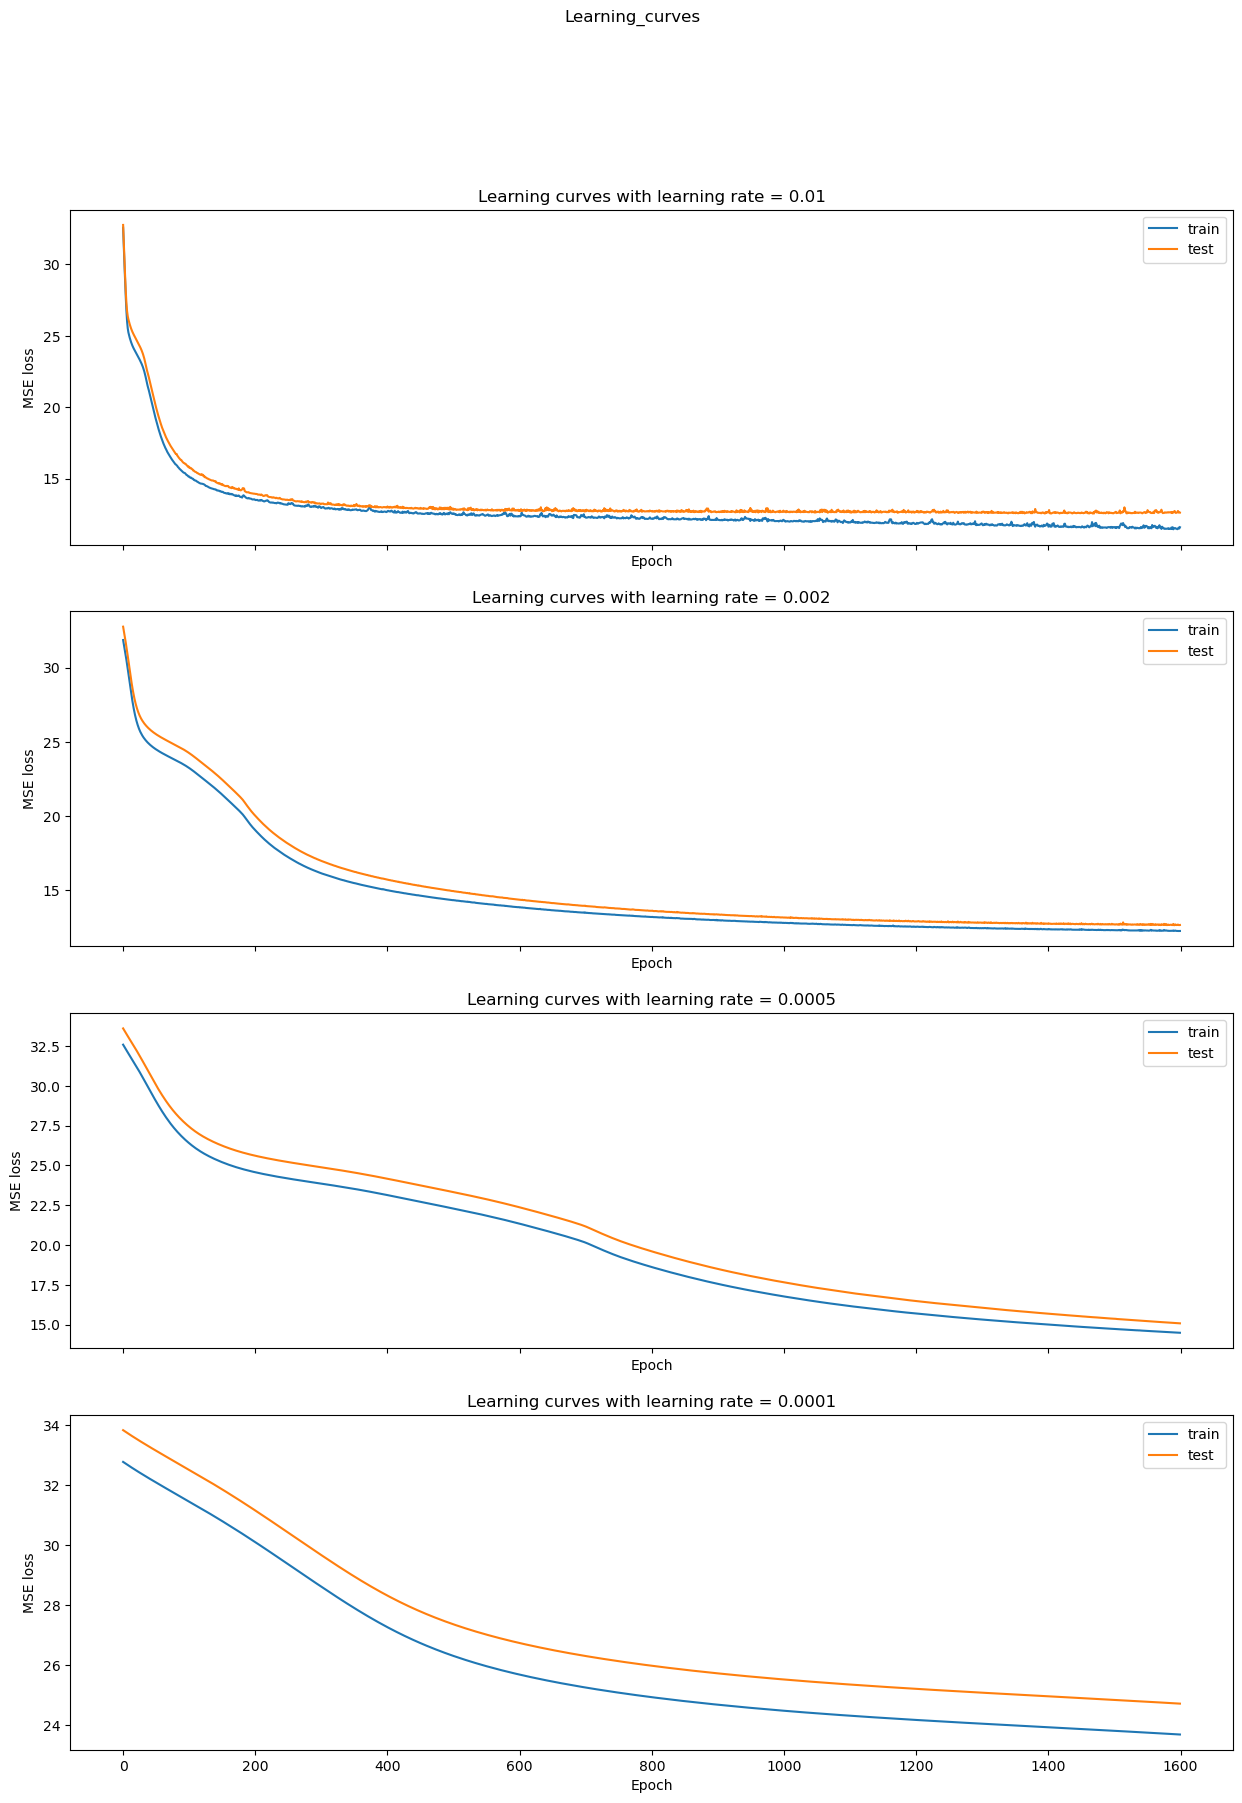

In [17]:
# training with the train dataset for different values of learning rate (0.01, 0.002, 0.0005, 0.0001)
learning_rates= [0.01, 0.002, 0.0005, 0.0001]  
epochs = 1600         
batch_size = 8000      
num_percept_layer1=20  
num_percept_layer2=10 

tuning_lr(learning_rates, num_percept_layer1, num_percept_layer2)


With this architecture, it seems from the above plots that the learning rate could be higher than 0.001 and taken to be 0.01. One would then need only 400 epochs to train the model! Let's look if there is an even better value by training the model for values of the learning rate around 0.01 (if needed, please scroll down the output cell to view the plots):

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 20)                280       
                                                                 
 dense_16 (Dense)            (None, 10)                210       
                                                                 
 dense_17 (Dense)            (None, 1)                 11        
                                                                 
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/600
4/4 [==============================] - 1s 223ms/step - loss: 32.5048 - mae: 2.5453 - val_loss: 33.1477 - val_mae: 2.4635
Epoch 2/600
4/4 [==============================] - 0s 58ms/step - loss: 31.8517 - mae: 2.4153 - val_loss: 32.5311 - val_mae: 2.3366
Epoch 3/600
4/4 [==============================] - 0s 6

4/4 [==============================] - 0s 53ms/step - loss: 17.1301 - mae: 1.6605 - val_loss: 17.9989 - val_mae: 1.6716
Epoch 118/600
4/4 [==============================] - 0s 93ms/step - loss: 17.0814 - mae: 1.6517 - val_loss: 17.9403 - val_mae: 1.6654
Epoch 119/600
4/4 [==============================] - 0s 78ms/step - loss: 17.0207 - mae: 1.6570 - val_loss: 17.8923 - val_mae: 1.6707
Epoch 120/600
4/4 [==============================] - 0s 80ms/step - loss: 16.9630 - mae: 1.6504 - val_loss: 17.8329 - val_mae: 1.6540
Epoch 121/600
4/4 [==============================] - 0s 65ms/step - loss: 16.9172 - mae: 1.6405 - val_loss: 17.7774 - val_mae: 1.6583
Epoch 122/600
4/4 [==============================] - 0s 82ms/step - loss: 16.8654 - mae: 1.6436 - val_loss: 17.7258 - val_mae: 1.6547
Epoch 123/600
4/4 [==============================] - 0s 77ms/step - loss: 16.8132 - mae: 1.6355 - val_loss: 17.6708 - val_mae: 1.6441
Epoch 124/600
4/4 [==============================] - 0s 78ms/step - loss: 16

4/4 [==============================] - 0s 82ms/step - loss: 14.2277 - mae: 1.5051 - val_loss: 14.8395 - val_mae: 1.5203
Epoch 240/600
4/4 [==============================] - 0s 76ms/step - loss: 14.2213 - mae: 1.5115 - val_loss: 14.7980 - val_mae: 1.5130
Epoch 241/600
4/4 [==============================] - 0s 82ms/step - loss: 14.2109 - mae: 1.5093 - val_loss: 14.7845 - val_mae: 1.5162
Epoch 242/600
4/4 [==============================] - 0s 98ms/step - loss: 14.2131 - mae: 1.5100 - val_loss: 14.7927 - val_mae: 1.5043
Epoch 243/600
4/4 [==============================] - 0s 76ms/step - loss: 14.1928 - mae: 1.4986 - val_loss: 14.7753 - val_mae: 1.5101
Epoch 244/600
4/4 [==============================] - 0s 88ms/step - loss: 14.1810 - mae: 1.4989 - val_loss: 14.7547 - val_mae: 1.5162
Epoch 245/600
4/4 [==============================] - 0s 70ms/step - loss: 14.1979 - mae: 1.5218 - val_loss: 14.7404 - val_mae: 1.5173
Epoch 246/600
4/4 [==============================] - 0s 74ms/step - loss: 14

4/4 [==============================] - 0s 75ms/step - loss: 13.3521 - mae: 1.4732 - val_loss: 13.7858 - val_mae: 1.4679
Epoch 362/600
4/4 [==============================] - 0s 65ms/step - loss: 13.3587 - mae: 1.4710 - val_loss: 13.7664 - val_mae: 1.4831
Epoch 363/600
4/4 [==============================] - 0s 82ms/step - loss: 13.3390 - mae: 1.4767 - val_loss: 13.7712 - val_mae: 1.4717
Epoch 364/600
4/4 [==============================] - 0s 74ms/step - loss: 13.3602 - mae: 1.4679 - val_loss: 13.7628 - val_mae: 1.4836
Epoch 365/600
4/4 [==============================] - 0s 80ms/step - loss: 13.3329 - mae: 1.4805 - val_loss: 13.7509 - val_mae: 1.4796
Epoch 366/600
4/4 [==============================] - 0s 70ms/step - loss: 13.3326 - mae: 1.4709 - val_loss: 13.7507 - val_mae: 1.4756
Epoch 367/600
4/4 [==============================] - 0s 75ms/step - loss: 13.3335 - mae: 1.4796 - val_loss: 13.7308 - val_mae: 1.4821
Epoch 368/600
4/4 [==============================] - 0s 74ms/step - loss: 13

4/4 [==============================] - 0s 58ms/step - loss: 12.9159 - mae: 1.4523 - val_loss: 13.2308 - val_mae: 1.4543
Epoch 484/600
4/4 [==============================] - 0s 71ms/step - loss: 12.8836 - mae: 1.4644 - val_loss: 13.2138 - val_mae: 1.4754
Epoch 485/600
4/4 [==============================] - 0s 77ms/step - loss: 12.8848 - mae: 1.4662 - val_loss: 13.2345 - val_mae: 1.4537
Epoch 486/600
4/4 [==============================] - 0s 63ms/step - loss: 12.8821 - mae: 1.4515 - val_loss: 13.2074 - val_mae: 1.4601
Epoch 487/600
4/4 [==============================] - 0s 72ms/step - loss: 12.8806 - mae: 1.4605 - val_loss: 13.2081 - val_mae: 1.4623
Epoch 488/600
4/4 [==============================] - 0s 63ms/step - loss: 12.8739 - mae: 1.4615 - val_loss: 13.2035 - val_mae: 1.4607
Epoch 489/600
4/4 [==============================] - 0s 69ms/step - loss: 12.8829 - mae: 1.4561 - val_loss: 13.1930 - val_mae: 1.4653
Epoch 490/600
4/4 [==============================] - 0s 69ms/step - loss: 12

Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/600
4/4 [==============================] - 1s 110ms/step - loss: 31.8032 - mae: 2.4039 - val_loss: 31.9763 - val_mae: 2.2290
Epoch 2/600
4/4 [==============================] - 0s 36ms/step - loss: 30.4205 - mae: 2.1499 - val_loss: 30.6185 - val_mae: 2.0419
Epoch 3/600
4/4 [==============================] - 0s 47ms/step - loss: 29.0796 - mae: 2.0011 - val_loss: 29.3424 - val_mae: 1.9606
Epoch 4/600
4/4 [==============================] - 0s 64ms/step - loss: 27.8634 - mae: 1.9512 - val_loss: 28.2500 - val_mae: 1.9617
Epoch 5/600
4/4 [==============================] - 0s 56ms/step - loss: 26.8561 - mae: 1.9735 - val_loss: 27.4077 - val_mae: 2.0217
Epoch 6/600
4/4 [==============================] - 0s 56ms/step - loss: 26.1158 - mae: 2.0462 - val_loss: 26.8291 - val_mae: 2.1128
Epoch 7/600
4/4 [==============================] - 0s 54ms/step - loss: 25.62

4/4 [==============================] - 0s 70ms/step - loss: 14.4287 - mae: 1.5196 - val_loss: 15.0089 - val_mae: 1.5125
Epoch 123/600
4/4 [==============================] - 0s 69ms/step - loss: 14.4400 - mae: 1.5048 - val_loss: 15.0354 - val_mae: 1.5483
Epoch 124/600
4/4 [==============================] - 0s 57ms/step - loss: 14.4144 - mae: 1.5244 - val_loss: 14.9757 - val_mae: 1.5081
Epoch 125/600
4/4 [==============================] - 0s 75ms/step - loss: 14.3840 - mae: 1.5149 - val_loss: 14.9503 - val_mae: 1.5260
Epoch 126/600
4/4 [==============================] - 0s 56ms/step - loss: 14.3572 - mae: 1.5030 - val_loss: 14.9259 - val_mae: 1.5154
Epoch 127/600
4/4 [==============================] - 0s 69ms/step - loss: 14.3276 - mae: 1.5173 - val_loss: 14.8905 - val_mae: 1.5181
Epoch 128/600
4/4 [==============================] - 0s 78ms/step - loss: 14.3084 - mae: 1.5042 - val_loss: 14.8889 - val_mae: 1.5271
Epoch 129/600
4/4 [==============================] - 0s 65ms/step - loss: 14

4/4 [==============================] - 0s 63ms/step - loss: 13.1494 - mae: 1.4741 - val_loss: 13.5204 - val_mae: 1.4674
Epoch 245/600
4/4 [==============================] - 0s 67ms/step - loss: 13.1547 - mae: 1.4629 - val_loss: 13.5253 - val_mae: 1.4921
Epoch 246/600
4/4 [==============================] - 0s 62ms/step - loss: 13.2012 - mae: 1.4926 - val_loss: 13.5083 - val_mae: 1.4633
Epoch 247/600
4/4 [==============================] - 0s 59ms/step - loss: 13.1326 - mae: 1.4560 - val_loss: 13.4871 - val_mae: 1.4794
Epoch 248/600
4/4 [==============================] - 0s 64ms/step - loss: 13.1276 - mae: 1.4750 - val_loss: 13.4700 - val_mae: 1.4587
Epoch 249/600
4/4 [==============================] - 0s 70ms/step - loss: 13.1194 - mae: 1.4573 - val_loss: 13.4567 - val_mae: 1.4695
Epoch 250/600
4/4 [==============================] - 0s 72ms/step - loss: 13.1107 - mae: 1.4681 - val_loss: 13.4607 - val_mae: 1.4816
Epoch 251/600
4/4 [==============================] - 0s 75ms/step - loss: 13

4/4 [==============================] - 0s 60ms/step - loss: 12.6940 - mae: 1.4542 - val_loss: 13.0048 - val_mae: 1.4526
Epoch 367/600
4/4 [==============================] - 0s 68ms/step - loss: 12.6907 - mae: 1.4564 - val_loss: 12.9748 - val_mae: 1.4545
Epoch 368/600
4/4 [==============================] - 0s 70ms/step - loss: 12.7241 - mae: 1.4462 - val_loss: 12.9829 - val_mae: 1.4586
Epoch 369/600
4/4 [==============================] - 0s 59ms/step - loss: 12.7040 - mae: 1.4558 - val_loss: 12.9974 - val_mae: 1.4623
Epoch 370/600
4/4 [==============================] - 0s 69ms/step - loss: 12.7132 - mae: 1.4694 - val_loss: 13.0141 - val_mae: 1.4448
Epoch 371/600
4/4 [==============================] - 0s 64ms/step - loss: 12.7119 - mae: 1.4449 - val_loss: 12.9697 - val_mae: 1.4631
Epoch 372/600
4/4 [==============================] - 0s 65ms/step - loss: 12.7397 - mae: 1.4645 - val_loss: 13.0443 - val_mae: 1.4354
Epoch 373/600
4/4 [==============================] - 0s 53ms/step - loss: 12

4/4 [==============================] - 0s 58ms/step - loss: 12.4804 - mae: 1.4508 - val_loss: 12.9367 - val_mae: 1.4291
Epoch 489/600
4/4 [==============================] - 0s 60ms/step - loss: 12.5157 - mae: 1.4352 - val_loss: 12.8313 - val_mae: 1.4732
Epoch 490/600
4/4 [==============================] - 0s 64ms/step - loss: 12.5583 - mae: 1.4739 - val_loss: 12.9093 - val_mae: 1.4331
Epoch 491/600
4/4 [==============================] - 0s 64ms/step - loss: 12.5258 - mae: 1.4314 - val_loss: 12.7952 - val_mae: 1.4613
Epoch 492/600
4/4 [==============================] - 0s 68ms/step - loss: 12.5127 - mae: 1.4704 - val_loss: 12.8059 - val_mae: 1.4455
Epoch 493/600
4/4 [==============================] - 0s 76ms/step - loss: 12.4737 - mae: 1.4447 - val_loss: 12.8338 - val_mae: 1.4373
Epoch 494/600
4/4 [==============================] - 0s 78ms/step - loss: 12.4793 - mae: 1.4431 - val_loss: 12.8127 - val_mae: 1.4605
Epoch 495/600
4/4 [==============================] - 0s 62ms/step - loss: 12

4/4 [==============================] - 0s 57ms/step - loss: 25.7250 - mae: 2.1656 - val_loss: 26.3188 - val_mae: 2.3229
Epoch 5/600
4/4 [==============================] - 0s 37ms/step - loss: 25.1699 - mae: 2.3940 - val_loss: 26.0865 - val_mae: 2.5050
Epoch 6/600
4/4 [==============================] - 0s 49ms/step - loss: 24.9915 - mae: 2.5333 - val_loss: 25.9252 - val_mae: 2.5608
Epoch 7/600
4/4 [==============================] - 0s 78ms/step - loss: 24.7942 - mae: 2.5480 - val_loss: 25.6634 - val_mae: 2.5144
Epoch 8/600
4/4 [==============================] - 0s 68ms/step - loss: 24.5258 - mae: 2.4814 - val_loss: 25.3883 - val_mae: 2.4212
Epoch 9/600
4/4 [==============================] - 0s 57ms/step - loss: 24.2727 - mae: 2.3831 - val_loss: 25.1800 - val_mae: 2.3228
Epoch 10/600
4/4 [==============================] - 0s 71ms/step - loss: 24.0931 - mae: 2.2927 - val_loss: 25.0437 - val_mae: 2.2484
Epoch 11/600
4/4 [==============================] - 0s 59ms/step - loss: 23.9743 - mae:

Epoch 66/600
4/4 [==============================] - 0s 58ms/step - loss: 14.3513 - mae: 1.4741 - val_loss: 14.9473 - val_mae: 1.5204
Epoch 67/600
4/4 [==============================] - 0s 45ms/step - loss: 14.3477 - mae: 1.4940 - val_loss: 14.7713 - val_mae: 1.4816
Epoch 68/600
4/4 [==============================] - 0s 75ms/step - loss: 14.2559 - mae: 1.5012 - val_loss: 14.7509 - val_mae: 1.4680
Epoch 69/600
4/4 [==============================] - 0s 62ms/step - loss: 14.2821 - mae: 1.4755 - val_loss: 14.7302 - val_mae: 1.5099
Epoch 70/600
4/4 [==============================] - 0s 52ms/step - loss: 14.1723 - mae: 1.4872 - val_loss: 14.6220 - val_mae: 1.4853
Epoch 71/600
4/4 [==============================] - 0s 57ms/step - loss: 14.1138 - mae: 1.4810 - val_loss: 14.6515 - val_mae: 1.4583
Epoch 72/600
4/4 [==============================] - 0s 67ms/step - loss: 14.1283 - mae: 1.4705 - val_loss: 14.5742 - val_mae: 1.4993
Epoch 73/600
4/4 [==============================] - 0s 59ms/step - lo

4/4 [==============================] - 0s 66ms/step - loss: 12.8566 - mae: 1.4500 - val_loss: 13.0253 - val_mae: 1.4150
Epoch 189/600
4/4 [==============================] - 0s 78ms/step - loss: 12.6592 - mae: 1.4347 - val_loss: 12.9364 - val_mae: 1.4539
Epoch 190/600
4/4 [==============================] - 0s 58ms/step - loss: 12.6950 - mae: 1.4565 - val_loss: 12.9503 - val_mae: 1.4695
Epoch 191/600
4/4 [==============================] - 0s 45ms/step - loss: 12.6234 - mae: 1.4525 - val_loss: 12.9839 - val_mae: 1.4214
Epoch 192/600
4/4 [==============================] - 0s 59ms/step - loss: 12.6125 - mae: 1.4247 - val_loss: 12.9182 - val_mae: 1.4335
Epoch 193/600
4/4 [==============================] - 0s 65ms/step - loss: 12.6091 - mae: 1.4349 - val_loss: 13.0574 - val_mae: 1.4339
Epoch 194/600
4/4 [==============================] - 0s 68ms/step - loss: 12.6452 - mae: 1.4625 - val_loss: 12.9704 - val_mae: 1.4803
Epoch 195/600
4/4 [==============================] - 0s 68ms/step - loss: 12

4/4 [==============================] - 0s 75ms/step - loss: 12.4145 - mae: 1.4273 - val_loss: 12.6563 - val_mae: 1.4359
Epoch 311/600
4/4 [==============================] - 0s 53ms/step - loss: 12.2964 - mae: 1.4360 - val_loss: 12.8016 - val_mae: 1.4220
Epoch 312/600
4/4 [==============================] - 0s 58ms/step - loss: 12.2975 - mae: 1.4366 - val_loss: 12.6781 - val_mae: 1.4411
Epoch 313/600
4/4 [==============================] - 0s 71ms/step - loss: 12.2901 - mae: 1.4310 - val_loss: 12.7989 - val_mae: 1.4204
Epoch 314/600
4/4 [==============================] - 0s 61ms/step - loss: 12.2969 - mae: 1.4375 - val_loss: 12.7027 - val_mae: 1.4468
Epoch 315/600
4/4 [==============================] - 0s 68ms/step - loss: 12.2984 - mae: 1.4373 - val_loss: 12.7112 - val_mae: 1.4288
Epoch 316/600
4/4 [==============================] - 0s 84ms/step - loss: 12.2749 - mae: 1.4308 - val_loss: 12.7029 - val_mae: 1.4200
Epoch 317/600
4/4 [==============================] - 0s 62ms/step - loss: 12

4/4 [==============================] - 0s 66ms/step - loss: 12.1038 - mae: 1.4350 - val_loss: 12.8534 - val_mae: 1.4281
Epoch 433/600
4/4 [==============================] - 0s 81ms/step - loss: 12.1867 - mae: 1.4178 - val_loss: 12.6701 - val_mae: 1.4614
Epoch 434/600
4/4 [==============================] - 0s 80ms/step - loss: 12.1729 - mae: 1.4537 - val_loss: 12.9926 - val_mae: 1.4054
Epoch 435/600
4/4 [==============================] - 0s 76ms/step - loss: 12.2453 - mae: 1.4108 - val_loss: 12.7208 - val_mae: 1.4866
Epoch 436/600
4/4 [==============================] - 0s 61ms/step - loss: 12.2307 - mae: 1.4645 - val_loss: 12.8719 - val_mae: 1.4165
Epoch 437/600
4/4 [==============================] - 0s 74ms/step - loss: 12.1578 - mae: 1.4091 - val_loss: 12.6362 - val_mae: 1.4325
Epoch 438/600
4/4 [==============================] - 0s 80ms/step - loss: 12.1897 - mae: 1.4309 - val_loss: 12.6251 - val_mae: 1.4500
Epoch 439/600
4/4 [==============================] - 0s 88ms/step - loss: 12

4/4 [==============================] - 0s 60ms/step - loss: 12.0534 - mae: 1.3913 - val_loss: 12.6347 - val_mae: 1.4863
Epoch 555/600
4/4 [==============================] - 0s 83ms/step - loss: 12.0754 - mae: 1.4843 - val_loss: 13.1754 - val_mae: 1.4244
Epoch 556/600
4/4 [==============================] - 0s 75ms/step - loss: 12.1814 - mae: 1.4299 - val_loss: 12.6621 - val_mae: 1.4582
Epoch 557/600
4/4 [==============================] - 0s 73ms/step - loss: 11.9975 - mae: 1.4152 - val_loss: 13.0495 - val_mae: 1.4029
Epoch 558/600
4/4 [==============================] - 0s 68ms/step - loss: 11.9871 - mae: 1.4344 - val_loss: 12.6542 - val_mae: 1.4517
Epoch 559/600
4/4 [==============================] - 0s 63ms/step - loss: 11.9049 - mae: 1.4248 - val_loss: 12.7736 - val_mae: 1.4236
Epoch 560/600
4/4 [==============================] - 0s 58ms/step - loss: 11.8883 - mae: 1.4231 - val_loss: 12.6808 - val_mae: 1.4271
Epoch 561/600
4/4 [==============================] - 0s 92ms/step - loss: 11

Epoch 71/600
4/4 [==============================] - 0s 64ms/step - loss: 13.0064 - mae: 1.4769 - val_loss: 13.2857 - val_mae: 1.4395
Epoch 72/600
4/4 [==============================] - 0s 72ms/step - loss: 13.0610 - mae: 1.4380 - val_loss: 13.8230 - val_mae: 1.5773
Epoch 73/600
4/4 [==============================] - 0s 78ms/step - loss: 13.2466 - mae: 1.4815 - val_loss: 13.2808 - val_mae: 1.4748
Epoch 74/600
4/4 [==============================] - 0s 73ms/step - loss: 13.1928 - mae: 1.4623 - val_loss: 13.4352 - val_mae: 1.4369
Epoch 75/600
4/4 [==============================] - 0s 81ms/step - loss: 13.0405 - mae: 1.4782 - val_loss: 13.2833 - val_mae: 1.4413
Epoch 76/600
4/4 [==============================] - 0s 71ms/step - loss: 13.0404 - mae: 1.4691 - val_loss: 14.0397 - val_mae: 1.4094
Epoch 77/600
4/4 [==============================] - 0s 62ms/step - loss: 13.3140 - mae: 1.4717 - val_loss: 13.1854 - val_mae: 1.4429
Epoch 78/600
4/4 [==============================] - 0s 64ms/step - lo

4/4 [==============================] - 0s 30ms/step - loss: 12.2440 - mae: 1.4377 - val_loss: 12.9505 - val_mae: 1.4194
Epoch 194/600
4/4 [==============================] - 0s 43ms/step - loss: 12.1027 - mae: 1.4282 - val_loss: 12.9263 - val_mae: 1.5001
Epoch 195/600
4/4 [==============================] - 0s 34ms/step - loss: 12.2083 - mae: 1.4247 - val_loss: 12.7136 - val_mae: 1.4579
Epoch 196/600
4/4 [==============================] - 0s 45ms/step - loss: 12.3984 - mae: 1.4756 - val_loss: 13.3614 - val_mae: 1.4155
Epoch 197/600
4/4 [==============================] - 0s 40ms/step - loss: 12.3254 - mae: 1.4487 - val_loss: 12.8076 - val_mae: 1.4067
Epoch 198/600
4/4 [==============================] - 0s 51ms/step - loss: 12.3220 - mae: 1.4305 - val_loss: 12.7346 - val_mae: 1.4752
Epoch 199/600
4/4 [==============================] - 0s 55ms/step - loss: 12.2511 - mae: 1.4647 - val_loss: 12.8996 - val_mae: 1.4741
Epoch 200/600
4/4 [==============================] - 0s 70ms/step - loss: 12

4/4 [==============================] - 0s 66ms/step - loss: 11.6667 - mae: 1.4391 - val_loss: 12.7316 - val_mae: 1.4517
Epoch 316/600
4/4 [==============================] - 0s 56ms/step - loss: 11.6462 - mae: 1.4152 - val_loss: 12.7470 - val_mae: 1.4418
Epoch 317/600
4/4 [==============================] - 0s 52ms/step - loss: 11.5490 - mae: 1.4215 - val_loss: 12.7602 - val_mae: 1.4490
Epoch 318/600
4/4 [==============================] - 0s 56ms/step - loss: 11.5253 - mae: 1.4195 - val_loss: 12.8109 - val_mae: 1.4619
Epoch 319/600
4/4 [==============================] - 0s 57ms/step - loss: 11.7998 - mae: 1.4137 - val_loss: 12.6837 - val_mae: 1.4720
Epoch 320/600
4/4 [==============================] - 0s 56ms/step - loss: 11.5718 - mae: 1.4439 - val_loss: 13.0574 - val_mae: 1.4037
Epoch 321/600
4/4 [==============================] - 0s 66ms/step - loss: 11.6012 - mae: 1.4090 - val_loss: 12.7173 - val_mae: 1.4782
Epoch 322/600
4/4 [==============================] - 0s 58ms/step - loss: 11

4/4 [==============================] - 0s 57ms/step - loss: 11.4800 - mae: 1.3957 - val_loss: 12.8616 - val_mae: 1.4496
Epoch 438/600
4/4 [==============================] - 0s 60ms/step - loss: 11.3568 - mae: 1.4242 - val_loss: 13.0055 - val_mae: 1.4287
Epoch 439/600
4/4 [==============================] - 0s 61ms/step - loss: 11.2251 - mae: 1.4233 - val_loss: 12.9033 - val_mae: 1.4726
Epoch 440/600
4/4 [==============================] - 0s 78ms/step - loss: 11.3637 - mae: 1.3921 - val_loss: 12.8418 - val_mae: 1.4302
Epoch 441/600
4/4 [==============================] - 0s 57ms/step - loss: 11.4033 - mae: 1.4429 - val_loss: 13.2722 - val_mae: 1.4184
Epoch 442/600
4/4 [==============================] - 0s 73ms/step - loss: 11.4930 - mae: 1.4142 - val_loss: 13.1474 - val_mae: 1.4698
Epoch 443/600
4/4 [==============================] - 0s 49ms/step - loss: 11.5307 - mae: 1.3912 - val_loss: 12.8176 - val_mae: 1.4519
Epoch 444/600
4/4 [==============================] - 0s 76ms/step - loss: 11

4/4 [==============================] - 0s 80ms/step - loss: 11.4538 - mae: 1.4246 - val_loss: 13.2547 - val_mae: 1.4713
Epoch 560/600
4/4 [==============================] - 0s 67ms/step - loss: 11.1112 - mae: 1.3981 - val_loss: 13.2074 - val_mae: 1.4382
Epoch 561/600
4/4 [==============================] - 0s 68ms/step - loss: 11.1359 - mae: 1.4218 - val_loss: 13.1102 - val_mae: 1.4591
Epoch 562/600
4/4 [==============================] - 0s 69ms/step - loss: 11.0341 - mae: 1.3880 - val_loss: 13.0155 - val_mae: 1.4301
Epoch 563/600
4/4 [==============================] - 0s 67ms/step - loss: 11.0409 - mae: 1.4071 - val_loss: 13.1861 - val_mae: 1.4147
Epoch 564/600
4/4 [==============================] - 0s 42ms/step - loss: 11.1791 - mae: 1.4110 - val_loss: 13.2331 - val_mae: 1.4896
Epoch 565/600
4/4 [==============================] - 0s 58ms/step - loss: 11.0788 - mae: 1.4076 - val_loss: 13.0287 - val_mae: 1.4295
Epoch 566/600
4/4 [==============================] - 0s 80ms/step - loss: 10

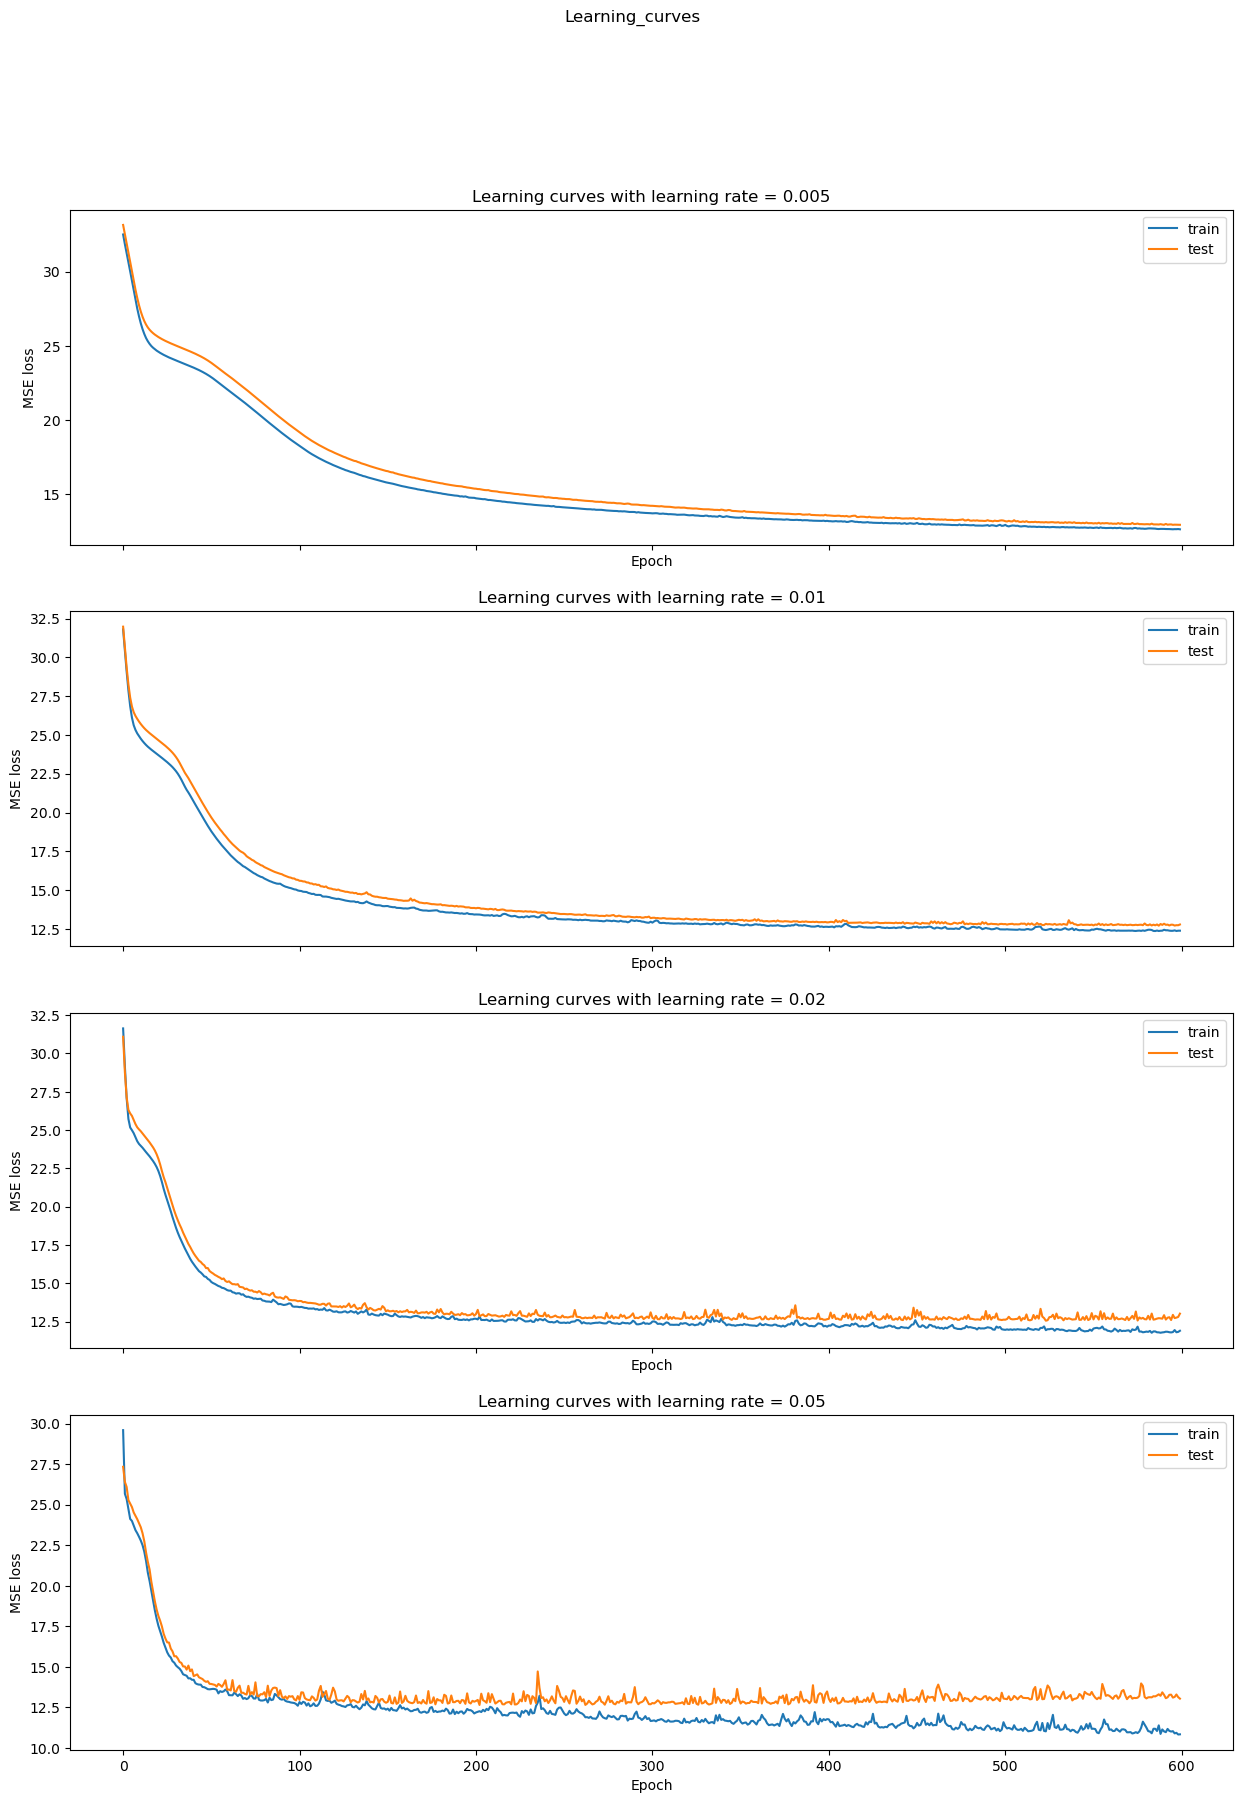

In [18]:
# training with the train dataset for different values of learning rate (0.005, 0.01, 0.02, 0.05)
learning_rates= [0.005, 0.01, 0.02, 0.05]  
epochs = 600         
batch_size = 8000      
num_percept_layer1=20  
num_percept_layer2=10 

tuning_lr(learning_rates, num_percept_layer1, num_percept_layer2)


It can be seen here that, with this architecture, an optimal learning rate is around 0.02 with around 300 epochs. There are however some oscillations at around the minimum value. One could then have in the training some steps with a smaller value for the learning rate (like the initial 0.001).

## Tuning the number of perceptrons

Until now, the numbers of perceptrons were 20 in the first layer and 10 in the second layer. Turn now to the tuning of the architecture of the neural network, using the values proposed above for each layer.

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 40)                560       
                                                                 
 dense_28 (Dense)            (None, 10)                410       
                                                                 
 dense_29 (Dense)            (None, 1)                 11        
                                                                 
Total params: 981
Trainable params: 981
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1600
4/4 [==============================] - 1s 108ms/step - loss: 32.6533 - mae: 2.5748 - val_loss: 33.6077 - val_mae: 2.5554
Epoch 2/1600
4/4 [==============================] - 0s 48ms/step - loss: 32.4775 - mae: 2.5413 - val_loss: 33.4370 - val_mae: 2.5224
Epoch 3/1600
4/4 [==============================] - 0

4/4 [==============================] - 0s 60ms/step - loss: 24.3005 - mae: 2.1508 - val_loss: 25.3289 - val_mae: 2.1533
Epoch 118/1600
4/4 [==============================] - 0s 72ms/step - loss: 24.2826 - mae: 2.1515 - val_loss: 25.3109 - val_mae: 2.1539
Epoch 119/1600
4/4 [==============================] - 0s 79ms/step - loss: 24.2645 - mae: 2.1520 - val_loss: 25.2933 - val_mae: 2.1543
Epoch 120/1600
4/4 [==============================] - 0s 86ms/step - loss: 24.2472 - mae: 2.1524 - val_loss: 25.2757 - val_mae: 2.1546
Epoch 121/1600
4/4 [==============================] - 0s 84ms/step - loss: 24.2301 - mae: 2.1528 - val_loss: 25.2581 - val_mae: 2.1550
Epoch 122/1600
4/4 [==============================] - 0s 67ms/step - loss: 24.2127 - mae: 2.1531 - val_loss: 25.2408 - val_mae: 2.1552
Epoch 123/1600
4/4 [==============================] - 0s 56ms/step - loss: 24.1956 - mae: 2.1533 - val_loss: 25.2235 - val_mae: 2.1554
Epoch 124/1600
4/4 [==============================] - 0s 59ms/step - l

Epoch 178/1600
4/4 [==============================] - 0s 71ms/step - loss: 23.0028 - mae: 2.0152 - val_loss: 24.0137 - val_mae: 2.0142
Epoch 179/1600
4/4 [==============================] - 0s 96ms/step - loss: 22.9746 - mae: 2.0118 - val_loss: 23.9851 - val_mae: 2.0109
Epoch 180/1600
4/4 [==============================] - 0s 83ms/step - loss: 22.9451 - mae: 2.0080 - val_loss: 23.9564 - val_mae: 2.0069
Epoch 181/1600
4/4 [==============================] - 0s 76ms/step - loss: 22.9164 - mae: 2.0043 - val_loss: 23.9272 - val_mae: 2.0035
Epoch 182/1600
4/4 [==============================] - 0s 72ms/step - loss: 22.8865 - mae: 2.0007 - val_loss: 23.8978 - val_mae: 1.9999
Epoch 183/1600
4/4 [==============================] - 0s 76ms/step - loss: 22.8573 - mae: 1.9973 - val_loss: 23.8677 - val_mae: 1.9967
Epoch 184/1600
4/4 [==============================] - 0s 81ms/step - loss: 22.8264 - mae: 1.9937 - val_loss: 23.8376 - val_mae: 1.9929
Epoch 185/1600
4/4 [==============================] - 0

Epoch 239/1600
4/4 [==============================] - 0s 85ms/step - loss: 21.2079 - mae: 1.8203 - val_loss: 22.2255 - val_mae: 1.8278
Epoch 240/1600
4/4 [==============================] - 0s 79ms/step - loss: 21.1814 - mae: 1.8179 - val_loss: 22.1985 - val_mae: 1.8257
Epoch 241/1600
4/4 [==============================] - 0s 86ms/step - loss: 21.1544 - mae: 1.8152 - val_loss: 22.1719 - val_mae: 1.8228
Epoch 242/1600
4/4 [==============================] - 0s 63ms/step - loss: 21.1280 - mae: 1.8127 - val_loss: 22.1452 - val_mae: 1.8212
Epoch 243/1600
4/4 [==============================] - 0s 61ms/step - loss: 21.1014 - mae: 1.8111 - val_loss: 22.1185 - val_mae: 1.8198
Epoch 244/1600
4/4 [==============================] - 0s 56ms/step - loss: 21.0748 - mae: 1.8096 - val_loss: 22.0920 - val_mae: 1.8184
Epoch 245/1600
4/4 [==============================] - 0s 56ms/step - loss: 21.0479 - mae: 1.8075 - val_loss: 22.0653 - val_mae: 1.8160
Epoch 246/1600
4/4 [==============================] - 0

Epoch 300/1600
4/4 [==============================] - 0s 69ms/step - loss: 19.6767 - mae: 1.7162 - val_loss: 20.6878 - val_mae: 1.7298
Epoch 301/1600
4/4 [==============================] - 0s 78ms/step - loss: 19.6531 - mae: 1.7138 - val_loss: 20.6637 - val_mae: 1.7266
Epoch 302/1600
4/4 [==============================] - 0s 64ms/step - loss: 19.6298 - mae: 1.7115 - val_loss: 20.6399 - val_mae: 1.7253
Epoch 303/1600
4/4 [==============================] - 0s 64ms/step - loss: 19.6058 - mae: 1.7094 - val_loss: 20.6162 - val_mae: 1.7226
Epoch 304/1600
4/4 [==============================] - 0s 67ms/step - loss: 19.5825 - mae: 1.7071 - val_loss: 20.5928 - val_mae: 1.7211
Epoch 305/1600
4/4 [==============================] - 0s 69ms/step - loss: 19.5590 - mae: 1.7054 - val_loss: 20.5689 - val_mae: 1.7193
Epoch 306/1600
4/4 [==============================] - 0s 70ms/step - loss: 19.5357 - mae: 1.7036 - val_loss: 20.5446 - val_mae: 1.7175
Epoch 307/1600
4/4 [==============================] - 0

Epoch 361/1600
4/4 [==============================] - 0s 52ms/step - loss: 18.2951 - mae: 1.6029 - val_loss: 19.2828 - val_mae: 1.6183
Epoch 362/1600
4/4 [==============================] - 0s 61ms/step - loss: 18.2757 - mae: 1.6015 - val_loss: 19.2638 - val_mae: 1.6164
Epoch 363/1600
4/4 [==============================] - 0s 63ms/step - loss: 18.2576 - mae: 1.5993 - val_loss: 19.2453 - val_mae: 1.6152
Epoch 364/1600
4/4 [==============================] - 0s 67ms/step - loss: 18.2394 - mae: 1.5988 - val_loss: 19.2263 - val_mae: 1.6154
Epoch 365/1600
4/4 [==============================] - 0s 75ms/step - loss: 18.2222 - mae: 1.6000 - val_loss: 19.2090 - val_mae: 1.6162
Epoch 366/1600
4/4 [==============================] - 0s 66ms/step - loss: 18.2034 - mae: 1.5995 - val_loss: 19.1888 - val_mae: 1.6138
Epoch 367/1600
4/4 [==============================] - 0s 83ms/step - loss: 18.1853 - mae: 1.5961 - val_loss: 19.1706 - val_mae: 1.6105
Epoch 368/1600
4/4 [==============================] - 0

Epoch 422/1600
4/4 [==============================] - 0s 56ms/step - loss: 17.3331 - mae: 1.5506 - val_loss: 18.2879 - val_mae: 1.5657
Epoch 423/1600
4/4 [==============================] - 0s 50ms/step - loss: 17.3194 - mae: 1.5495 - val_loss: 18.2739 - val_mae: 1.5662
Epoch 424/1600
4/4 [==============================] - 0s 46ms/step - loss: 17.3052 - mae: 1.5510 - val_loss: 18.2614 - val_mae: 1.5685
Epoch 425/1600
4/4 [==============================] - 0s 59ms/step - loss: 17.2927 - mae: 1.5520 - val_loss: 18.2467 - val_mae: 1.5670
Epoch 426/1600
4/4 [==============================] - 0s 80ms/step - loss: 17.2799 - mae: 1.5508 - val_loss: 18.2320 - val_mae: 1.5660
Epoch 427/1600
4/4 [==============================] - 0s 50ms/step - loss: 17.2666 - mae: 1.5504 - val_loss: 18.2186 - val_mae: 1.5655
Epoch 428/1600
4/4 [==============================] - 0s 52ms/step - loss: 17.2531 - mae: 1.5494 - val_loss: 18.2045 - val_mae: 1.5640
Epoch 429/1600
4/4 [==============================] - 0

Epoch 483/1600
4/4 [==============================] - 0s 69ms/step - loss: 16.6294 - mae: 1.5231 - val_loss: 17.5412 - val_mae: 1.5395
Epoch 484/1600
4/4 [==============================] - 0s 56ms/step - loss: 16.6189 - mae: 1.5259 - val_loss: 17.5346 - val_mae: 1.5421
Epoch 485/1600
4/4 [==============================] - 0s 65ms/step - loss: 16.6096 - mae: 1.5259 - val_loss: 17.5207 - val_mae: 1.5387
Epoch 486/1600
4/4 [==============================] - 0s 58ms/step - loss: 16.5999 - mae: 1.5228 - val_loss: 17.5094 - val_mae: 1.5368
Epoch 487/1600
4/4 [==============================] - 0s 70ms/step - loss: 16.5914 - mae: 1.5221 - val_loss: 17.4993 - val_mae: 1.5371
Epoch 488/1600
4/4 [==============================] - 0s 83ms/step - loss: 16.5801 - mae: 1.5213 - val_loss: 17.4880 - val_mae: 1.5370
Epoch 489/1600
4/4 [==============================] - 0s 62ms/step - loss: 16.5698 - mae: 1.5235 - val_loss: 17.4802 - val_mae: 1.5402
Epoch 490/1600
4/4 [==============================] - 0

Epoch 544/1600
4/4 [==============================] - 0s 64ms/step - loss: 16.0895 - mae: 1.5085 - val_loss: 16.9543 - val_mae: 1.5227
Epoch 545/1600
4/4 [==============================] - 0s 57ms/step - loss: 16.0826 - mae: 1.5091 - val_loss: 16.9456 - val_mae: 1.5231
Epoch 546/1600
4/4 [==============================] - 0s 72ms/step - loss: 16.0740 - mae: 1.5080 - val_loss: 16.9354 - val_mae: 1.5209
Epoch 547/1600
4/4 [==============================] - 0s 66ms/step - loss: 16.0671 - mae: 1.5076 - val_loss: 16.9279 - val_mae: 1.5219
Epoch 548/1600
4/4 [==============================] - 0s 59ms/step - loss: 16.0594 - mae: 1.5079 - val_loss: 16.9194 - val_mae: 1.5214
Epoch 549/1600
4/4 [==============================] - 0s 66ms/step - loss: 16.0525 - mae: 1.5065 - val_loss: 16.9099 - val_mae: 1.5199
Epoch 550/1600
4/4 [==============================] - 0s 79ms/step - loss: 16.0437 - mae: 1.5062 - val_loss: 16.9005 - val_mae: 1.5190
Epoch 551/1600
4/4 [==============================] - 0

Epoch 605/1600
4/4 [==============================] - 0s 65ms/step - loss: 15.6562 - mae: 1.5032 - val_loss: 16.4726 - val_mae: 1.5137
Epoch 606/1600
4/4 [==============================] - 0s 71ms/step - loss: 15.6451 - mae: 1.4963 - val_loss: 16.4591 - val_mae: 1.5052
Epoch 607/1600
4/4 [==============================] - 0s 56ms/step - loss: 15.6441 - mae: 1.4897 - val_loss: 16.4516 - val_mae: 1.5050
Epoch 608/1600
4/4 [==============================] - 0s 61ms/step - loss: 15.6327 - mae: 1.4931 - val_loss: 16.4492 - val_mae: 1.5128
Epoch 609/1600
4/4 [==============================] - 0s 63ms/step - loss: 15.6301 - mae: 1.5022 - val_loss: 16.4472 - val_mae: 1.5175
Epoch 610/1600
4/4 [==============================] - 0s 77ms/step - loss: 15.6215 - mae: 1.5000 - val_loss: 16.4312 - val_mae: 1.5075
Epoch 611/1600
4/4 [==============================] - 0s 56ms/step - loss: 15.6156 - mae: 1.4912 - val_loss: 16.4234 - val_mae: 1.5036
Epoch 612/1600
4/4 [==============================] - 0

Epoch 666/1600
4/4 [==============================] - 0s 63ms/step - loss: 15.2876 - mae: 1.4891 - val_loss: 16.0587 - val_mae: 1.5009
Epoch 667/1600
4/4 [==============================] - 0s 70ms/step - loss: 15.2826 - mae: 1.4868 - val_loss: 16.0502 - val_mae: 1.4977
Epoch 668/1600
4/4 [==============================] - 0s 52ms/step - loss: 15.2785 - mae: 1.4877 - val_loss: 16.0473 - val_mae: 1.5020
Epoch 669/1600
4/4 [==============================] - 0s 53ms/step - loss: 15.2715 - mae: 1.4874 - val_loss: 16.0385 - val_mae: 1.4976
Epoch 670/1600
4/4 [==============================] - 0s 57ms/step - loss: 15.2672 - mae: 1.4854 - val_loss: 16.0337 - val_mae: 1.4982
Epoch 671/1600
4/4 [==============================] - 0s 66ms/step - loss: 15.2612 - mae: 1.4861 - val_loss: 16.0272 - val_mae: 1.4989
Epoch 672/1600
4/4 [==============================] - 0s 57ms/step - loss: 15.2572 - mae: 1.4856 - val_loss: 16.0218 - val_mae: 1.4997
Epoch 673/1600
4/4 [==============================] - 0

Epoch 727/1600
4/4 [==============================] - 0s 60ms/step - loss: 14.9762 - mae: 1.4775 - val_loss: 15.7068 - val_mae: 1.4914
Epoch 728/1600
4/4 [==============================] - 0s 64ms/step - loss: 14.9722 - mae: 1.4786 - val_loss: 15.7026 - val_mae: 1.4918
Epoch 729/1600
4/4 [==============================] - 0s 70ms/step - loss: 14.9662 - mae: 1.4816 - val_loss: 15.7002 - val_mae: 1.4959
Epoch 730/1600
4/4 [==============================] - 0s 73ms/step - loss: 14.9622 - mae: 1.4833 - val_loss: 15.6919 - val_mae: 1.4924
Epoch 731/1600
4/4 [==============================] - 0s 92ms/step - loss: 14.9557 - mae: 1.4790 - val_loss: 15.6838 - val_mae: 1.4882
Epoch 732/1600
4/4 [==============================] - 0s 70ms/step - loss: 14.9560 - mae: 1.4790 - val_loss: 15.6800 - val_mae: 1.4923
Epoch 733/1600
4/4 [==============================] - 0s 108ms/step - loss: 14.9484 - mae: 1.4789 - val_loss: 15.6715 - val_mae: 1.4881
Epoch 734/1600
4/4 [==============================] - 

Epoch 848/1600
4/4 [==============================] - 0s 71ms/step - loss: 14.4716 - mae: 1.4675 - val_loss: 15.1359 - val_mae: 1.4800
Epoch 849/1600
4/4 [==============================] - 0s 79ms/step - loss: 14.4705 - mae: 1.4724 - val_loss: 15.1355 - val_mae: 1.4843
Epoch 850/1600
4/4 [==============================] - 0s 87ms/step - loss: 14.4654 - mae: 1.4720 - val_loss: 15.1237 - val_mae: 1.4763
Epoch 851/1600
4/4 [==============================] - 0s 82ms/step - loss: 14.4627 - mae: 1.4657 - val_loss: 15.1213 - val_mae: 1.4742
Epoch 852/1600
4/4 [==============================] - 0s 79ms/step - loss: 14.4591 - mae: 1.4646 - val_loss: 15.1165 - val_mae: 1.4778
Epoch 853/1600
4/4 [==============================] - 0s 88ms/step - loss: 14.4539 - mae: 1.4702 - val_loss: 15.1160 - val_mae: 1.4842
Epoch 854/1600
4/4 [==============================] - 0s 58ms/step - loss: 14.4508 - mae: 1.4743 - val_loss: 15.1120 - val_mae: 1.4822
Epoch 855/1600
4/4 [==============================] - 0

Epoch 969/1600
4/4 [==============================] - 0s 85ms/step - loss: 14.0753 - mae: 1.4617 - val_loss: 14.6799 - val_mae: 1.4729
Epoch 970/1600
4/4 [==============================] - 0s 94ms/step - loss: 14.0744 - mae: 1.4641 - val_loss: 14.6797 - val_mae: 1.4733
Epoch 971/1600
4/4 [==============================] - 0s 87ms/step - loss: 14.0717 - mae: 1.4629 - val_loss: 14.6706 - val_mae: 1.4674
Epoch 972/1600
4/4 [==============================] - 0s 96ms/step - loss: 14.0694 - mae: 1.4598 - val_loss: 14.6643 - val_mae: 1.4682
Epoch 973/1600
4/4 [==============================] - 0s 75ms/step - loss: 14.0645 - mae: 1.4603 - val_loss: 14.6604 - val_mae: 1.4686
Epoch 974/1600
4/4 [==============================] - 0s 79ms/step - loss: 14.0625 - mae: 1.4604 - val_loss: 14.6590 - val_mae: 1.4685
Epoch 975/1600
4/4 [==============================] - 0s 77ms/step - loss: 14.0585 - mae: 1.4600 - val_loss: 14.6569 - val_mae: 1.4697
Epoch 976/1600
4/4 [==============================] - 0

4/4 [==============================] - 0s 75ms/step - loss: 13.7517 - mae: 1.4579 - val_loss: 14.2986 - val_mae: 1.4607
Epoch 1090/1600
4/4 [==============================] - 0s 58ms/step - loss: 13.7468 - mae: 1.4520 - val_loss: 14.2903 - val_mae: 1.4565
Epoch 1091/1600
4/4 [==============================] - 0s 67ms/step - loss: 13.7462 - mae: 1.4498 - val_loss: 14.2883 - val_mae: 1.4601
Epoch 1092/1600
4/4 [==============================] - 0s 65ms/step - loss: 13.7431 - mae: 1.4557 - val_loss: 14.2896 - val_mae: 1.4662
Epoch 1093/1600
4/4 [==============================] - 0s 64ms/step - loss: 13.7399 - mae: 1.4581 - val_loss: 14.2844 - val_mae: 1.4633
Epoch 1094/1600
4/4 [==============================] - 0s 67ms/step - loss: 13.7429 - mae: 1.4585 - val_loss: 14.2844 - val_mae: 1.4647
Epoch 1095/1600
4/4 [==============================] - 0s 59ms/step - loss: 13.7339 - mae: 1.4541 - val_loss: 14.2795 - val_mae: 1.4569
Epoch 1096/1600
4/4 [==============================] - 0s 58ms/s

4/4 [==============================] - 0s 89ms/step - loss: 13.4777 - mae: 1.4489 - val_loss: 13.9717 - val_mae: 1.4544
Epoch 1210/1600
4/4 [==============================] - 0s 76ms/step - loss: 13.4831 - mae: 1.4453 - val_loss: 13.9720 - val_mae: 1.4538
Epoch 1211/1600
4/4 [==============================] - 0s 74ms/step - loss: 13.4690 - mae: 1.4514 - val_loss: 13.9830 - val_mae: 1.4663
Epoch 1212/1600
4/4 [==============================] - 0s 62ms/step - loss: 13.4759 - mae: 1.4595 - val_loss: 13.9764 - val_mae: 1.4622
Epoch 1213/1600
4/4 [==============================] - 0s 70ms/step - loss: 13.4689 - mae: 1.4499 - val_loss: 13.9652 - val_mae: 1.4478
Epoch 1214/1600
4/4 [==============================] - 0s 67ms/step - loss: 13.4726 - mae: 1.4408 - val_loss: 13.9594 - val_mae: 1.4513
Epoch 1215/1600
4/4 [==============================] - 0s 47ms/step - loss: 13.4627 - mae: 1.4490 - val_loss: 13.9658 - val_mae: 1.4627
Epoch 1216/1600
4/4 [==============================] - 0s 66ms/s

4/4 [==============================] - 0s 83ms/step - loss: 13.2477 - mae: 1.4459 - val_loss: 13.7073 - val_mae: 1.4533
Epoch 1330/1600
4/4 [==============================] - 0s 79ms/step - loss: 13.2408 - mae: 1.4456 - val_loss: 13.7016 - val_mae: 1.4486
Epoch 1331/1600
4/4 [==============================] - 0s 79ms/step - loss: 13.2410 - mae: 1.4416 - val_loss: 13.6940 - val_mae: 1.4465
Epoch 1332/1600
4/4 [==============================] - 0s 74ms/step - loss: 13.2362 - mae: 1.4405 - val_loss: 13.6922 - val_mae: 1.4505
Epoch 1333/1600
4/4 [==============================] - 0s 60ms/step - loss: 13.2368 - mae: 1.4446 - val_loss: 13.6948 - val_mae: 1.4565
Epoch 1334/1600
4/4 [==============================] - 0s 68ms/step - loss: 13.2330 - mae: 1.4507 - val_loss: 13.6961 - val_mae: 1.4577
Epoch 1335/1600
4/4 [==============================] - 0s 71ms/step - loss: 13.2346 - mae: 1.4469 - val_loss: 13.6907 - val_mae: 1.4499
Epoch 1336/1600
4/4 [==============================] - 0s 82ms/s

4/4 [==============================] - 0s 72ms/step - loss: 13.0393 - mae: 1.4410 - val_loss: 13.4702 - val_mae: 1.4510
Epoch 1450/1600
4/4 [==============================] - 0s 71ms/step - loss: 13.0419 - mae: 1.4453 - val_loss: 13.4653 - val_mae: 1.4523
Epoch 1451/1600
4/4 [==============================] - 0s 81ms/step - loss: 13.0377 - mae: 1.4438 - val_loss: 13.4623 - val_mae: 1.4456
Epoch 1452/1600
4/4 [==============================] - 0s 77ms/step - loss: 13.0362 - mae: 1.4374 - val_loss: 13.4613 - val_mae: 1.4421
Epoch 1453/1600
4/4 [==============================] - 0s 73ms/step - loss: 13.0358 - mae: 1.4364 - val_loss: 13.4602 - val_mae: 1.4457
Epoch 1454/1600
4/4 [==============================] - 0s 69ms/step - loss: 13.0339 - mae: 1.4424 - val_loss: 13.4627 - val_mae: 1.4532
Epoch 1455/1600
4/4 [==============================] - 0s 64ms/step - loss: 13.0336 - mae: 1.4440 - val_loss: 13.4566 - val_mae: 1.4483
Epoch 1456/1600
4/4 [==============================] - 0s 58ms/s

4/4 [==============================] - 0s 74ms/step - loss: 12.8705 - mae: 1.4342 - val_loss: 13.2703 - val_mae: 1.4428
Epoch 1570/1600
4/4 [==============================] - 0s 83ms/step - loss: 12.8654 - mae: 1.4385 - val_loss: 13.2686 - val_mae: 1.4482
Epoch 1571/1600
4/4 [==============================] - 0s 76ms/step - loss: 12.8662 - mae: 1.4426 - val_loss: 13.2631 - val_mae: 1.4466
Epoch 1572/1600
4/4 [==============================] - 0s 57ms/step - loss: 12.8624 - mae: 1.4379 - val_loss: 13.2616 - val_mae: 1.4403
Epoch 1573/1600
4/4 [==============================] - 0s 59ms/step - loss: 12.8654 - mae: 1.4326 - val_loss: 13.2639 - val_mae: 1.4394
Epoch 1574/1600
4/4 [==============================] - 0s 70ms/step - loss: 12.8598 - mae: 1.4348 - val_loss: 13.2599 - val_mae: 1.4438
Epoch 1575/1600
4/4 [==============================] - 0s 71ms/step - loss: 12.8660 - mae: 1.4413 - val_loss: 13.2595 - val_mae: 1.4475
Epoch 1576/1600
4/4 [==============================] - 0s 63ms/s

Epoch 24/1600
4/4 [==============================] - 0s 103ms/step - loss: 26.5485 - mae: 1.9939 - val_loss: 27.4918 - val_mae: 2.0087
Epoch 25/1600
4/4 [==============================] - 0s 78ms/step - loss: 26.3736 - mae: 2.0076 - val_loss: 27.3247 - val_mae: 2.0237
Epoch 26/1600
4/4 [==============================] - 0s 64ms/step - loss: 26.2117 - mae: 2.0225 - val_loss: 27.1708 - val_mae: 2.0398
Epoch 27/1600
4/4 [==============================] - 0s 74ms/step - loss: 26.0616 - mae: 2.0390 - val_loss: 27.0302 - val_mae: 2.0567
Epoch 28/1600
4/4 [==============================] - 0s 60ms/step - loss: 25.9277 - mae: 2.0565 - val_loss: 26.9012 - val_mae: 2.0744
Epoch 29/1600
4/4 [==============================] - 0s 66ms/step - loss: 25.8045 - mae: 2.0744 - val_loss: 26.7840 - val_mae: 2.0924
Epoch 30/1600
4/4 [==============================] - 0s 75ms/step - loss: 25.6912 - mae: 2.0923 - val_loss: 26.6782 - val_mae: 2.1104
Epoch 31/1600
4/4 [==============================] - 0s 70ms/

Epoch 146/1600
4/4 [==============================] - 0s 73ms/step - loss: 23.2191 - mae: 2.2254 - val_loss: 24.2316 - val_mae: 2.2265
Epoch 147/1600
4/4 [==============================] - 0s 46ms/step - loss: 23.2024 - mae: 2.2236 - val_loss: 24.2147 - val_mae: 2.2245
Epoch 148/1600
4/4 [==============================] - 0s 57ms/step - loss: 23.1855 - mae: 2.2218 - val_loss: 24.1976 - val_mae: 2.2231
Epoch 149/1600
4/4 [==============================] - 0s 50ms/step - loss: 23.1684 - mae: 2.2202 - val_loss: 24.1804 - val_mae: 2.2213
Epoch 150/1600
4/4 [==============================] - 0s 67ms/step - loss: 23.1510 - mae: 2.2182 - val_loss: 24.1630 - val_mae: 2.2193
Epoch 151/1600
4/4 [==============================] - 0s 70ms/step - loss: 23.1337 - mae: 2.2163 - val_loss: 24.1453 - val_mae: 2.2177
Epoch 152/1600
4/4 [==============================] - 0s 56ms/step - loss: 23.1160 - mae: 2.2146 - val_loss: 24.1275 - val_mae: 2.2160
Epoch 153/1600
4/4 [==============================] - 0

Epoch 207/1600
4/4 [==============================] - 0s 50ms/step - loss: 21.8515 - mae: 2.0987 - val_loss: 22.8646 - val_mae: 2.1029
Epoch 208/1600
4/4 [==============================] - 0s 58ms/step - loss: 21.8256 - mae: 2.0964 - val_loss: 22.8391 - val_mae: 2.1008
Epoch 209/1600
4/4 [==============================] - 0s 61ms/step - loss: 21.8010 - mae: 2.0947 - val_loss: 22.8133 - val_mae: 2.0993
Epoch 210/1600
4/4 [==============================] - 0s 60ms/step - loss: 21.7743 - mae: 2.0921 - val_loss: 22.7879 - val_mae: 2.0959
Epoch 211/1600
4/4 [==============================] - 0s 58ms/step - loss: 21.7486 - mae: 2.0887 - val_loss: 22.7624 - val_mae: 2.0929
Epoch 212/1600
4/4 [==============================] - 0s 68ms/step - loss: 21.7232 - mae: 2.0859 - val_loss: 22.7367 - val_mae: 2.0908
Epoch 213/1600
4/4 [==============================] - 0s 64ms/step - loss: 21.6974 - mae: 2.0832 - val_loss: 22.7110 - val_mae: 2.0880
Epoch 214/1600
4/4 [==============================] - 0

Epoch 268/1600
4/4 [==============================] - 0s 53ms/step - loss: 20.1181 - mae: 1.9389 - val_loss: 21.1200 - val_mae: 1.9503
Epoch 269/1600
4/4 [==============================] - 0s 62ms/step - loss: 20.0857 - mae: 1.9358 - val_loss: 21.0871 - val_mae: 1.9472
Epoch 270/1600
4/4 [==============================] - 0s 64ms/step - loss: 20.0541 - mae: 1.9331 - val_loss: 21.0536 - val_mae: 1.9452
Epoch 271/1600
4/4 [==============================] - 0s 69ms/step - loss: 20.0197 - mae: 1.9298 - val_loss: 21.0209 - val_mae: 1.9415
Epoch 272/1600
4/4 [==============================] - 0s 51ms/step - loss: 19.9881 - mae: 1.9270 - val_loss: 20.9874 - val_mae: 1.9393
Epoch 273/1600
4/4 [==============================] - 0s 57ms/step - loss: 19.9549 - mae: 1.9244 - val_loss: 20.9542 - val_mae: 1.9365
Epoch 274/1600
4/4 [==============================] - 0s 46ms/step - loss: 19.9216 - mae: 1.9210 - val_loss: 20.9211 - val_mae: 1.9330
Epoch 275/1600
4/4 [==============================] - 0

Epoch 329/1600
4/4 [==============================] - 0s 64ms/step - loss: 17.7562 - mae: 1.7081 - val_loss: 18.6878 - val_mae: 1.7246
Epoch 330/1600
4/4 [==============================] - 0s 67ms/step - loss: 17.7166 - mae: 1.7062 - val_loss: 18.6481 - val_mae: 1.7228
Epoch 331/1600
4/4 [==============================] - 0s 73ms/step - loss: 17.6790 - mae: 1.7046 - val_loss: 18.6082 - val_mae: 1.7210
Epoch 332/1600
4/4 [==============================] - 0s 76ms/step - loss: 17.6407 - mae: 1.7026 - val_loss: 18.5692 - val_mae: 1.7188
Epoch 333/1600
4/4 [==============================] - 0s 73ms/step - loss: 17.6046 - mae: 1.7006 - val_loss: 18.5302 - val_mae: 1.7159
Epoch 334/1600
4/4 [==============================] - 0s 89ms/step - loss: 17.5672 - mae: 1.6980 - val_loss: 18.4922 - val_mae: 1.7135
Epoch 335/1600
4/4 [==============================] - 0s 67ms/step - loss: 17.5310 - mae: 1.6952 - val_loss: 18.4546 - val_mae: 1.7108
Epoch 336/1600
4/4 [==============================] - 0

Epoch 390/1600
4/4 [==============================] - 0s 72ms/step - loss: 16.0295 - mae: 1.6033 - val_loss: 16.8631 - val_mae: 1.6165
Epoch 391/1600
4/4 [==============================] - 0s 74ms/step - loss: 16.0088 - mae: 1.6032 - val_loss: 16.8424 - val_mae: 1.6186
Epoch 392/1600
4/4 [==============================] - 0s 71ms/step - loss: 15.9871 - mae: 1.6023 - val_loss: 16.8191 - val_mae: 1.6150
Epoch 393/1600
4/4 [==============================] - 0s 58ms/step - loss: 15.9675 - mae: 1.5993 - val_loss: 16.7969 - val_mae: 1.6134
Epoch 394/1600
4/4 [==============================] - 0s 68ms/step - loss: 15.9468 - mae: 1.5999 - val_loss: 16.7761 - val_mae: 1.6155
Epoch 395/1600
4/4 [==============================] - 0s 57ms/step - loss: 15.9271 - mae: 1.6002 - val_loss: 16.7532 - val_mae: 1.6126
Epoch 396/1600
4/4 [==============================] - 0s 65ms/step - loss: 15.9062 - mae: 1.5972 - val_loss: 16.7319 - val_mae: 1.6101
Epoch 397/1600
4/4 [==============================] - 0

Epoch 451/1600
4/4 [==============================] - 0s 81ms/step - loss: 15.0780 - mae: 1.5648 - val_loss: 15.8073 - val_mae: 1.5772
Epoch 452/1600
4/4 [==============================] - 0s 92ms/step - loss: 15.0673 - mae: 1.5659 - val_loss: 15.7966 - val_mae: 1.5806
Epoch 453/1600
4/4 [==============================] - 0s 84ms/step - loss: 15.0585 - mae: 1.5702 - val_loss: 15.7846 - val_mae: 1.5818
Epoch 454/1600
4/4 [==============================] - 0s 78ms/step - loss: 15.0454 - mae: 1.5686 - val_loss: 15.7695 - val_mae: 1.5778
Epoch 455/1600
4/4 [==============================] - 0s 82ms/step - loss: 15.0451 - mae: 1.5629 - val_loss: 15.7581 - val_mae: 1.5738
Epoch 456/1600
4/4 [==============================] - 0s 63ms/step - loss: 15.0210 - mae: 1.5635 - val_loss: 15.7508 - val_mae: 1.5808
Epoch 457/1600
4/4 [==============================] - 0s 105ms/step - loss: 15.0209 - mae: 1.5702 - val_loss: 15.7407 - val_mae: 1.5809
Epoch 458/1600
4/4 [==============================] - 

Epoch 572/1600
4/4 [==============================] - 0s 76ms/step - loss: 14.2422 - mae: 1.5510 - val_loss: 14.7903 - val_mae: 1.5581
Epoch 573/1600
4/4 [==============================] - 0s 64ms/step - loss: 14.2373 - mae: 1.5491 - val_loss: 14.7845 - val_mae: 1.5566
Epoch 574/1600
4/4 [==============================] - 0s 69ms/step - loss: 14.2326 - mae: 1.5489 - val_loss: 14.7815 - val_mae: 1.5596
Epoch 575/1600
4/4 [==============================] - 0s 54ms/step - loss: 14.2341 - mae: 1.5537 - val_loss: 14.7812 - val_mae: 1.5608
Epoch 576/1600
4/4 [==============================] - 0s 68ms/step - loss: 14.2230 - mae: 1.5503 - val_loss: 14.7686 - val_mae: 1.5556
Epoch 577/1600
4/4 [==============================] - 0s 58ms/step - loss: 14.2205 - mae: 1.5463 - val_loss: 14.7634 - val_mae: 1.5537
Epoch 578/1600
4/4 [==============================] - 0s 60ms/step - loss: 14.2152 - mae: 1.5484 - val_loss: 14.7592 - val_mae: 1.5598
Epoch 579/1600
4/4 [==============================] - 0

Epoch 693/1600
4/4 [==============================] - 0s 88ms/step - loss: 13.8000 - mae: 1.5339 - val_loss: 14.2363 - val_mae: 1.5383
Epoch 694/1600
4/4 [==============================] - 0s 58ms/step - loss: 13.7955 - mae: 1.5319 - val_loss: 14.2305 - val_mae: 1.5427
Epoch 695/1600
4/4 [==============================] - 0s 76ms/step - loss: 13.7887 - mae: 1.5363 - val_loss: 14.2280 - val_mae: 1.5458
Epoch 696/1600
4/4 [==============================] - 0s 99ms/step - loss: 13.7862 - mae: 1.5381 - val_loss: 14.2253 - val_mae: 1.5444
Epoch 697/1600
4/4 [==============================] - 0s 84ms/step - loss: 13.7836 - mae: 1.5369 - val_loss: 14.2216 - val_mae: 1.5439
Epoch 698/1600
4/4 [==============================] - 0s 69ms/step - loss: 13.7826 - mae: 1.5352 - val_loss: 14.2161 - val_mae: 1.5421
Epoch 699/1600
4/4 [==============================] - 0s 71ms/step - loss: 13.7782 - mae: 1.5354 - val_loss: 14.2131 - val_mae: 1.5444
Epoch 700/1600
4/4 [==============================] - 0

Epoch 754/1600
4/4 [==============================] - 0s 72ms/step - loss: 13.6293 - mae: 1.5291 - val_loss: 14.0331 - val_mae: 1.5312
Epoch 755/1600
4/4 [==============================] - 0s 74ms/step - loss: 13.6282 - mae: 1.5249 - val_loss: 14.0262 - val_mae: 1.5329
Epoch 756/1600
4/4 [==============================] - 0s 80ms/step - loss: 13.6255 - mae: 1.5252 - val_loss: 14.0203 - val_mae: 1.5333
Epoch 757/1600
4/4 [==============================] - 0s 44ms/step - loss: 13.6203 - mae: 1.5267 - val_loss: 14.0194 - val_mae: 1.5372
Epoch 758/1600
4/4 [==============================] - 0s 89ms/step - loss: 13.6332 - mae: 1.5359 - val_loss: 14.0198 - val_mae: 1.5444
Epoch 759/1600
4/4 [==============================] - 0s 51ms/step - loss: 13.6216 - mae: 1.5328 - val_loss: 14.0137 - val_mae: 1.5304
Epoch 760/1600
4/4 [==============================] - 0s 68ms/step - loss: 13.6176 - mae: 1.5226 - val_loss: 14.0139 - val_mae: 1.5296
Epoch 761/1600
4/4 [==============================] - 0

Epoch 815/1600
4/4 [==============================] - 0s 61ms/step - loss: 13.4867 - mae: 1.5203 - val_loss: 13.8563 - val_mae: 1.5287
Epoch 816/1600
4/4 [==============================] - 0s 67ms/step - loss: 13.4848 - mae: 1.5236 - val_loss: 13.8547 - val_mae: 1.5307
Epoch 817/1600
4/4 [==============================] - 0s 50ms/step - loss: 13.4820 - mae: 1.5241 - val_loss: 13.8478 - val_mae: 1.5290
Epoch 818/1600
4/4 [==============================] - 0s 66ms/step - loss: 13.4823 - mae: 1.5206 - val_loss: 13.8457 - val_mae: 1.5255
Epoch 819/1600
4/4 [==============================] - 0s 71ms/step - loss: 13.4789 - mae: 1.5198 - val_loss: 13.8429 - val_mae: 1.5285
Epoch 820/1600
4/4 [==============================] - 0s 72ms/step - loss: 13.4765 - mae: 1.5251 - val_loss: 13.8410 - val_mae: 1.5331
Epoch 821/1600
4/4 [==============================] - 0s 68ms/step - loss: 13.4748 - mae: 1.5246 - val_loss: 13.8386 - val_mae: 1.5291
Epoch 822/1600
4/4 [==============================] - 0

Epoch 876/1600
4/4 [==============================] - 0s 77ms/step - loss: 13.3606 - mae: 1.5170 - val_loss: 13.6967 - val_mae: 1.5234
Epoch 877/1600
4/4 [==============================] - 0s 65ms/step - loss: 13.3657 - mae: 1.5208 - val_loss: 13.6992 - val_mae: 1.5272
Epoch 878/1600
4/4 [==============================] - 0s 66ms/step - loss: 13.3589 - mae: 1.5181 - val_loss: 13.6952 - val_mae: 1.5178
Epoch 879/1600
4/4 [==============================] - 0s 83ms/step - loss: 13.3581 - mae: 1.5109 - val_loss: 13.6941 - val_mae: 1.5166
Epoch 880/1600
4/4 [==============================] - 0s 92ms/step - loss: 13.3529 - mae: 1.5123 - val_loss: 13.6864 - val_mae: 1.5208
Epoch 881/1600
4/4 [==============================] - 0s 70ms/step - loss: 13.3527 - mae: 1.5187 - val_loss: 13.6855 - val_mae: 1.5281
Epoch 882/1600
4/4 [==============================] - 0s 73ms/step - loss: 13.3505 - mae: 1.5207 - val_loss: 13.6818 - val_mae: 1.5217
Epoch 883/1600
4/4 [==============================] - 0

Epoch 937/1600
4/4 [==============================] - 0s 86ms/step - loss: 13.2537 - mae: 1.5061 - val_loss: 13.5609 - val_mae: 1.5121
Epoch 938/1600
4/4 [==============================] - 0s 60ms/step - loss: 13.2500 - mae: 1.5113 - val_loss: 13.5542 - val_mae: 1.5209
Epoch 939/1600
4/4 [==============================] - 0s 60ms/step - loss: 13.2476 - mae: 1.5159 - val_loss: 13.5541 - val_mae: 1.5184
Epoch 940/1600
4/4 [==============================] - 0s 79ms/step - loss: 13.2459 - mae: 1.5107 - val_loss: 13.5576 - val_mae: 1.5104
Epoch 941/1600
4/4 [==============================] - 0s 53ms/step - loss: 13.2411 - mae: 1.5069 - val_loss: 13.5535 - val_mae: 1.5122
Epoch 942/1600
4/4 [==============================] - 0s 64ms/step - loss: 13.2392 - mae: 1.5080 - val_loss: 13.5505 - val_mae: 1.5145
Epoch 943/1600
4/4 [==============================] - 0s 79ms/step - loss: 13.2435 - mae: 1.5133 - val_loss: 13.5488 - val_mae: 1.5178
Epoch 944/1600
4/4 [==============================] - 0

Epoch 998/1600
4/4 [==============================] - 0s 63ms/step - loss: 13.1497 - mae: 1.5046 - val_loss: 13.4397 - val_mae: 1.5075
Epoch 999/1600
4/4 [==============================] - 0s 72ms/step - loss: 13.1559 - mae: 1.5077 - val_loss: 13.4334 - val_mae: 1.5096
Epoch 1000/1600
4/4 [==============================] - 0s 67ms/step - loss: 13.1505 - mae: 1.5008 - val_loss: 13.4482 - val_mae: 1.4983
Epoch 1001/1600
4/4 [==============================] - 0s 73ms/step - loss: 13.1461 - mae: 1.4966 - val_loss: 13.4376 - val_mae: 1.5042
Epoch 1002/1600
4/4 [==============================] - 0s 54ms/step - loss: 13.1388 - mae: 1.5037 - val_loss: 13.4333 - val_mae: 1.5109
Epoch 1003/1600
4/4 [==============================] - 0s 66ms/step - loss: 13.1437 - mae: 1.5088 - val_loss: 13.4271 - val_mae: 1.5110
Epoch 1004/1600
4/4 [==============================] - 0s 73ms/step - loss: 13.1435 - mae: 1.5049 - val_loss: 13.4279 - val_mae: 1.5066
Epoch 1005/1600
4/4 [=============================

4/4 [==============================] - 0s 78ms/step - loss: 12.9926 - mae: 1.4864 - val_loss: 13.2601 - val_mae: 1.4861
Epoch 1119/1600
4/4 [==============================] - 0s 67ms/step - loss: 12.9736 - mae: 1.4892 - val_loss: 13.2356 - val_mae: 1.4995
Epoch 1120/1600
4/4 [==============================] - 0s 65ms/step - loss: 12.9746 - mae: 1.4997 - val_loss: 13.2387 - val_mae: 1.5014
Epoch 1121/1600
4/4 [==============================] - 0s 61ms/step - loss: 12.9740 - mae: 1.4997 - val_loss: 13.2345 - val_mae: 1.4969
Epoch 1122/1600
4/4 [==============================] - 0s 61ms/step - loss: 12.9723 - mae: 1.4916 - val_loss: 13.2478 - val_mae: 1.4872
Epoch 1123/1600
4/4 [==============================] - 0s 67ms/step - loss: 12.9727 - mae: 1.4865 - val_loss: 13.2379 - val_mae: 1.4907
Epoch 1124/1600
4/4 [==============================] - 0s 64ms/step - loss: 12.9669 - mae: 1.4918 - val_loss: 13.2291 - val_mae: 1.4967
Epoch 1125/1600
4/4 [==============================] - 0s 59ms/s

4/4 [==============================] - 0s 59ms/step - loss: 12.8288 - mae: 1.4814 - val_loss: 13.0938 - val_mae: 1.4799
Epoch 1239/1600
4/4 [==============================] - 0s 54ms/step - loss: 12.8298 - mae: 1.4787 - val_loss: 13.0943 - val_mae: 1.4807
Epoch 1240/1600
4/4 [==============================] - 0s 73ms/step - loss: 12.8219 - mae: 1.4827 - val_loss: 13.0873 - val_mae: 1.4869
Epoch 1241/1600
4/4 [==============================] - 0s 55ms/step - loss: 12.8277 - mae: 1.4877 - val_loss: 13.0821 - val_mae: 1.4874
Epoch 1242/1600
4/4 [==============================] - 0s 62ms/step - loss: 12.8238 - mae: 1.4876 - val_loss: 13.0796 - val_mae: 1.4865
Epoch 1243/1600
4/4 [==============================] - 0s 55ms/step - loss: 12.8218 - mae: 1.4848 - val_loss: 13.0828 - val_mae: 1.4814
Epoch 1244/1600
4/4 [==============================] - 0s 60ms/step - loss: 12.8217 - mae: 1.4804 - val_loss: 13.0872 - val_mae: 1.4785
Epoch 1245/1600
4/4 [==============================] - 0s 58ms/s

4/4 [==============================] - 0s 61ms/step - loss: 12.7064 - mae: 1.4769 - val_loss: 12.9797 - val_mae: 1.4768
Epoch 1359/1600
4/4 [==============================] - 0s 51ms/step - loss: 12.7068 - mae: 1.4778 - val_loss: 12.9793 - val_mae: 1.4751
Epoch 1360/1600
4/4 [==============================] - 0s 43ms/step - loss: 12.7100 - mae: 1.4729 - val_loss: 12.9900 - val_mae: 1.4710
Epoch 1361/1600
4/4 [==============================] - 0s 42ms/step - loss: 12.7065 - mae: 1.4721 - val_loss: 12.9795 - val_mae: 1.4753
Epoch 1362/1600
4/4 [==============================] - 0s 72ms/step - loss: 12.7039 - mae: 1.4782 - val_loss: 12.9721 - val_mae: 1.4790
Epoch 1363/1600
4/4 [==============================] - 0s 69ms/step - loss: 12.7043 - mae: 1.4796 - val_loss: 12.9742 - val_mae: 1.4770
Epoch 1364/1600
4/4 [==============================] - 0s 53ms/step - loss: 12.7016 - mae: 1.4777 - val_loss: 12.9762 - val_mae: 1.4746
Epoch 1365/1600
4/4 [==============================] - 0s 67ms/s

4/4 [==============================] - 0s 79ms/step - loss: 12.6117 - mae: 1.4726 - val_loss: 12.9050 - val_mae: 1.4685
Epoch 1479/1600
4/4 [==============================] - 0s 78ms/step - loss: 12.6127 - mae: 1.4686 - val_loss: 12.9047 - val_mae: 1.4673
Epoch 1480/1600
4/4 [==============================] - 0s 69ms/step - loss: 12.6112 - mae: 1.4686 - val_loss: 12.9065 - val_mae: 1.4679
Epoch 1481/1600
4/4 [==============================] - 0s 101ms/step - loss: 12.6111 - mae: 1.4678 - val_loss: 12.9057 - val_mae: 1.4671
Epoch 1482/1600
4/4 [==============================] - 0s 87ms/step - loss: 12.6111 - mae: 1.4704 - val_loss: 12.8948 - val_mae: 1.4737
Epoch 1483/1600
4/4 [==============================] - 0s 89ms/step - loss: 12.6359 - mae: 1.4805 - val_loss: 12.8894 - val_mae: 1.4764
Epoch 1484/1600
4/4 [==============================] - 0s 69ms/step - loss: 12.6068 - mae: 1.4723 - val_loss: 12.9158 - val_mae: 1.4632
Epoch 1485/1600
4/4 [==============================] - 0s 49ms/

4/4 [==============================] - 0s 83ms/step - loss: 12.5469 - mae: 1.4717 - val_loss: 12.8363 - val_mae: 1.4678
Epoch 1599/1600
4/4 [==============================] - 0s 66ms/step - loss: 12.5404 - mae: 1.4660 - val_loss: 12.8568 - val_mae: 1.4606
Epoch 1600/1600
4/4 [==============================] - 0s 63ms/step - loss: 12.5442 - mae: 1.4630 - val_loss: 12.8478 - val_mae: 1.4628


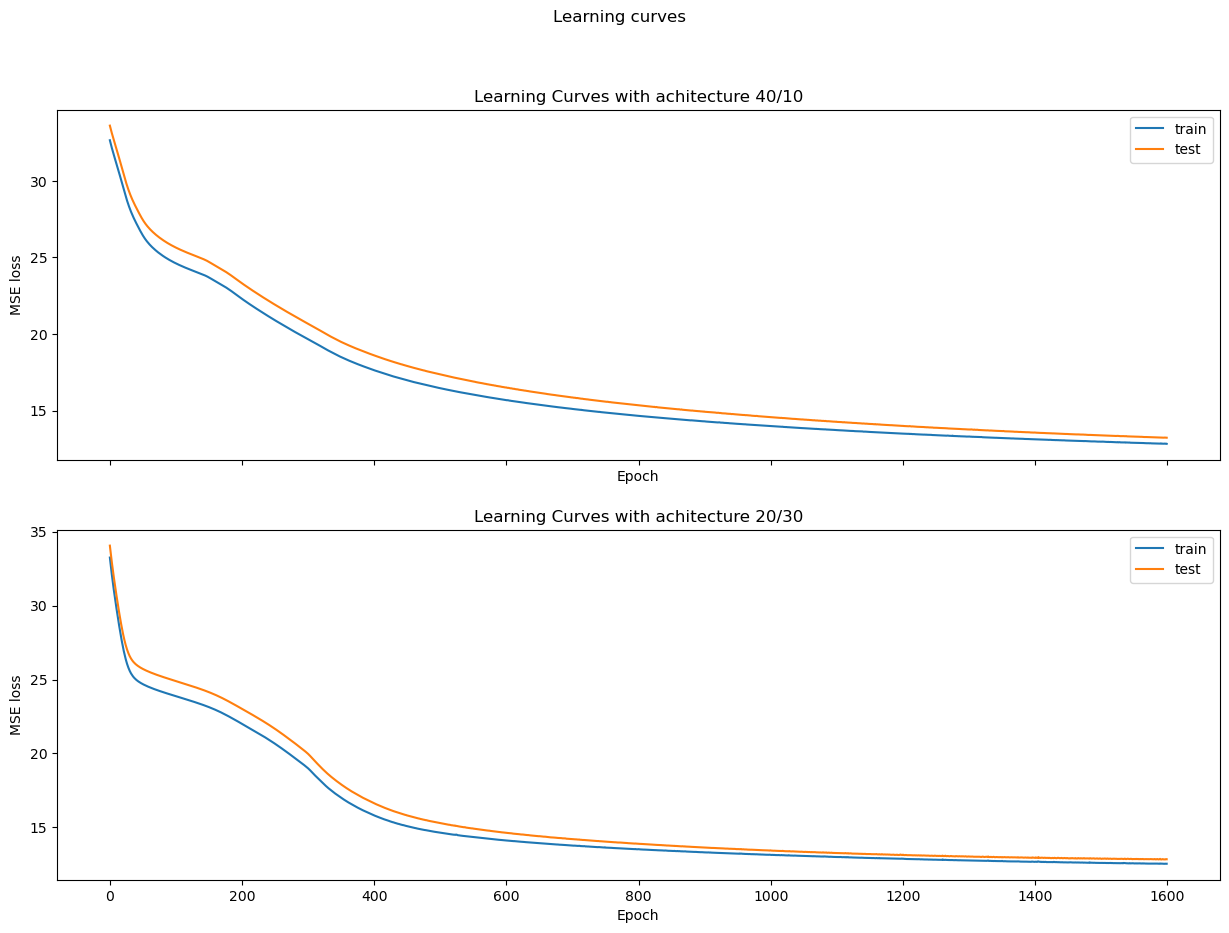

In [19]:
def tuning_arch(learning_rate1, num_percept_layers):
    #tuning the architecture of the NN
    fig, axs = plt.subplots(2, sharex=True)
    fig.suptitle('Learning curves')
    fig.set_figheight(10)
    fig.set_figwidth(15)

    for i in range(len(num_percept_layers)):
     
        [num_percept_layer1, num_percept_layer2] = num_percept_layers[i]
     
        model, history = train(learning_rate1, num_percept_layer1, num_percept_layer2)

        model.save('./exer2_model.h5')

        # plot learning curves
        axs[i].set_title('Learning Curves with achitecture ' + str(num_percept_layer1) + '/' + str(num_percept_layer2))
        axs[i].set_xlabel('Epoch')
        axs[i].set_ylabel('MSE loss')
        axs[i].plot((history.history['loss']), label='train')
        axs[i].plot((history.history['val_loss']), label='test')
        axs[i].legend()
    
    plt.show()

# training with the train dataset for different numbers of perceptrons in each layer
learning_rate1= 0.001
epochs = 1600       
batch_size = 8000
num_percept_layers= [ [40, 10] , [20, 30] ]

tuning_arch(learning_rate1, num_percept_layers)

(if needed, please scroll down the output cell to view the plots)

The 20/10 architecture was well-chosen since the 40/10 and the 20/30 architectures do not perform better.

To have yet better results, one could try to raise the number of layers. This would maybe allow the network represent even more nonlinear relations between the data.